#  <span style='color:DarkBlue'>P7 - Implémentez un modèle de scoring</span>

<div style="text-align:center">
    <img src="images/logo_proj7_credit.png" width="50%">
</div>

Ce notebook traite du pré processing des jeux de données :

- **application_train/set.csv**,
- **bureau.csv**,
- **bureau_balance.csv**,
- **credit_card_balance.csv**,
- **installments_payments.csv**,
- **POS_CASH_balance.csv**,
- **previous_application.csv**

En particulier :

- **Nettoyage** :
    - **optimisation de la mémoire** en modifiant le type des données. 
    - correction des **valeurs aberrantes**.
    - **imputation** des valeurs manquantes
- **Feature engineering** : dans cette section, nous allons commencer par utiliser les connaissances et les connaissances acquises lors de l'analyse exploratoire des données pour obtenir de bons ensembles de variables en utilisant le feature engineering. Il convient de noter que la plupart des varaibles générées sont basées sur la connaissance du domaine et les expérimentations. Sans de bons ensembles de variibles, les algorithmes d'apprentissage automatique ne peuvent pas produire de résultats efficaces. Nous devrons donc trouver des moyens ingénieux de faire de l'ingénierie des caractéristiques pour que le modèle prenne de meilleures décisions. 
- **Aggregation** : avec les données principales de Home Crédit Group.

***
Sources
***
Les fonctions d'aggrégation ont été reprises du notebook : [Source](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering/output) en adaptant la signature pour transmettre le prefix du nom des colonnes et pouvoir passer un dictionnaire des statistiques qu'on souhaite ajouter.

## <span style='background: PowderBlue'>1. Introduction</span>

*****
**Mission**
*****
**Développer un modèle de scoring de la probabilité de défaut de paiement du client** pour étayer la décision d'accorder ou non un prêt à un client potentiel en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières...).

*****
**Objectifs**
*****
- analyser le jeu de données,
- Construire **un modèle de scoring** qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique,
- réaliser un **dashboard interactif** permettant aux chargés de clientèles d'expliquer de manière transparente la décision d'octroi ou non de crédit

*****
**Sources**
*****
- [Jeu de données](https://www.kaggle.com/c/home-credit-default-risk/data)

Le **Kernel Kaggle** utilisé pour l'analyse exploratoire ayant l'EDA le plus de commentaires et effectuant une analyse exploratoire complète sur toutes les fichiers csv mis à notre disposition a été livré par **Rishabh Rao** (Student at -Jaipur, Rajasthan, India).
- [Kernel Kaggle Rishabh Rao](https://www.kaggle.com/rishabhrao/home-credit-default-risk-extensive-eda)

Ce travail est complété par l'auteur par une présentation sur le site medium.com :
[Explications](https://medium.com/thecyphy/home-credit-default-risk-part-1-3bfe3c7ddd7a)

Les fonctions python utilisées pour l'EDA sont extraites du [github](https://github.com/rishabhrao1997/Home-Credit-Default-Risk) et stockées dans la librairie *EDA_KERNEL_FONCTIONS.py*.

In [1]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
#import jyquickhelper
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import pickle 
#import verstack
#from verstack import NaNImputer
import fonctions_data
#import eda_kernel_fonctions
# import phik
# Plotly
import plotly
# import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from xplotter.insights import *

import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Warnings
warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode(connected=True)

# %matplotlib inline
# # Chargement à chaud des librairies personnelles
# %load_ext autoreload
# %autoreload 2
# # Valide code pep8
# %load_ext pycodestyle_magic
# %pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Outils dataframe      : ' + fonctions_data.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.24.4
Pandas                : 1.5.3
Outils dataframe      : 0.0.0
Lancé le           : 2024-05-03T16:13:27.704445


## <span style='background:PowderBlue' id="#section_2">2. Dataset</span>

**Chargement des fichiers**

In [2]:
# Importation des données train et test

train = pd.read_csv('home_credit_default_risk/application_train.csv')
test = pd.read_csv('home_credit_default_risk/application_test.csv')

In [3]:
# Créer une liste contenant les noms des fichiers
noms_fichiers = ['home_credit_default_risk/bureau.csv', 'home_credit_default_risk/bureau_balance.csv', \
                 'home_credit_default_risk/credit_card_balance.csv', 'home_credit_default_risk/installments_payments.csv', \
                 'home_credit_default_risk/POS_CASH_balance.csv']

# Pour chaque nom de fichier dans la liste, lire le fichier avec pandas
for nom_fichier in noms_fichiers:
    fichier = pd.read_csv(nom_fichier)
    print("Lecture du fichier : ", nom_fichier)
    print(fichier.head())
    print(fichier.shape)
    print("--------------------------------------------------")

Lecture du fichier :  home_credit_default_risk/bureau.csv
   SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                

**Vue d'ensemble**

In [377]:
# Vue d'ensemble des 9 jeux de données
# telechargment des 8 tables de l'organigramme

application_train = pd.read_csv('home_credit_default_risk/application_train.csv')
application_test = pd.read_csv('home_credit_default_risk/application_test.csv')
bureau = pd.read_csv('home_credit_default_risk/bureau.csv')
bureau_balance = pd.read_csv('home_credit_default_risk/bureau_balance.csv')
credit_card_balance = pd.read_csv('home_credit_default_risk/credit_card_balance.csv')
installment_payment = pd.read_csv('home_credit_default_risk/installments_payments.csv')
cash_balance = pd.read_csv('home_credit_default_risk/POS_CASH_balance.csv')
previous_application = pd.read_csv('home_credit_default_risk/previous_application.csv')
homecredit_columns_description = pd.read_csv('home_credit_default_risk/homecredit_columns_description.csv', encoding='latin-1')

dataframes = [application_train, application_test, bureau, bureau_balance,
              credit_card_balance, installment_payment, cash_balance,
              previous_application, homecredit_columns_description]
noms = ['application_train', 'application_test', 'bureau', 'bureau_balance',
        'cc_balance', 'installments_payments', 'POS_CASH_balance',
        'previous_application', 'HomeCredit_columns_description']
fonctions_data.resume_datasets(dataframes, noms)

Les données se décomposent en 9 fichier(s).


## <span style='background:PowderBlue'>3. Données du train et du test set</span>

Traitement des fichiers **application_train.csv** et **application_test.csv**

### <span style='background:orange'>3.1. Fichiers application_train.csv</span>

In [378]:
# Taille : nombre de lignes/colonnes
nRow, nVar = application_train.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 307511 lignes et 122 variables.


In [379]:
# Variables quantitatives
cols_num = application_train.select_dtypes(include=[np.number]).columns \
    .to_list()

In [380]:
# Variables catégorielles
cols_cat = application_train.select_dtypes(exclude=[np.number]).columns \
    .to_list()

#### <span style='background:Moccasin'>3.1.1. Réduction de la mémoire d'usage de chaque dataframe</span>

In [37]:
fonctions_data.description_dataset(application_train, 'train data')

On traite le dataset  train data


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  

[3 rows x 122 columns]

Taille :-------------------------------------------------------------- (307511, 122)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Valeurs manquantes  % total des valeurs
COMMONAREA_MEDI                           214865                 69.9
COMMONAREA_AVG                            214865                 69.9
COMMONAREA_MODE                           214865                 69.9
NONLIVINGAPARTMENTS_MEDI                  213514                 69.4
NONLIVINGAPARTMENTS_MODE                  213514                 69.4
NONLIVINGAPARTMENTS_AVG                   213514                 69.4
FONDKAPREMONT_MODE                        210295                 68.4
LIVINGAPARTMENTS_MODE                     210199                 68.4
LIVINGAPARTMENTS_MEDI                     210199                 68.4
LIVINGAPARTMENTS_AVG                      210199                 68.4
FLOORSMIN_MODE                            208642                 67.8
FLOORSMIN_MEDI                            208642                 67.8
FLOORSMIN_AVG                             208642                 67.8
YEARS_BUILD_MODE                          204488                 66.5
YEARS_BUILD_MEDI                          204488                 66.5
YEARS_BUILD_AVG                           204488                 66.5
OWN_CAR_AGE                               202929                 66.0
LANDAREA_AVG                              182590                 59.4
LANDAREA_MEDI                             182590                 59.4
LANDAREA_MODE                             182590                 59.4
BASEMENTAREA_MEDI                         179943                 58.5
BASEMENTAREA_AVG                          179943                 58.5
BASEMENTAREA_MODE                         179943                 58.5
EXT_SOURCE_1                              173378                 56.4
NONLIVINGAREA_MEDI                        169682                 55.2
NONLIVINGAREA_MODE                        169682                 55.2
NONLIVINGAREA_AVG                         169682                 55.2
ELEVATORS_MEDI                            163891                 53.3
ELEVATORS_MODE                            163891                 53.3
ELEVATORS_AVG                             163891                 53.3
WALLSMATERIAL_MODE                        156341                 50.8
APARTMENTS_MODE                           156061                 50.7
APARTMENTS_MEDI                           156061                 50.7
APARTMENTS_AVG                            156061                 50.7
ENTRANCES_MODE                            154828                 50.3
ENTRANCES_AVG                             154828                 50.3
ENTRANCES_MEDI                            154828                 50.3
LIVINGAREA_MEDI                           154350                 50.2
LIVINGAREA_MODE                           154350                 50.2
LIVINGAREA_AVG                            154350                 50.2
HOUSETYPE_MODE                            154297                 50.2
FLOORSMAX_MEDI                            153020                 49.8
FLOORSMAX_AVG                             153020                 49.8
FLOORSMAX_MODE                            153020                 49.8
YEARS_BEGINEXPLUATATION_AVG               150007                 48.8
YEARS_BEGINEXPLUATATION_MEDI              150007                 48.8
YEARS_BEGINEXPLUATATION_MODE              150007                 48.8
TOTALAREA_MODE                            148431                 48.3
EMERGENCYSTATE_MODE                       145755                 47.4
OCCUPATION_TYPE                            96391                 31.3

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_CURR------------------------------------------------------------ contient 307511 valeurs différentes
TARGET---------------------------------------------------------------- [1 0]
NAME_CONTRACT_TYPE---------------------------------------------------- ['Cash loans' 'Revolving loans']
CODE_GENDER----------------------------------------------------------- ['M' 'F' 'XNA']
FLAG_OWN_CAR---------------------------------------------------------- ['N' 'Y']
FLAG_OWN_REALTY------------------------------------------------------- ['Y' 'N']
CNT_CHILDREN---------------------------------------------------------- [ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]
AMT_INCOME_TOTAL------------------------------------------------------ contient 2548 valeurs différentes
AMT_CREDIT------------------------------------------------------------ contient 5603 valeurs différent

<Axes: title={'center': 'Répartition des types de colonnes'}>

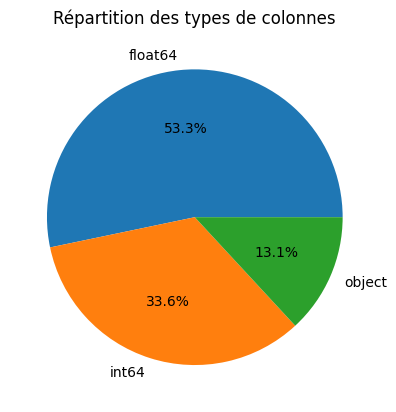

In [69]:
# Types des variables
application_train.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

On observe plusieurs colonnes de type binaires soit numérique soit catégorielles. Les mêmes variables que dans le dataset d'entraînement.

  -  .
Les noms des variables catégorielles comporte des majuscules, minuscules et caractères spéciaux.

In [384]:
application_train = fonctions_data.reduce_mem_usage(application_train, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 286.23 MB
Memory usage après optimization: 92.38 MB
Diminution de 67.7%
-------------------------------------------------------------------------------


In [385]:
# Modification à la main : REGION_RATING_CLIENT contient 1, 2 ou 3
# ==> object
application_train['REGION_RATING_CLIENT'] = \
    application_train['REGION_RATING_CLIENT'].astype('object')
# Modification à la main : REGION_RATING_CLIENT_W_CITY contient
# ==> 1, 2 ou 3 object
application_train['REGION_RATING_CLIENT_W_CITY'] = \
    application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')

In [387]:
# EMERGENCYSTATE_MODE contient Yes/No ==> transformer en 1/0

dico_emergency = {'Yes' : 0,
                  'No' : 1,
                  np.nan : 0}
fonctions_data.traduire_valeurs_variable(application_train,
                                      'EMERGENCYSTATE_MODE', dico_emergency)
application_train['EMERGENCYSTATE_MODE'] = \
    application_train['EMERGENCYSTATE_MODE'].astype('int8')

In [388]:
# FLAG_OWN_CAR contient Y/N ==> transformer en 1/0

dico_owncar = {'Y' : 0,
               'N' : 1,
               np.nan : 0}
fonctions_data.traduire_valeurs_variable(application_train, 'FLAG_OWN_CAR',
                                      dico_owncar)
application_train['FLAG_OWN_CAR'] = \
    application_train['FLAG_OWN_CAR'].astype('int8')
application_train['FLAG_OWN_CAR'].unique()

array([1, 0], dtype=int8)

In [389]:
# FLAG_OWN_REALTY contient Y/N ==> transformer en 1/0

dico_ownreal = {'Y' : 0,
                'N' : 1,
                np.nan : 0}
fonctions_data.traduire_valeurs_variable(application_train, 'FLAG_OWN_REALTY',
                                      dico_ownreal)
application_train['FLAG_OWN_REALTY'] = \
    application_train['FLAG_OWN_REALTY'].astype('int8')
application_train['FLAG_OWN_REALTY'].unique()

array([0, 1], dtype=int8)

<Axes: title={'center': 'Répartition des types de colonnes'}>

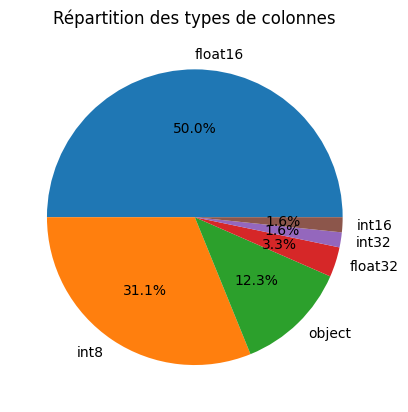

In [17]:
# Types des variables, après réduction mémoire dataframe
application_train.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### <span style='background:Moccasin'>3.1.2. Valeurs aberrantes</span>

Correction des valeurs aberrantes détectées lors de l'EDA.

**DAYS_EMPLOYED**

A partir du percentile 90, la valeur est 365243 jours donc 1000 ans !

In [390]:
# Nombre de ligne erronées
nb_err = \
    application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                       == 365243].count()
pourc_err = round((nb_err*100)/application_train.shape[0], 2)
print(f'Nombre d\'erreurs DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

Nombre d'erreurs DAYS_EMPLOYED : 55374 (18.01%)


In [391]:
# Correction
application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED']
                                   == 365243] = np.nan

#### <span style='background:Moccasin'>3.1.3. Comparaison variables catégorielles du train set et du test set</span>

**variables catégorielles - application_train**

In [392]:
cols_cat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [393]:
for var in cols_cat :
    var_train = application_train[var].unique()
    var_test = application_test[var].unique()
    diff = [val for val in var_train if val not in var_test]
    if len(diff) > 0 and diff != 'nan':
        print(f'Variable {var} - catégories différentes : {diff}')

Variable CODE_GENDER - catégories différentes : ['XNA']
Variable FLAG_OWN_CAR - catégories différentes : [1, 0]
Variable FLAG_OWN_REALTY - catégories différentes : [0, 1]
Variable NAME_TYPE_SUITE - catégories différentes : [nan]
Variable NAME_INCOME_TYPE - catégories différentes : ['Maternity leave']
Variable NAME_FAMILY_STATUS - catégories différentes : ['Unknown']
Variable OCCUPATION_TYPE - catégories différentes : [nan]
Variable FONDKAPREMONT_MODE - catégories différentes : [nan]
Variable HOUSETYPE_MODE - catégories différentes : [nan]
Variable WALLSMATERIAL_MODE - catégories différentes : [nan]
Variable EMERGENCYSTATE_MODE - catégories différentes : [1, 0]


**CODE_GENDER**

In [394]:
# Nombre de lignes ayant la valeur 'XNA' ?
application_train[application_train['CODE_GENDER'] ==
                  'XNA']['CODE_GENDER'].count()

4

In [395]:
# Correction : difficile d'imputer le sexe par le mode de cette catégorie
# Comme il n'y a que 4 clients avec un sexe non renseigné, on supprime ces
# valeurs
application_train = \
    application_train[application_train['CODE_GENDER'] != 'XNA']

**NAME_INCOME_TYPE**

In [396]:
# Nombre de lignes ayant la valeur 'XNA' ?
application_train[application_train['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

5

In [397]:
# Correction : remplacer 'Maternity leave' par np.nan
application_train['NAME_INCOME_TYPE'] = \
    [row if row != 'Maternity leave' else np.nan for row in
     application_train['NAME_INCOME_TYPE']]
# Vérification
application_train[application_train['NAME_INCOME_TYPE'] ==
                  'Maternity leave']['NAME_INCOME_TYPE'].count()

0

**NAME_FAMILY_STATUS**

In [398]:
# Nombre de lignes ayant la valeur 'Maternity leave' ?
application_train[application_train['NAME_FAMILY_STATUS'] ==
                  'Unknown']['NAME_FAMILY_STATUS'].count()

2

In [399]:
# Correction : remplacer 'Unknown' par np.nan
application_train['NAME_FAMILY_STATUS'] = \
    [row if row != 'Unknown' else np.nan for row in
     application_train['NAME_FAMILY_STATUS']]
# Vérification
application_train[application_train['NAME_FAMILY_STATUS'] ==
                  'Unknown']['NAME_FAMILY_STATUS'].count()

0

In [400]:
cols_to_clean = ["NAME_CONTRACT_TYPE",
        "NAME_TYPE_SUITE",
        "OCCUPATION_TYPE",
        "WALLSMATERIAL_MODE",
        "HOUSETYPE_MODE",
        "NAME_HOUSING_TYPE",
        "NAME_FAMILY_STATUS"]

**Nettoyage des caractères spéciaux**

In [402]:
application_train[cols_to_clean] = application_train[cols_to_clean].applymap(fonctions_data.cleaning_categories)

In [403]:
application_test[cols_to_clean] = application_test[cols_to_clean].applymap(fonctions_data.cleaning_categories)

#### <span style='background:Moccasin'>3.1.4. Gestion des corrélations</span>

In [64]:
#Trouvons les corrélations avec la target et trions les 
correlations = application_train.corr()['TARGET'].sort_values()

In [65]:
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 FLAG_WORK_PHONE             0.028533
DEF_60_CNT_SOCIAL_CIRCLE    0.031295
DEF_30_CNT_SOCIAL_CIRCLE    0.032261
LIVE_CITY_NOT_WORK_CITY     0.032517
OWN_CAR_AGE                 0.037611
DAYS_REGISTRATION           0.041976
FLAG_DOCUMENT_3             0.044341
REG_CITY_NOT_LIVE_CITY      0.044394
FLAG_EMP_PHONE              0.045984
REG_CITY_NOT_WORK_CITY      0.050992
DAYS_ID_PUBLISH             0.051457
DAYS_LAST_PHONE_CHANGE      0.055220
DAYS_EMPLOYED               0.074957
DAYS_BIRTH                  0.078242
TARGET                      1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178925
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155318
FLOORSMAX_AVG                -0.044010
FLOORSMAX_MEDI               -0.043775
FLOORSMAX_MODE               -0.043233
EMERGENCYSTATE_MODE          -0.042200
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037229
ELEVAT

Corrélations les plus signifiactives:
- La corrélation **DAYS_BIRTH** est la plus positive.- 
La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie que plus le client vieillit, moins il est susceptible de ne pas rembourser son prêt (c'est-à-dire que la cible == 0).
C'est un peu déroutant, nous allons donc prendre la valeur absolue de la caractéristique et la corrélation sera alors négative.

In [66]:
# Find the correlation of the positive days since birth and target
application_train['DAYS_BIRTH'] = abs(application_train['DAYS_BIRTH'])
print("Corrélation entre l'âge du client au moment du prêt et la TARGET :", application_train['DAYS_BIRTH'].corr(application_train['TARGET']))

Corrélation entre l'âge du client au moment du prêt et la TARGET : -0.07824216003619362


Plus les clients vieillissent, plus ils ont tendance à rembourser leurs prêts dans les délais.

- 
Tout d'abord, nous pouvons faire un histogramme de l'â, et nous us allons mettre l'axe des x en ann.ées

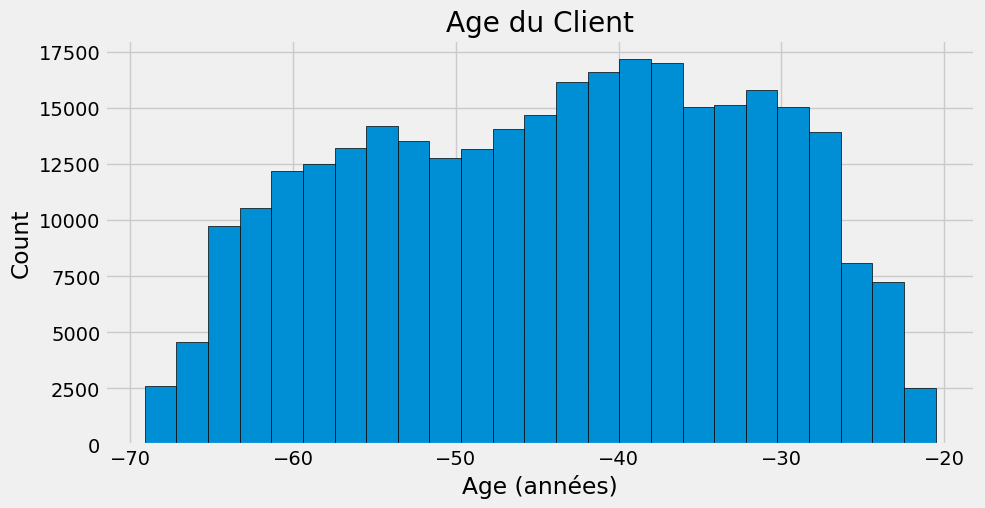

In [67]:
# choix du style du tracé
plt.style.use('fivethirtyeight')

# Tracé de la distribution des ages
plt.figure(figsize=(10,5))
plt.hist(train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age du Client'); plt.xlabel('Age (années)'); plt.ylabel('Count');

Les variables avec les plus fortes corrélations négatives sont les variables EXT.

Montrons les corrélations des caractéristiques EXT_SOURCE avec la cible et entre elles.

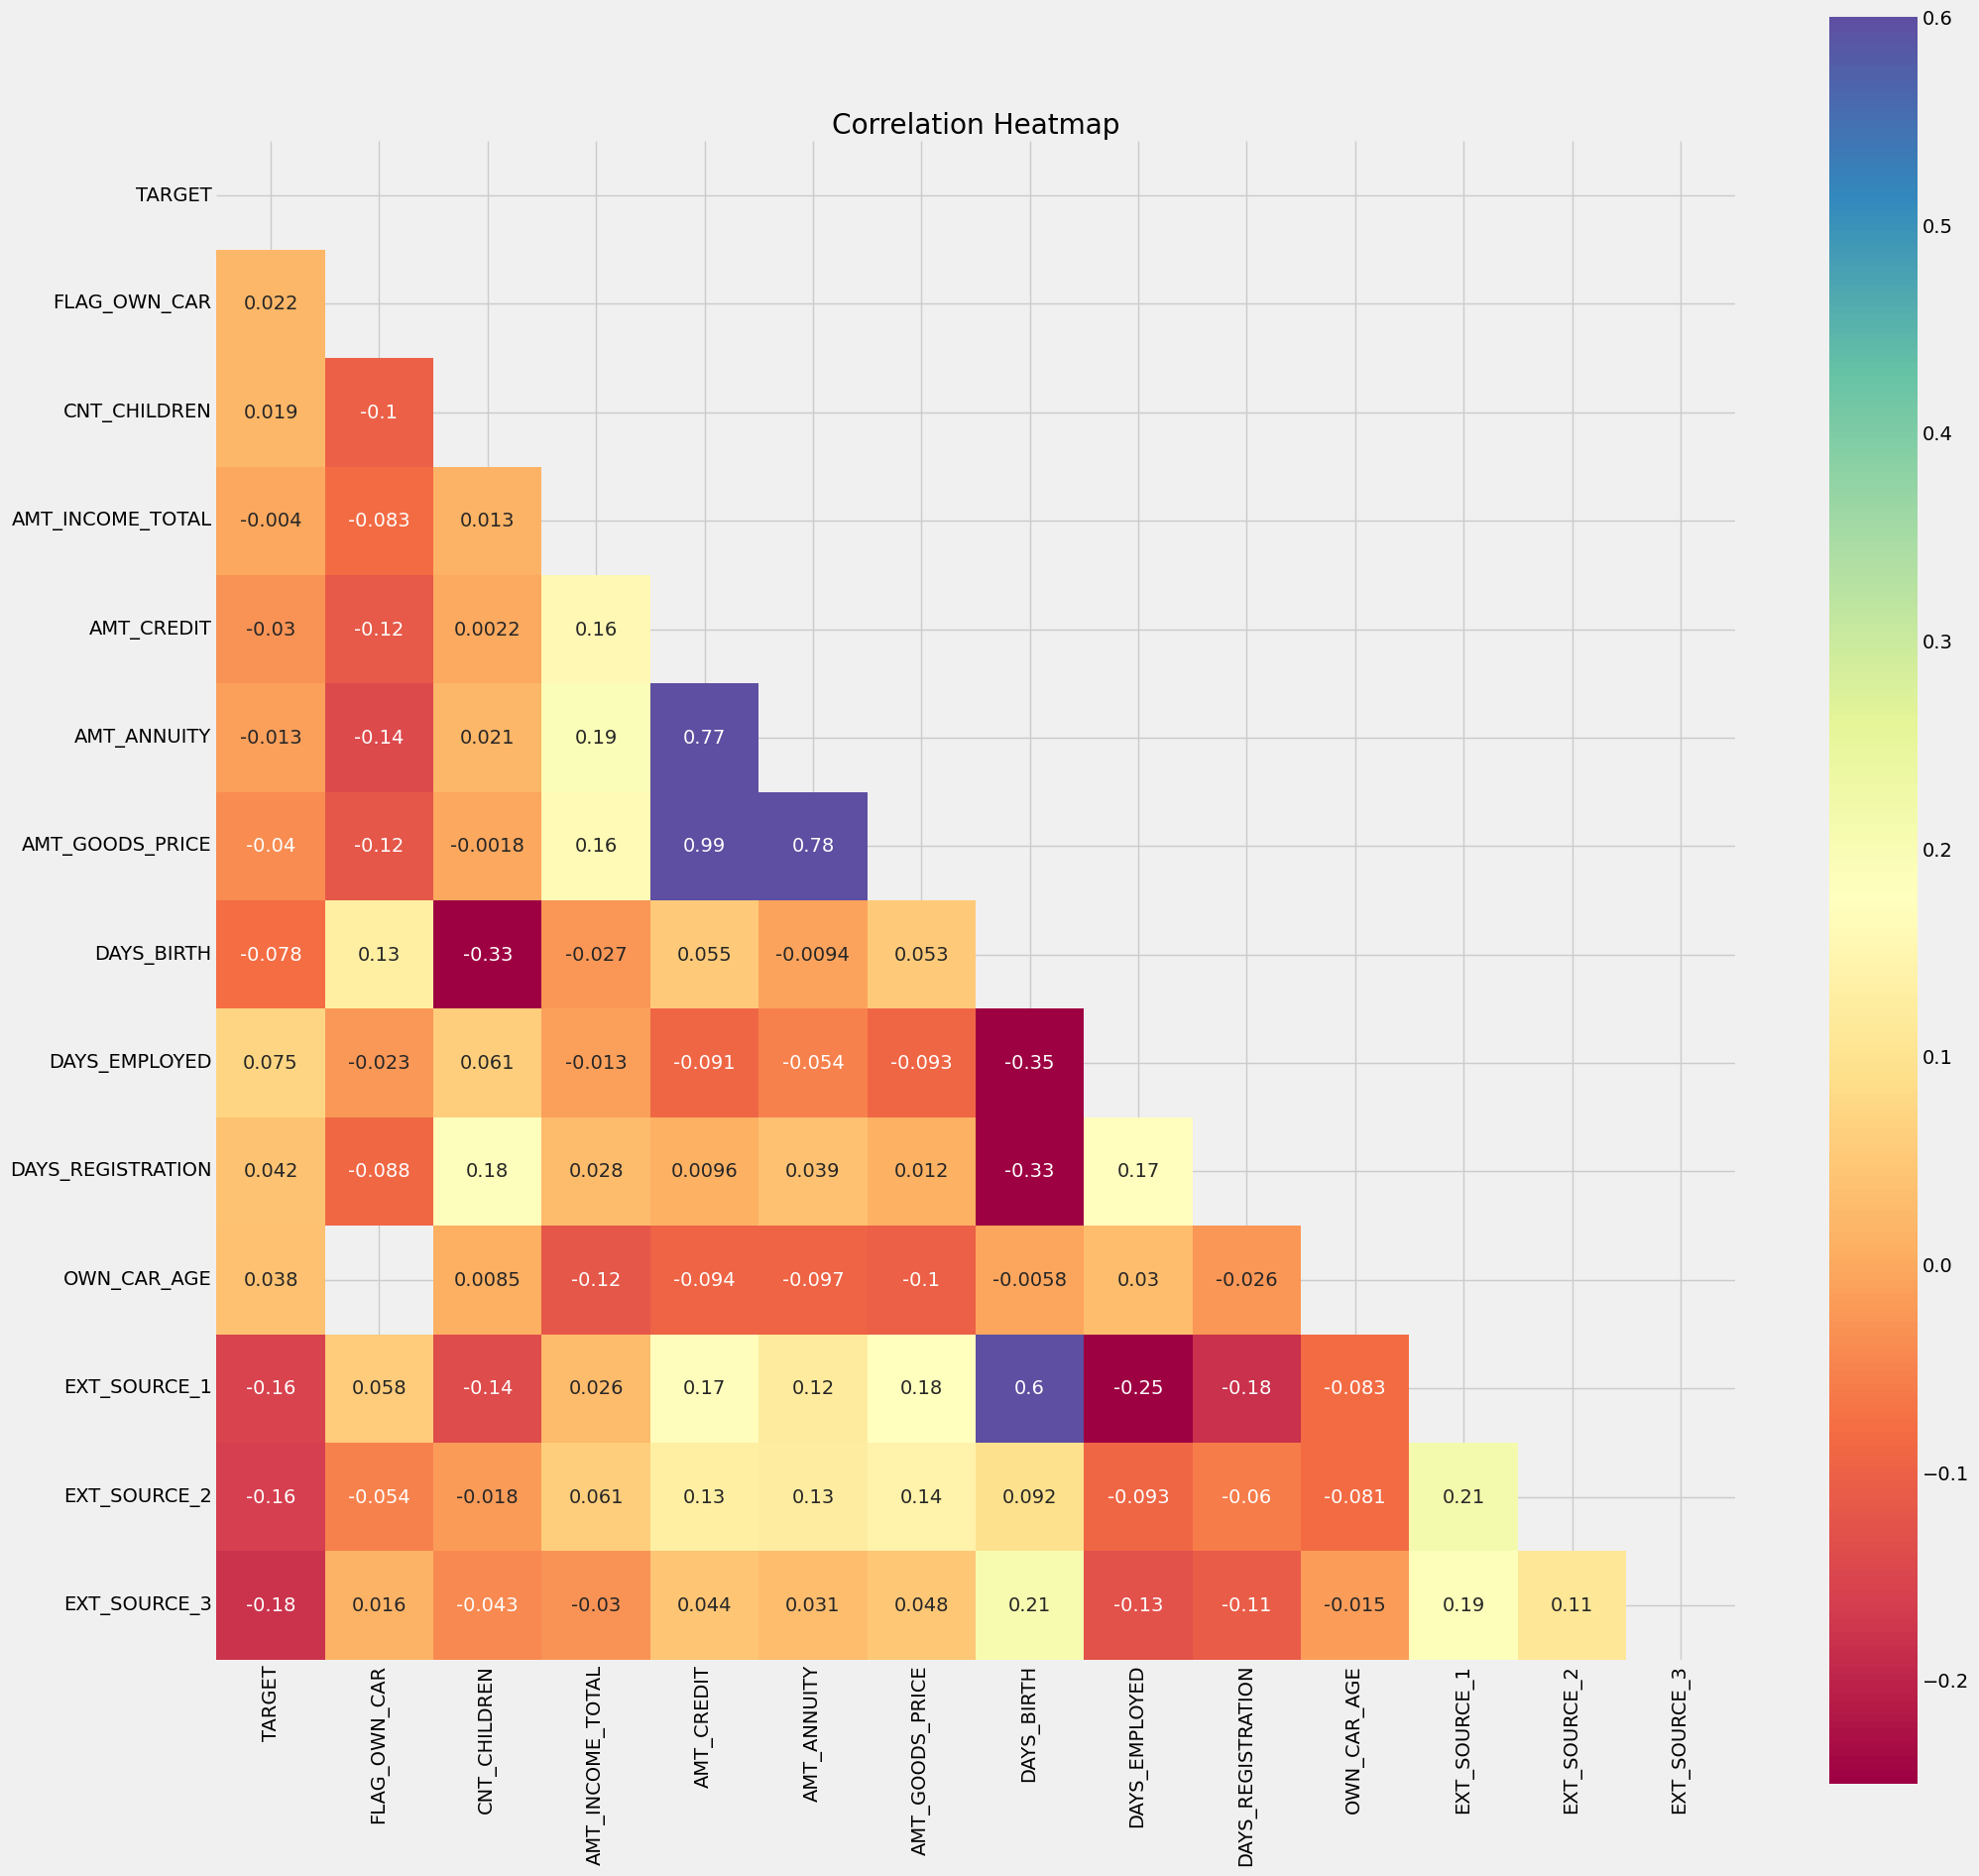

In [68]:
ext_data = application_train[['TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'OWN_CAR_AGE',
 'REGION_RATING_CLIENT',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3']]

plt.figure(figsize = (22, 22))
mask = np.triu(np.ones_like(ext_data.corr()))
    
# Heatmap of correlations
sns.heatmap(ext_data.corr(),mask = mask, cmap = plt.cm.Spectral,square=True, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

**Feature engineering**
- Création de nouvelles variables simples
- Catégorisation des variables binaires
- Imputation des valeurs manquantes
- Encodage des variables catégorielles
- Normalisation des variables numériues


In [404]:
application_train.reset_index(drop=True, inplace=True)
application_test.reset_index(drop=True, inplace=True)


df_train = application_train.copy()
df_test = application_test.copy()

In [405]:
#Récupération des identifiants clients et des labels 
train_ids = df_train["SK_ID_CURR"]
test_ids = df_test["SK_ID_CURR"]

labels = df_train.TARGET

In [406]:
def cat_encoder(features, test_features):
    '''
    Fonction qui fais un one hot encodage sur les variables
    catégorielles à l'aide de get_dummies.
    Elle fais un label encoder sur les variables binaires. 
    Elle traite les valeurs manquantes comme des catégories.
    Elle retourne les datasets encodés.
    '''
    label_encoder = LabelEncoder()
    
    categorical_columns_train  = []
    categorical_columns_test  = []
    
    for col in features :
        if col != "TARGET":
            if features[col].dtype == object:
                #Label encodage pour les variables binaires
                if features[col].nunique()==2:
                    features[col] = label_encoder.fit_transform(features[col])
                #récupération des colonnes où on fera un one hot encodage
                elif features[col].nunique()>2:
                    categorical_columns_train.append(col)
                    
    features = pd.get_dummies(features, columns = categorical_columns_train,dummy_na= True)
    
    for col in test_features :
        if test_features[col].dtype == object:
            #Label encodage pour les variables binaires
            if test_features[col].nunique()==2:
                test_features[col] = label_encoder.fit_transform(test_features[col])
            #récupération des colonnes où on fera un one hot encodage
            elif test_features[col].nunique()>2:
                categorical_columns_test.append(col)
    
    test_features = pd.get_dummies(test_features,columns = categorical_columns_test, dummy_na= True)
    
    #Alignement des dataframes
    features, test_features = features.align(test_features, join= 'inner', axis=1)

    return features, test_features

In [407]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler



def create_features(train, test):
    # Feature engineering for train data
    train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
    train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)


    # Feature engineering for test data
    test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
    test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
    
    return train, test


def engineer_features(df_train_feat, df_test_feat):

    train, test = create_features(df_train_feat, df_test_feat)
    df_train = train.copy()
    df_test = test.copy()

    #train data
    df_train['PROPORTION_LIFE_EMPLOYED'] = df_train['DAYS_EMPLOYED'] / df_train['DAYS_BIRTH']
    df_train['INCOME_TO_CREDIT_RATIO'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_CREDIT']
    df_train['INCOME_TO_ANNUITY_RATIO'] = df_train['AMT_INCOME_TOTAL'] / df_train['AMT_ANNUITY']
    df_train['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = df_train['INCOME_TO_ANNUITY_RATIO'] * df_train['DAYS_BIRTH']
    df_train['CREDIT_TO_ANNUITY_RATIO'] = df_train['AMT_CREDIT'] / df_train['AMT_ANNUITY']
    df_train['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = df_train['CREDIT_TO_ANNUITY_RATIO'] * df_train['DAYS_BIRTH']
    df_train['INCOME_TO_FAMILYSIZE_RATIO'] = df_train['AMT_INCOME_TOTAL'] / df_train['CNT_FAM_MEMBERS']
    df_train['ANNUITY_INCOME_PERC'] = df_train['AMT_ANNUITY'] / df_train['AMT_INCOME_TOTAL']

    #Test data
    df_test['PROPORTION_LIFE_EMPLOYED'] = df_test['DAYS_EMPLOYED'] / df_test['DAYS_BIRTH']
    df_test['INCOME_TO_CREDIT_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_CREDIT']
    df_test['INCOME_TO_ANNUITY_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['AMT_ANNUITY']
    df_test['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = df_test['INCOME_TO_ANNUITY_RATIO'] * df_test['DAYS_BIRTH']
    df_test['CREDIT_TO_ANNUITY_RATIO'] = df_test['AMT_CREDIT'] / df_train['AMT_ANNUITY']
    df_test['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = df_test['CREDIT_TO_ANNUITY_RATIO'] * df_test['DAYS_BIRTH']
    df_test['INCOME_TO_FAMILYSIZE_RATIO'] = df_test['AMT_INCOME_TOTAL'] / df_test['CNT_FAM_MEMBERS']
    df_test['ANNUITY_INCOME_PERC'] = df_test['AMT_ANNUITY'] / df_test['AMT_INCOME_TOTAL']
    
    return df_train, df_test


def preprocess_data(train_preproc, test_preproc):


    df_train, df_test = engineer_features(train_preproc, test_preproc)


    features=df_train.copy()
    test_features=df_test.copy()

    # Extraction des ID
    
    train_ids = features["SK_ID_CURR"]
    test_ids = test_features["SK_ID_CURR"]

    
    # Extraction des Targets
    labels = features['TARGET']
    
   
    # Suppression des ID and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])

    features, test_features = cat_encoder(features, test_features)
    
    
    # Extraction des noms des Feature
    feat_name = list(features.columns)

    #Imputation des Nan 
    imputer = SimpleImputer(strategy = 'median')

    features = imputer.fit_transform(features)
    test_features = imputer.transform(test_features)

    # Scale les features
    scaler = MinMaxScaler(feature_range = (0, 1))

    features = scaler.fit_transform(features)
    test_features = scaler.transform(test_features)

    # Création des dataset
    features_set=pd.DataFrame(features,columns=feat_name)
    test_features_set=pd.DataFrame(test_features,columns=feat_name)
    
    #Ajout de la colonne TARGET et des ids
    features_set['TARGET']=labels
    features_set["SK_ID_CURR"] = train_ids
    test_features_set['SK_ID_CURR'] = test_ids
    
    #Passage des id en index
    features_set.set_index('SK_ID_CURR', inplace = True)
    test_features_set.set_index('SK_ID_CURR',inplace = True)

    
    return features_set, test_features_set



def clean_data(train_clean, test_clean):

    train_c, test_c = preprocess_data(train_clean, test_clean)
    
    print('Training Data Shape: ', train_c.shape)
    print('Testing Data Shape: ', test_c.shape)
    
    return train_c, test_c

In [408]:
# Appel de la fonction de cleaning (avec les étapes de création, construction de features, pré-processing)

features_set, test_features_set = clean_data(df_train, df_test)

Training Data Shape:  (307507, 259)
Testing Data Shape:  (48744, 258)


In [409]:
features_set = features_set.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_features_set = test_features_set.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [410]:
test_features = test_features_set.reset_index()

In [40]:
test_features.to_csv("test_preprocess.csv", index=False)

In [41]:
# Sauvegarde de test_set nettoyé
pickle.dump(test_features_set, open( "pickle_files/test_preprocess.p", "wb"))
    
# Sauvegarde de train_set nettoyé
with open('pickle_files/fichier_train_preprocess.pickle', 'wb') as fichier:
    pickle.dump(features_set, fichier, pickle.HIGHEST_PROTOCOL)

### <span style='background:orange'>3.2. Fichiers application_test.csv</span>

In [38]:
# Taille : nombre de lignes/colonnes
nRow, nVar = application_test.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 48744 lignes et 121 variables.


In [39]:
# Variables quantitatives
cols_num = application_test.select_dtypes(include=[np.number]).columns \
    .to_list()

In [40]:
# Variables catégorielles
cols_cat = application_test.select_dtypes(exclude=[np.number]).columns \
    .to_list()

#### <span style='background:Moccasin'>3.2.1. Réduction de la mémoire d'usage de chaque dataframe</span>

On traite le dataset  test data


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         CASH LOANS           F            N               Y   
1      100005         CASH LOANS           M            N               Y   
2      100013         CASH LOANS           M            Y               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  

[3 rows x 121 columns]

Taille :-------------------------------------------------------------- (48744, 121)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Valeurs manquantes  % total des valeurs
COMMONAREA_AVG                             33495                 68.7
COMMONAREA_MEDI                            33495                 68.7
COMMONAREA_MODE                            33495                 68.7
NONLIVINGAPARTMENTS_MODE                   33347                 68.4
NONLIVINGAPARTMENTS_MEDI                   33347                 68.4
NONLIVINGAPARTMENTS_AVG                    33347                 68.4
FONDKAPREMONT_MODE                         32797                 67.3
LIVINGAPARTMENTS_AVG                       32780                 67.2
LIVINGAPARTMENTS_MEDI                      32780                 67.2
LIVINGAPARTMENTS_MODE                      32780                 67.2
FLOORSMIN_MEDI                             32466                 66.6
FLOORSMIN_AVG                              32466                 66.6
FLOORSMIN_MODE                             32466                 66.6
OWN_CAR_AGE                                32312                 66.3
YEARS_BUILD_AVG                            31818                 65.3
YEARS_BUILD_MEDI                           31818                 65.3
YEARS_BUILD_MODE                           31818                 65.3
LANDAREA_AVG                               28254                 58.0
LANDAREA_MODE                              28254                 58.0
LANDAREA_MEDI                              28254                 58.0
BASEMENTAREA_MODE                          27641                 56.7
BASEMENTAREA_MEDI                          27641                 56.7
BASEMENTAREA_AVG                           27641                 56.7
NONLIVINGAREA_AVG                          26084                 53.5
NONLIVINGAREA_MODE                         26084                 53.5
NONLIVINGAREA_MEDI                         26084                 53.5
ELEVATORS_AVG                              25189                 51.7
ELEVATORS_MODE                             25189                 51.7
ELEVATORS_MEDI                             25189                 51.7
APARTMENTS_MEDI                            23887                 49.0
APARTMENTS_MODE                            23887                 49.0
APARTMENTS_AVG                             23887                 49.0
ENTRANCES_MODE                             23579                 48.4
ENTRANCES_MEDI                             23579                 48.4
ENTRANCES_AVG                              23579                 48.4
LIVINGAREA_AVG                             23552                 48.3
LIVINGAREA_MEDI                            23552                 48.3
LIVINGAREA_MODE                            23552                 48.3
FLOORSMAX_MEDI                             23321                 47.8
FLOORSMAX_MODE                             23321                 47.8
FLOORSMAX_AVG                              23321                 47.8
YEARS_BEGINEXPLUATATION_MEDI               22856                 46.9
YEARS_BEGINEXPLUATATION_MODE               22856                 46.9
YEARS_BEGINEXPLUATATION_AVG                22856                 46.9
TOTALAREA_MODE                             22624                 46.4
EMERGENCYSTATE_MODE                        22209                 45.6
EXT_SOURCE_1                               20532                 42.1
EXT_SOURCE_3                                8668                 17.8
AMT_REQ_CREDIT_BUREAU_HOUR                  6049                 12.4
AMT_REQ_CREDIT_BUREAU_QRT                   6049                 12.4

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_CURR------------------------------------------------------------ contient 48744 valeurs différentes
NAME_CONTRACT_TYPE---------------------------------------------------- ['CASH LOANS' 'REVOLVING LOANS']
CODE_GENDER----------------------------------------------------------- ['F' 'M']
FLAG_OWN_CAR---------------------------------------------------------- ['N' 'Y']
FLAG_OWN_REALTY------------------------------------------------------- ['Y' 'N']
CNT_CHILDREN---------------------------------------------------------- [ 0  2  1  3  8  4  6  5  7 20 11]
AMT_INCOME_TOTAL------------------------------------------------------ contient 606 valeurs différentes
AMT_CREDIT------------------------------------------------------------ contient 2937 valeurs différentes
AMT_ANNUITY----------------------------------------------------------- contient 7491 valeurs d

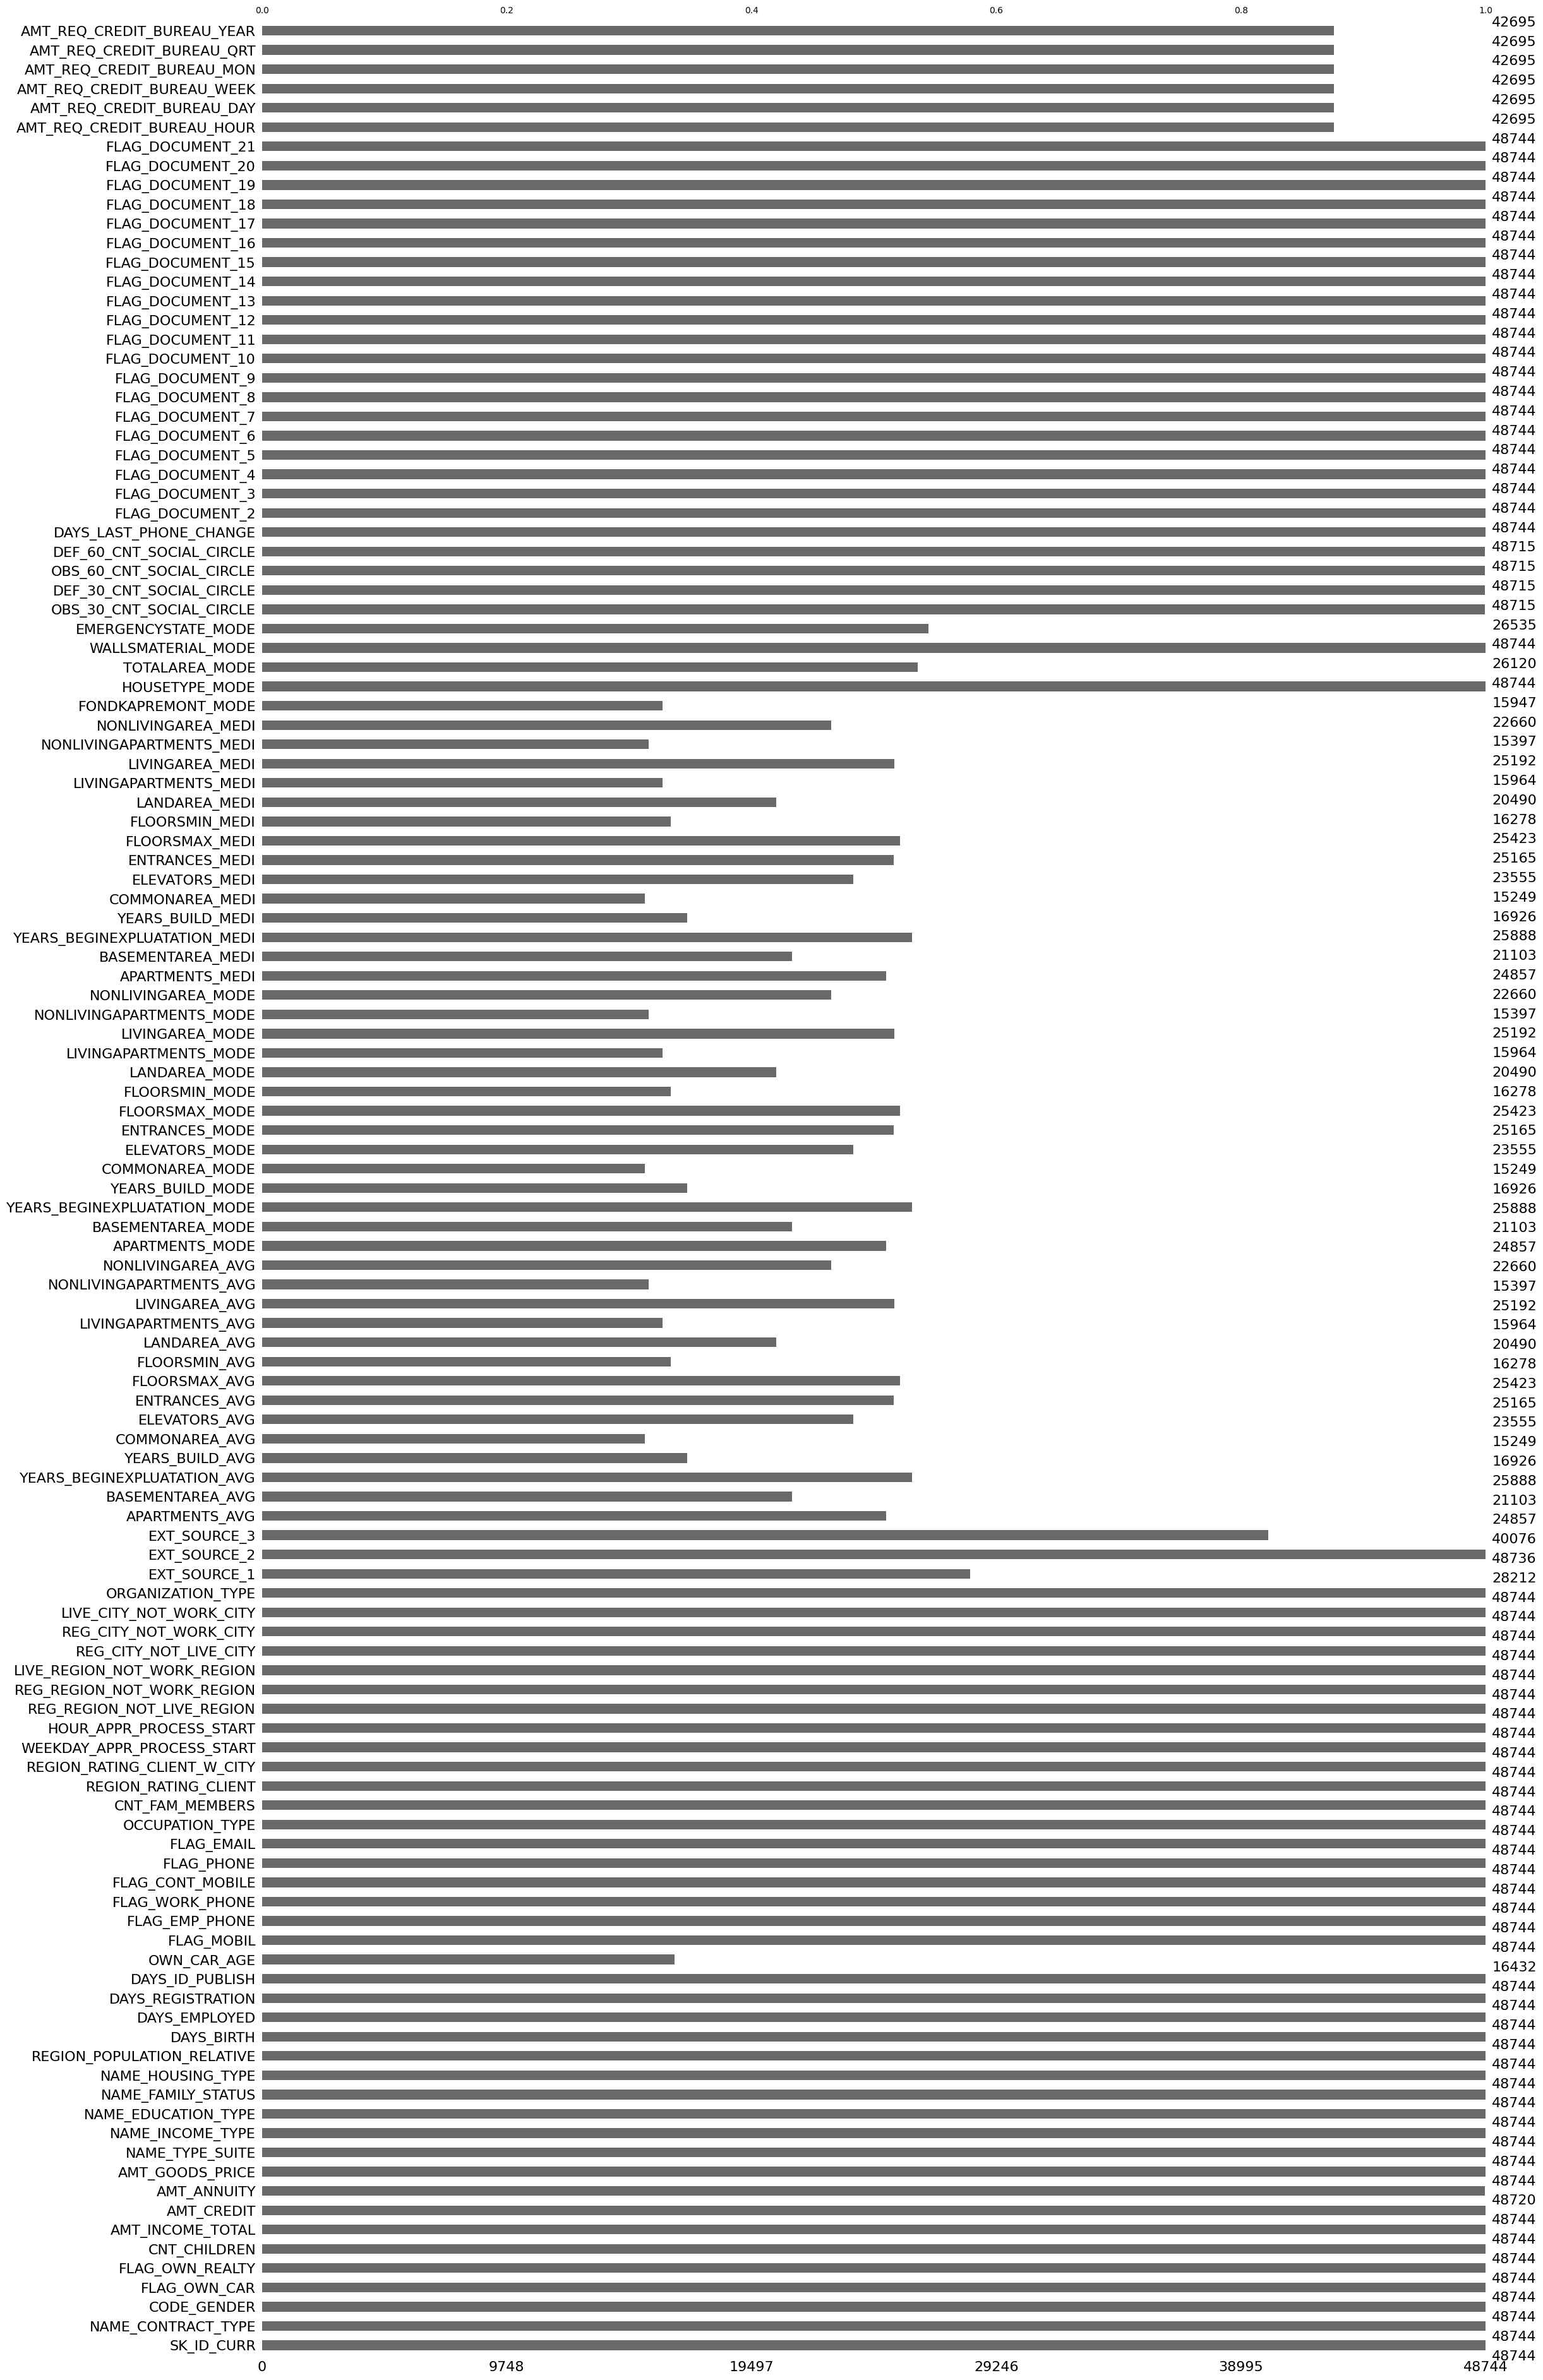

In [56]:
fonctions_data.description_dataset(application_test, 'test data')

<Axes: title={'center': 'Répartition des types de colonnes'}>

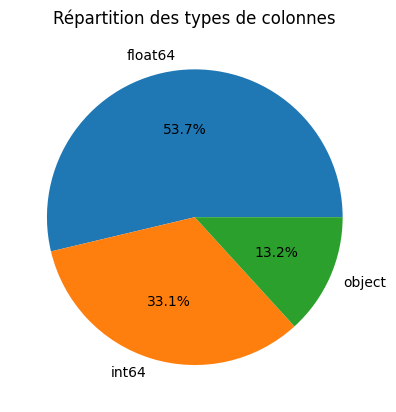

In [46]:
# Types des variables
application_test.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

In [41]:
application_test = fonctions_data.reduce_mem_usage(application_test, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 45.00 MB
Memory usage après optimization: 14.60 MB
Diminution de 67.6%
-------------------------------------------------------------------------------


In [42]:
# Modification à la main : REGION_RATING_CLIENT contient 1, 2 ou 3
# ==> object
application_test['REGION_RATING_CLIENT'] = \
    application_test['REGION_RATING_CLIENT'].astype('object')
# Modification à la main : REGION_RATING_CLIENT_W_CITY contient
# ==> 1, 2 ou 3 object
application_test['REGION_RATING_CLIENT_W_CITY'] = \
    application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')

In [43]:
# EMERGENCYSTATE_MODE contient Yes/No ==> transformer en 1/0

dico_emergency = {'Yes' : 0,
                  'No' : 1,
                  np.nan : 0}
fonctions_data.traduire_valeurs_variable(application_test,
                                      'EMERGENCYSTATE_MODE', dico_emergency)
application_test['EMERGENCYSTATE_MODE'] = \
    application_test['EMERGENCYSTATE_MODE'].astype('int8')

In [44]:
# FLAG_OWN_CAR contient Y/N ==> transformer en 1/0

dico_owncar = {'Y' : 0,
               'N' : 1,
               np.nan : 0}
fonctions_data.traduire_valeurs_variable(application_test, 'FLAG_OWN_CAR',
                                      dico_owncar)
application_test['FLAG_OWN_CAR'] = \
    application_test['FLAG_OWN_CAR'].astype('int8')

In [45]:
# FLAG_OWN_REALTY contient Y/N ==> transformer en 1/0

dico_ownreal = {'Y' : 0,
                'N' : 1,
                np.nan : 0}
fonctions_data.traduire_valeurs_variable(application_test, 'FLAG_OWN_REALTY',
                                      dico_ownreal)
application_test['FLAG_OWN_REALTY'] = \
    application_test['FLAG_OWN_REALTY'].astype('int8')

<Axes: title={'center': 'Répartition des types de colonnes'}>

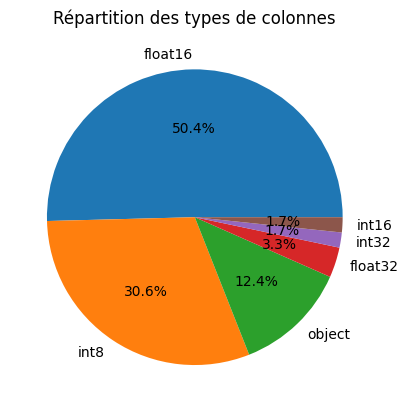

In [56]:
# Types des variables, après réduction mémoire dataframe
application_test.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### <span style='background:Moccasin'>3.2.2. Valeurs aberrantes</span>

Correction des valeurs aberrantes détectées lors de l'EDA.

**DAYS_EMPLOYED**

In [46]:
# Nombre de ligne erronées
nb_err = \
    application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                       == 365243].count()
pourc_err = round((nb_err*100)/application_test.shape[0], 2)
print(f'Nombre d\'erreurs DAYS_EMPLOYED : {nb_err} ({pourc_err}%)')

Nombre d'erreurs DAYS_EMPLOYED : 9274 (19.03%)


In [47]:
# Correction
application_test['DAYS_EMPLOYED'][application_test['DAYS_EMPLOYED']
                                   == 365243] = np.nan

## <span style='background:PowderBlue'>4. Données - Home Crédit Group</span>

4 fichiers contiennent des informations sur les prêts antérieurs chez Home Crédit :
- Le fichier principal des prêts antérieurs :
    - **previous_application**.
- Le détail sur ces prêts antérieurs :
    - **credit_card_balance**,
    - **installments_payments**,
    - **POS_CASH_balance**.

### <span style='background:orange'>4.1. Fichiers credit_card_balance.csv</span>

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0 ou 1 ou 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon</p> |  |
| <p style='text-align: justify;'>**MONTHS_BALANCE**</p> | <p style='text-align: justify;'>Mois du solde par rapport à la date d'application.</p> | -1 signifie la date de solde la plus récente |
| <p style='text-align: justify;'>**AMT_BALANCE**</p> | <p style='text-align: justify;'>Solde au cours du mois du crédit précédent</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_LIMIT_ACTUAL**</p> | <p style='text-align: justify;'>Limite de la carte de crédit au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_DRAWINGS_CURRENT**</p> | <p style='text-align: justify;'>Montant prélevé au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_DRAWINGS_OTHER_CURRENT**</p> | <p style='text-align: justify;'>Montant des autres prélèvements au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_DRAWINGS_POS_CURRENT**</p> | <p style='text-align: justify;'>Montant des prélèvements ou des achats de marchandises au cours du mois de la crédibilité précédente.</p> |  |
| <p style='text-align: justify;'>**AMT_INST_MIN_REGULARITY**</p> | <p style='text-align: justify;'>Versement minimal pour ce mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_PAYMENT_CURRENT**</p> | <p style='text-align: justify;'>Combien le client a-t-il payé pendant le mois sur le crédit précédent ?</p> |  |
| <p style='text-align: justify;'>**AMT_PAYMENT_TOTAL_CURRENT**</p> | <p style='text-align: justify;'>Combien le client a-t-il payé au total pendant le mois sur le crédit précédent ?</p> |  |
| <p style='text-align: justify;'>**AMT_RECEIVABLE_PRINCIPAL**</p> | <p style='text-align: justify;'>Montant à recevoir pour le principal du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_RECIVABLE**</p> | <p style='text-align: justify;'>Montant à recevoir sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**AMT_TOTAL_RECEIVABLE**</p> | <p style='text-align: justify;'>Montant total à recevoir sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_ATM_CURRENT**</p> | <p style='text-align: justify;'>Nombre de tirages au guichet automatique durant ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_CURRENT**</p> | <p style='text-align: justify;'>Nombre de tirages pendant ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_OTHER_CURRENT**</p> | <p style='text-align: justify;'>Nombre d'autres tirages au cours de ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_DRAWINGS_POS_CURRENT**</p> | <p style='text-align: justify;'>ombre de tirages de marchandises durant ce mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**CNT_INSTALMENT_MATURE_CUM**</p> | <p style='text-align: justify;'>Nombre d'échéances payées sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**NAME_CONTRACT_STATUS**</p> | <p style='text-align: justify;'>Statut du contrat (actif signé...) sur le crédit précédent.</p> | <ul style='text-align: justify;'><li>Active</li> <li>Completed</li> <li>Signed</li> <li>Sent proposal</li> <li>Refused</li> <li>Demand</li> <li>Approved</li></ul> |
| <p style='text-align: justify;'>**SK_DPD**</p> | <p style='text-align: justify;'>DPD (jours de retard) au cours du mois sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**SK_DPD_DEF**</p> | <p style='text-align: justify;'>DPD (Jours de retard) au cours du mois avec tolérance (les dettes avec de faibles montants de prêt sont ignorées) du crédit précédent.</p> |  |

In [411]:
# Taille : nombre de lignes/colonnes
nRow, nVar = credit_card_balance.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 3840312 lignes et 23 variables.


In [412]:
# Variables quantitatives
cols_num_ccb = credit_card_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_ccb

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'AMT_BALANCE',
 'AMT_CREDIT_LIMIT_ACTUAL',
 'AMT_DRAWINGS_ATM_CURRENT',
 'AMT_DRAWINGS_CURRENT',
 'AMT_DRAWINGS_OTHER_CURRENT',
 'AMT_DRAWINGS_POS_CURRENT',
 'AMT_INST_MIN_REGULARITY',
 'AMT_PAYMENT_CURRENT',
 'AMT_PAYMENT_TOTAL_CURRENT',
 'AMT_RECEIVABLE_PRINCIPAL',
 'AMT_RECIVABLE',
 'AMT_TOTAL_RECEIVABLE',
 'CNT_DRAWINGS_ATM_CURRENT',
 'CNT_DRAWINGS_CURRENT',
 'CNT_DRAWINGS_OTHER_CURRENT',
 'CNT_DRAWINGS_POS_CURRENT',
 'CNT_INSTALMENT_MATURE_CUM',
 'SK_DPD',
 'SK_DPD_DEF']

In [413]:
# Variables catégorielles
cols_cat_ccb = credit_card_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_ccb

['NAME_CONTRACT_STATUS']

#### <span style='background:Moccasin'>4.1.1. Réduction de la mémoire d'usage de chaque dataframe</span>

On traite le dataset  credit_card_balance data


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  

[3 rows x 23 columns]

Taille :-------------------------------------------------------------- (3840312, 23)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Valeurs manquantes  % total des valeurs
AMT_PAYMENT_CURRENT                     767988                 20.0
AMT_DRAWINGS_ATM_CURRENT                749816                 19.5
AMT_DRAWINGS_OTHER_CURRENT              749816                 19.5
AMT_DRAWINGS_POS_CURRENT                749816                 19.5
CNT_DRAWINGS_ATM_CURRENT                749816                 19.5
CNT_DRAWINGS_OTHER_CURRENT              749816                 19.5
CNT_DRAWINGS_POS_CURRENT                749816                 19.5
AMT_INST_MIN_REGULARITY                 305236                  7.9
CNT_INSTALMENT_MATURE_CUM               305236                  7.9

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_PREV------------------------------------------------------------ contient 104307 valeurs différentes
SK_ID_CURR------------------------------------------------------------ contient 103558 valeurs différentes
MONTHS_BALANCE-------------------------------------------------------- contient 96 valeurs différentes
AMT_BALANCE----------------------------------------------------------- contient 1347904 valeurs différentes
AMT_CREDIT_LIMIT_ACTUAL----------------------------------------------- contient 181 valeurs différentes
AMT_DRAWINGS_ATM_CURRENT---------------------------------------------- contient 2267 valeurs différentes
AMT_DRAWINGS_CURRENT-------------------------------------------------- contient 187005 valeurs différentes
AMT_DRAWINGS_OTHER_CURRENT-------------------------------------------- contient 1832 valeurs différentes
AMT_DRAWINGS_POS

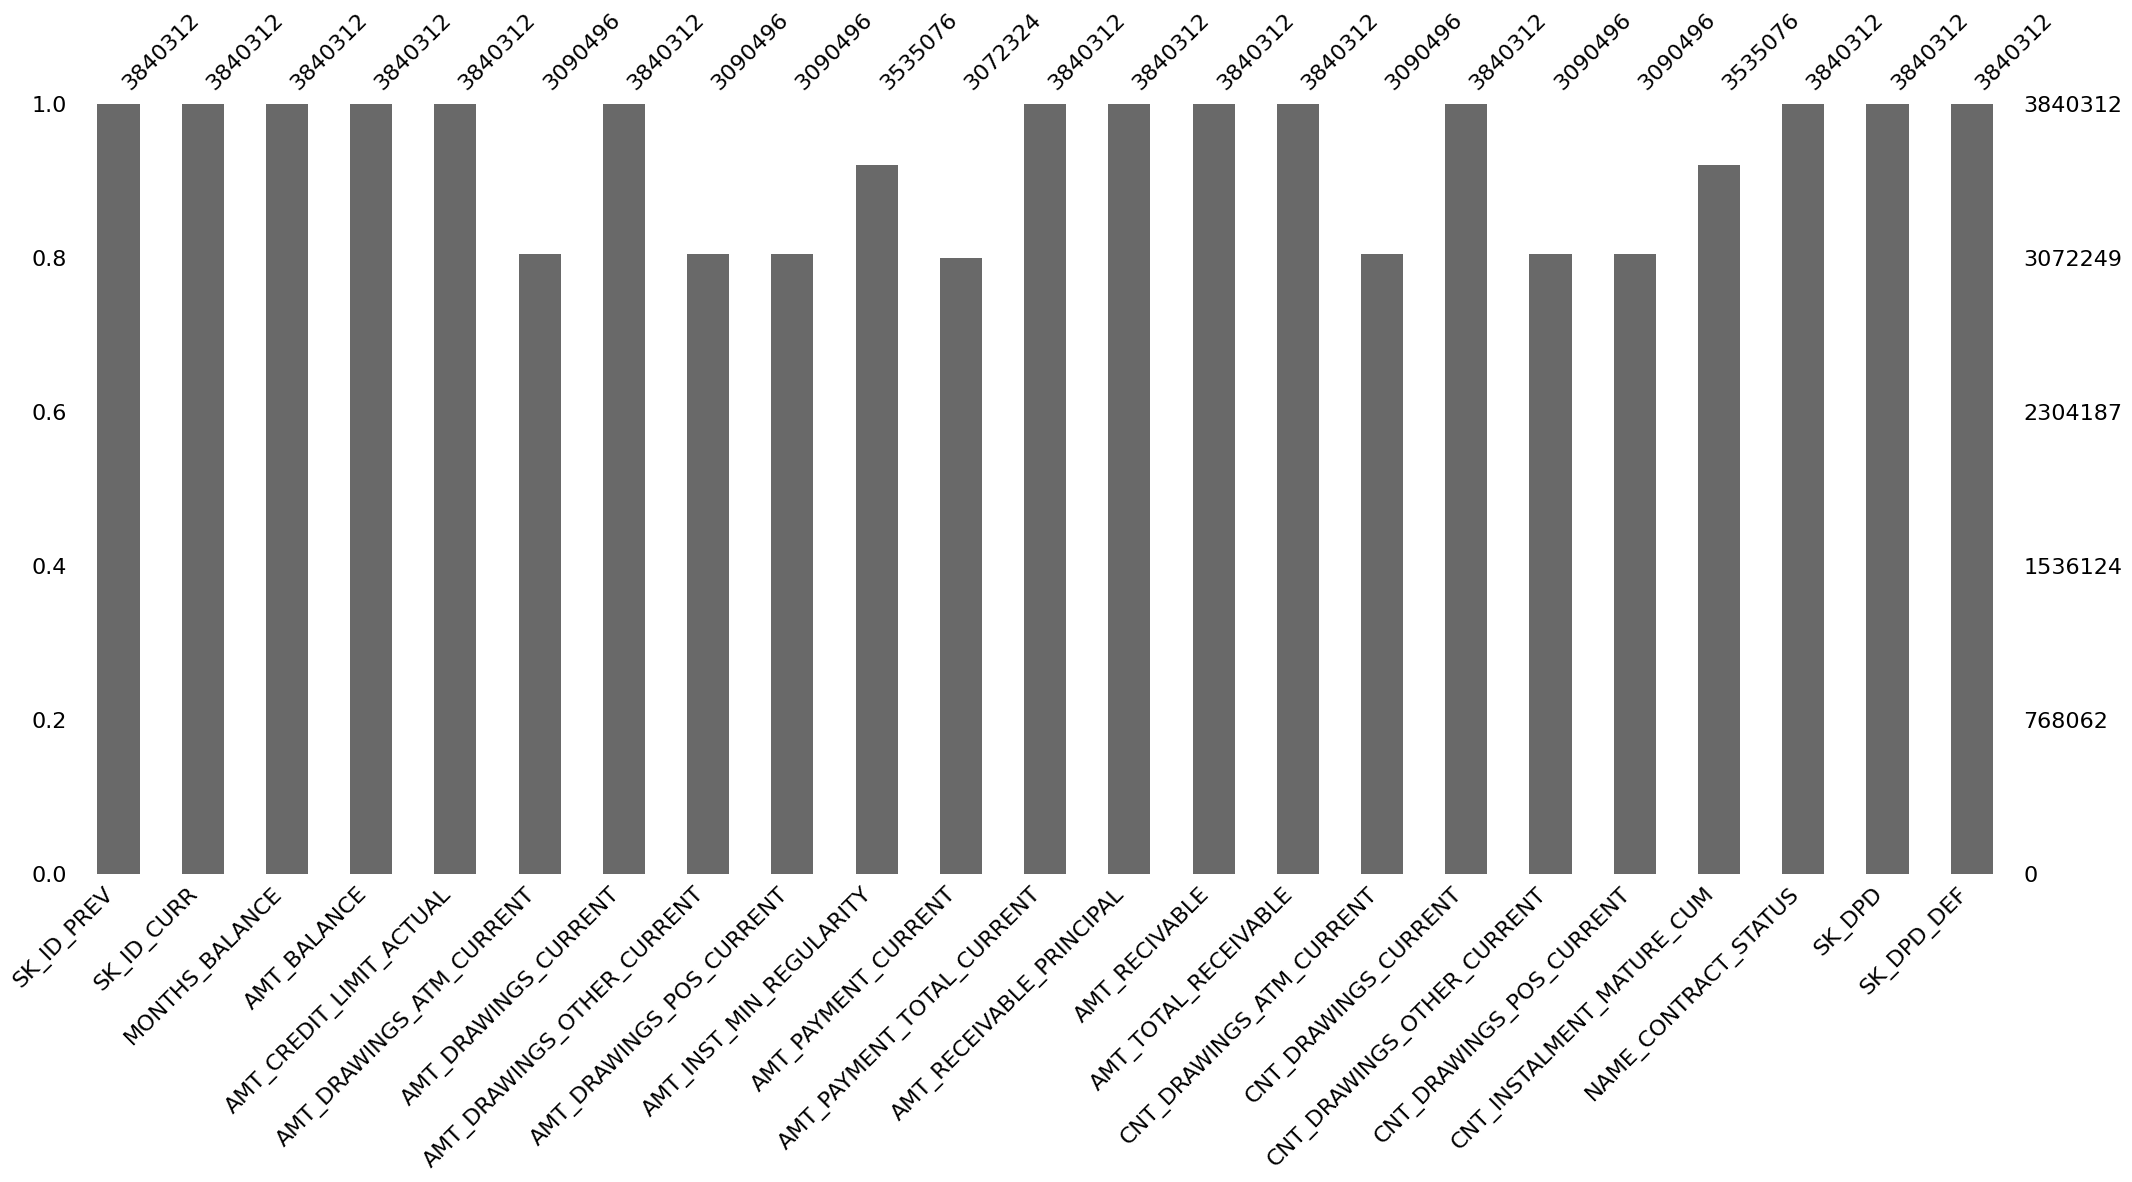

In [74]:
fonctions_data.description_dataset(credit_card_balance, 'credit_card_balance data')

<Axes: title={'center': 'Répartition des types de colonnes'}>

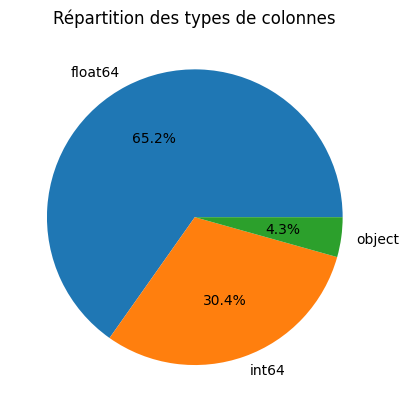

In [75]:
# Types des variables
credit_card_balance.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

In [414]:
credit_card_balance = fonctions_data.reduce_mem_usage(credit_card_balance, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 673.88 MB
Memory usage après optimization: 289.33 MB
Diminution de 57.1%
-------------------------------------------------------------------------------


<Axes: title={'center': 'Répartition des types de colonnes'}>

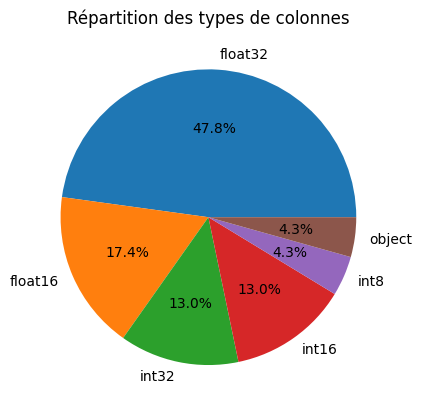

In [77]:
# Types des variables
credit_card_balance.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### <span style='background:Moccasin'>4.1.2. Valeurs aberrantes</span>

Lors de l'analyse exploratoire, nous avons constaté un outlier isolé pour la variable **AMT_PAYMENT_CURRENT** avec une valeur de 4289207.445, nous remplacerons cette valeur par np.nan.

**AMT_PAYMENT_CURRENT**

In [415]:
# Suppression des valeurs remontant à plus de 80 ans
credit_card_balance['AMT_PAYMENT_CURRENT'][credit_card_balance['AMT_PAYMENT_CURRENT']
                                  > 4000000] = np.nan

#### <span style='background:Moccasin'>4.1.3. Feature Engineering</span>

**Feature engineering**
- Création de nouvelles variables simples
- Catégorisation des variables binaires
- Imputation des valeurs manquantes
- Encodage des variables catégorielles
- Normalisation des variables numériques

In [416]:
# run functions and pre_settings
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

def do_sum(dataframe, group_cols, counted, agg_name):
    gp = dataframe[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted: agg_name})
    dataframe = dataframe.merge(gp, on=group_cols, how='left')
    return dataframe

In [417]:
def credit_card():    
    cc_balance = credit_card_balance

    cc_balance, cat_cols = one_hot_encoder(cc_balance, nan_as_category=True)

    # Somme : Montant retiré au guichet automatique pendant le mois du crédit
    #         précédent + Montant prélevé au cours du mois du crédit précédent
    #         + Montant des autres prélèvements au cours du mois du crédit
    #         précédent + Montant des prélèvements ou des achats de
    # marchandises au cours du mois de la crédibilité précédente.
    
    cc_balance['AMT_DRAWING_SUM'] = cc_balance['AMT_DRAWINGS_ATM_CURRENT'] \
        + cc_balance['AMT_DRAWINGS_CURRENT'] \
        + cc_balance['AMT_DRAWINGS_OTHER_CURRENT'] \
        + cc_balance['AMT_DRAWINGS_POS_CURRENT']
    
    # Somme : Nombre de retraits au guichet automatique durant ce mois sur
    #         le crédit précédent + Nombre de retraits pendant ce mois sur
    #         le crédit précédent + Nombre d'autres retraits au cours de
    #         ce mois sur le crédit précédent + Nombre de retraits de
    #         marchandises durant ce mois sur le crédit précédent +
    #         Nombre d'échéances payées sur le crédit précédent
    
    cc_balance['CNT_DRAWING_SUM'] = cc_balance['CNT_DRAWINGS_ATM_CURRENT'] \
        + cc_balance['CNT_DRAWINGS_CURRENT'] \
        + cc_balance['CNT_DRAWINGS_OTHER_CURRENT'] \
        + cc_balance['CNT_DRAWINGS_POS_CURRENT'] \
        + cc_balance['CNT_INSTALMENT_MATURE_CUM']
    
    # Ratio : Solde au cours du mois du crédit précédent \
    #         Limite de la carte de crédit au cours du mois du crédit précédent
    cc_balance['BALANCE_LIMIT_RATIO'] = cc_balance['AMT_BALANCE'] / \
        (cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
    
    # Ratio : Combien le client a-t-il payé pendant le mois sur le crédit
    #         précédent ? /
    #         Versement minimal pour ce mois du crédit précédent
    cc_balance['MIN_PAYMENT_RATIO'] = cc_balance['AMT_PAYMENT_CURRENT'] / \
        (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
    # Différence : Combien le client a-t-il payé pendant le mois sur le crédit
    #              précédent ?
    #              - Versement minimal pour ce mois du crédit précédent
    cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_CURRENT'] - \
        cc_balance['AMT_INST_MIN_REGULARITY']
    
    # Ratio : Combien le client a-t-il payé au total pendant le mois sur le
    #         crédit précédent ? /
    #         Versement minimal pour ce mois du crédit précédent
    cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = \
        cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] \
        / (cc_balance['AMT_INST_MIN_REGULARITY'] + 0.00001)
    # Différence : Combien le client a-t-il payé au total pendant le mois sur
    #              le crédit précédent ? -
    #              Versement minimal pour ce mois du crédit précédent
    cc_balance['PAYMENT_MIN_DIFF'] = cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] \
        - cc_balance['AMT_INST_MIN_REGULARITY']
    
    # Différence : Montant total à recevoir sur le crédit précédent -
    #              Montant à recevoir pour le principal du crédit précédent
    cc_balance['AMT_INTEREST_RECEIVABLE'] = cc_balance['AMT_TOTAL_RECEIVABLE'] \
        - cc_balance['AMT_RECEIVABLE_PRINCIPAL']
    
    # Ratio : DPD (jours de retard) au cours du mois sur le crédit précédent \
    #         DPD (Days past due) au cours du mois avec tolérance (les dettes
    #         avec de faibles montants de prêt sont ignorées) du crédit
    #         précédent
    cc_balance['SK_DPD_RATIO'] = cc_balance['SK_DPD'] / \
        (cc_balance['SK_DPD_DEF'] + 0.00001)

    # General aggregations
    cc_balance_agg = cc_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_balance_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_balance_agg.columns.tolist()])

    # Count credit card lines
    cc_balance_agg['CC_COUNT'] = cc_balance.groupby('SK_ID_CURR').size()

    # Last month balance of each credit card application
    last_ids = cc_balance.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc_balance[cc_balance.index.isin(last_ids)]
    cc_balance_agg = group_and_merge(last_months_df,cc_balance_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})


    CREDIT_CARD_TIME_AGG = {'MONTHS_BALANCE': ['max'],
                'AMT_BALANCE' : ['sum', 'mean', 'max'],
                'AMT_CREDIT_LIMIT_ACTUAL' : ['sum', 'mean', 'max'],
                'AMT_DRAWINGS_ATM_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_OTHER_CURRENT' : ['sum', 'max'],
                'AMT_DRAWINGS_POS_CURRENT' : ['sum', 'max'],
                'AMT_INST_MIN_REGULARITY' : ['mean', 'min', 'max'],
                'AMT_PAYMENT_CURRENT' : ['mean', 'min', 'max'],
                'AMT_PAYMENT_TOTAL_CURRENT' : ['mean', 'min', 'max'],
                'AMT_RECEIVABLE_PRINCIPAL' : ['sum', 'mean', 'max'],
                'AMT_RECIVABLE' : ['sum', 'mean', 'max'],
                'AMT_TOTAL_RECEIVABLE' : ['sum', 'mean', 'max'],
                'CNT_DRAWINGS_ATM_CURRENT' : ['sum', 'max', 'mean'],
                'CNT_DRAWINGS_CURRENT' : ['sum', 'max', 'mean'],
                'CNT_DRAWINGS_OTHER_CURRENT' : ['sum', 'max'],
                'CNT_DRAWINGS_POS_CURRENT' : ['sum', 'max'],
                'CNT_INSTALMENT_MATURE_CUM' : ['sum', 'max', 'min'],
                'SK_DPD' : ['sum', 'max'],
                'SK_DPD_DEF' : ['sum', 'max'],
                # Nouvelles Features
                'AMT_DRAWING_SUM' : ['sum', 'max'],
                'BALANCE_LIMIT_RATIO' : ['mean', 'max', 'min'],
                'CNT_DRAWING_SUM' : ['sum', 'max'],
                'MIN_PAYMENT_RATIO': ['min', 'mean'],
                'PAYMENT_MIN_DIFF' : ['min', 'mean'],
                'MIN_PAYMENT_TOTAL_RATIO' : ['min', 'mean'], 
                'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
                'SK_DPD_RATIO' : ['max','mean']}
    

    for months in [12, 24, 48]:
        cc_balance_prev_id = cc_balance[cc_balance['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_balance_recent = cc_balance[cc_balance['SK_ID_PREV'].isin(cc_balance_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_balance_agg = group_and_merge(cc_balance_recent, cc_balance_agg, prefix, CREDIT_CARD_TIME_AGG)

    cc_balance_agg.set_index('SK_ID_CURR',inplace = True)
    print('"Credit Card Balance" final shape:', cc_balance_agg.shape)
    return cc_balance_agg

In [418]:
credit_balance_fe = credit_card()

"Credit Card Balance" final shape: (103558, 389)


In [419]:
credit_balance_fe.head()

CC_SK_ID_PREV_MIN  CC_SK_ID_PREV_MAX  CC_SK_ID_PREV_MEAN  \
SK_ID_CURR                                                             
100006                1489396            1489396           1489396.0   
100011                1843384            1843384           1843384.0   
100013                2038692            2038692           2038692.0   
100021                2594025            2594025           2594025.0   
100023                1499902            1499902           1499902.0   

            CC_SK_ID_PREV_SUM  CC_SK_ID_PREV_VAR  CC_MONTHS_BALANCE_MIN  \
SK_ID_CURR                                                                
100006                8936376                0.0                     -6   
100011              136410416                0.0                    -75   
100013              195714432                0.0                    -96   
100021               44098425                0.0                    -18   
100023               11999216                0.0                    -11   

            CC_MONTHS_BALANCE_MAX  CC_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                  
100006                         -1                    -3.5   
100011                         -2                   -38.5   
100013                         -1                   -48.5   
100021                         -2                   -10.0   
100023                         -4                    -7.5   

            CC_MONTHS_BALANCE_SUM  CC_MONTHS_BALANCE_VAR  ...  \
SK_ID_CURR                                                ...   
100006                        -21                    3.5  ...   
100011                      -2849                  462.5  ...   
100013                      -4656                  776.0  ...   
100021                       -170                   25.5  ...   
100023                        -60                    6.0  ...   

            INS_48M_MIN_PAYMENT_RATIO_MIN  INS_48M_MIN_PAYMENT_RATIO_MEAN  \
SK_ID_CURR                                                                  
100006                                NaN                             NaN   
100011                                1.0                    3.086877e+06   
100013                                0.0                    2.652498e+06   
100021                                NaN                             NaN   
100023                                NaN                             NaN   

            INS_48M_PAYMENT_MIN_DIFF_MIN  INS_48M_PAYMENT_MIN_DIFF_MEAN  \
SK_ID_CURR                                                                
100006                          0.000000                       0.000000   
100011                       -804.195007                     625.764465   
100013                      -7875.000000                    5898.814453   
100021                          0.000000                       0.000000   
100023                          0.000000                       0.000000   

            INS_48M_MIN_PAYMENT_TOTAL_RATIO_MIN  \
SK_ID_CURR                                        
100006                                      0.0   
100011                                      0.0   
100013                                      0.0   
100021                                      0.0   
100023                                      0.0   

            INS_48M_MIN_PAYMENT_TOTAL_RATIO_MEAN  \
SK_ID_CURR                                         
100006                                  0.000000   
100011                                  0.509110   
100013                                  0.933759   
100021                                  0.000000   
100023                                  0.000000   

            INS_48M_AMT_INTEREST_RECEIVABLE_MIN  \
SK_ID_CURR                                        
100006                                 0.000000   
100011                              -563.354980   
100013                              -274.320007   
100021                                 0.000000   
10

#### <span style='background:Moccasin'>4.1.4. Assemblage avec le 'train set'</span>

In [420]:
features_set = features_set.merge(credit_balance_fe, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with bureau:', features_set.shape)

--=> features_set after merge with bureau: (307507, 648)


In [73]:
# Description
fonctions_data.detail_type_var(features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float64     float64      float64         float64   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count            307507.0    307507.0     307507.0        307507.0   
mean             0.095201    0.341648     0.659894        0.306331   
std              0.293493    0.474263     0.473745         0.46097   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          1.0             0.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE  \
type        float64          float64    float64     float64         float64   
nb_nan          0.0              0.0        0.0         0.0             0.0   
%_nan           0.0              0.0        0.0         0.0             0.0   
count      307507.0         307507.0   307507.0    307507.0        307507.0   
mean        0.02195         0.001224   0.138334    0.099423         0.12416   
std        0.038006         0.002027   0.100498    0.056525        0.092104   
min             0.0              0.0        0.0         0.0             0.0   
25%             0.0         0.000742    0.05618    0.058143        0.049383   
50%             0.0         0.001039   0.116987    0.090821        0.102132   
75%        0.052632         0.001512   0.190674    0.128624        0.159371   
max             1.0              1.0        1.0         1.0             1.0   

       REGION_POPULATION_RELATIVE  ... INS_48M_MIN_PAYMENT_RATIO_MIN  \
type                      float64  ...                       float64   
nb_nan                        0.0  ...                      246447.0   
%_nan                         0.0  ...                     80.143541   
count                    307507.0  ...                       61060.0   
mean                     0.284956  ...                2705629.031684   
std                      0.191546  ...               93709818.130003   
min                           0.0  ...                           0.0   
25%                      0.134587  ...                           0.0   
50%                       0.25692  ...                           0.0   
75%                      0.392774  ...                      1.000006   
max                           1.0  ...                 11250000000.0   

       INS_48M_MIN_PAYMENT_RATIO_MEAN INS_48M_PAYMENT_MIN_DIFF_MIN  \
type                          float64                      float64   
nb_nan                       246447.0                     220602.0   
%_nan                       80.143541                    71.738855   
count                         61060.0                      86905.0   
mean                  23072809.593884                 -3196.788393   
std                  136183962.652503                  9235.188731   
min                               0.0                  -202882.005   
25%                          6.005293                      -4500.0   
50%                    1137619.993279                          0.0   
75%                    9435553.482729                          0.0   
max                     11250000000.0                    1125000.0   

       INS_48M_PAYMENT_MIN_DIFF_MEAN INS_48M_MIN_PAYMENT_TOTAL_RATIO_MIN  \
type                         float64                             float64   
nb_nan                      220602.0                            220602.0   
%_nan                      71.738855                           71.738855   
count                        86905.0                             86905.0   
mean                     6986.203381                      9608338.125711   
std                     20360.190453                   

#### <span style='background:Moccasin'>4.1.2. Assemblage avec le 'test set'</span>

In [421]:
test_features_set = test_features_set.merge(credit_balance_fe, how='left', on='SK_ID_CURR')
print('--=> test_features_set after merge with bureau:', test_features_set.shape)

--=> test_features_set after merge with bureau: (48744, 647)


In [94]:
# Description
fonctions_data.detail_type_var(test_features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float64     float64      float64         float64   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count             48744.0     48744.0      48744.0         48744.0   
mean             0.009006      0.3296     0.337129        0.690505   
std              0.094474    0.470073     0.472734         0.46229   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          0.0             1.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY AMT_GOODS_PRICE  \
type        float64          float64    float64     float64         float64   
nb_nan          0.0              0.0        0.0         0.0             0.0   
%_nan           0.0              0.0        0.0         0.0             0.0   
count       48744.0          48744.0    48744.0     48744.0         48744.0   
mean       0.020898         0.001306   0.117788    0.108453         0.10528   
std        0.037318         0.000868   0.091235     0.06245        0.083978   
min             0.0         0.000011        0.0     0.00265        0.001122   
25%             0.0         0.000742   0.053843    0.063794        0.046016   
50%             0.0         0.001127   0.101124    0.095858        0.088664   
75%        0.052632         0.001704   0.157303    0.139523        0.147026   
max        1.052632         0.037481   0.549438    0.697947        0.549944   

       REGION_POPULATION_RELATIVE  ... INS_48M_MIN_PAYMENT_RATIO_MIN  \
type                      float64  ...                       float64   
nb_nan                        0.0  ...                       37684.0   
%_nan                         0.0  ...                     77.310028   
count                     48744.0  ...                       11060.0   
mean                     0.289889  ...                2125708.797266   
std                      0.199782  ...               59839235.046696   
min                     -0.000511  ...                           0.0   
25%                      0.134535  ...                           0.0   
50%                      0.256994  ...                           0.0   
75%                      0.392871  ...                      1.000146   
max                      0.999976  ...                  4500000000.0   

       INS_48M_MIN_PAYMENT_RATIO_MEAN INS_48M_PAYMENT_MIN_DIFF_MIN  \
type                          float64                      float32   
nb_nan                        37684.0                      32091.0   
%_nan                       77.310028                    65.835795   
count                         11060.0                      16653.0   
mean                  22098590.258736                 -2877.247314   
std                  111880048.881242                 10842.174805   
min                               0.0                 -194198.3125   
25%                         13.188575                 -3460.320068   
50%                    1508608.164161                          0.0   
75%                   11254644.706702                          0.0   
max                 6493790599.055676                 1014211.8125   

       INS_48M_PAYMENT_MIN_DIFF_MEAN INS_48M_MIN_PAYMENT_TOTAL_RATIO_MIN  \
type                         float32                             float64   
nb_nan                       32091.0                             32091.0   
%_nan                      65.835795                           65.835795   
count                        16653.0                             16653.0   
mean                     6347.315918                      4668385.418443   
std                     21571.845703                   

#### <span style='background:Moccasin'>4.1.3. Nettoyage</span>

Au vu du nombre déjà élevé de variables, nous allons gérer la suppression des variables fortement colinéaires et l'imputation au fur et à mesure plutôt que de le faire après avoir mergé toutes les données. 

<span style='background:mistyrose'>**Réduction mémoire des dataframes**</span>

In [422]:
features_set = fonctions_data.reduce_mem_usage(features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 1220.85 MB
Memory usage après optimization: 525.23 MB
Diminution de 57.0%
-------------------------------------------------------------------------------


In [423]:
test_features_set = fonctions_data.reduce_mem_usage(test_features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 193.47 MB
Memory usage après optimization: 82.74 MB
Diminution de 57.2%
-------------------------------------------------------------------------------


<span style='background:mistyrose'>**Variables fortement corrélées**</span>

In [426]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_features_set = fonctions_data.suppr_var_colineaire(features_set)

354 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
PROPORTION_LIFE_EMPLOYED
INCOME_TO_ANNUITY_RATIO
INCOME_TO_ANNUITY_RATIO_BY_AGE
CREDIT_TO_ANNUITY_RATIO_BY_AGE
INCOME_TO_FAMILYSIZE_RATIO
NAME_INCOME_TYPE_Pensioner
NAME_EDUCATION_TYPE_Secondarysecondaryspecial
ORGANIZATION_TYPE_XNA
FONDKAPREMONT_MODE_nan
HOUSETYPE_MOD

In [427]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_test_features_set = fonctions_data.suppr_var_colineaire(test_features_set)

355 variables fortement corrélées à supprimer :

AMT_GOODS_PRICE
CNT_FAM_MEMBERS
LIVE_REGION_NOT_WORK_REGION
LIVE_CITY_NOT_WORK_CITY
ELEVATORS_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
TOTALAREA_MODE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
DAYS_EMPLOYED_ANOM
PROPORTION_LIFE_EMPLOYED
INCOME_TO_ANNUITY_RATIO
INCOME_TO_ANNUITY_RATIO_BY_AGE
CREDIT_TO_ANNUITY_RATIO_BY_AGE
NAME_INCOME_TYPE_Pensioner
NAME_EDUCATION_TYPE_Secondarysecondaryspecial
ORGANIZATION_TYPE_XNA
FONDKAPREMONT_MODE_nan
HOUSETYPE_MODE_BLOCKO

***Train set***

In [428]:
# Suppression des variables fortement corrélées du train set
features_set = features_set.drop(columns = var_corr_features_set)
print(f'train_set : {features_set.shape}')

train_set : (307507, 294)


***Test set***

In [429]:
# Suppression des variables fortement corrélées du test set
test_features_set = test_features_set.drop(columns = var_corr_test_features_set)
print(f'test_set : {test_features_set.shape}')

test_set : (48744, 292)


<span style='background:mistyrose'>**Imputation des données**</span>

***Train set***

Valeurs manquantes :19181746 NaN pour 90407058 données (21.22 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
CC_MIN_PAYMENT_RATIO_VAR                                    246888   
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR                           246814   
CC_CNT_DRAWINGS_ATM_CURRENT_VAR                             246814   
CC_AMT_DRAWINGS_ATM_CURRENT_VAR                             246814   
CC_AMT_DRAWINGS_POS_CURRENT_VAR                             246814   
...                                                            ...   
CC_SK_DPD_DEF_MAX                                           220602   
CC_NAME_CONTRACT_STATUS_Active_MIN                          220602   
CC_NAME_CONTRACT_STATUS_Active_MAX                          220602   
CC_NAME_CONTRACT_STATUS_Active_MEAN                         220602   
CC_SK_DPD_RATIO_MIN                                         220602   

                                     % de valeurs manquantes  
CC_MIN_PAYMENT_RATIO_VAR                               80.29  
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR                      80.26  
CC_CNT_DRAWINGS_ATM_CURRENT_VAR                        80.26  
CC_AMT_DRAWINGS_ATM_CURRENT_VAR                        80.26  
CC_AMT_DRAWINGS_POS_CURRENT_VAR                        80.26  
...                                                      ...  
CC_SK_DPD_DEF_MAX                                      71.74  
CC_NAME_CONTRACT_STATUS_Active_MIN                     71.74  
CC_NAME_CONTRACT_STATUS_Active_MAX                     71.74  
CC_NAME_CONTRACT_STATUS_Active_MEAN                    71.74  
CC_SK_DPD_RATIO_MIN                                    71.74  

[84 rows x 2 columns]

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


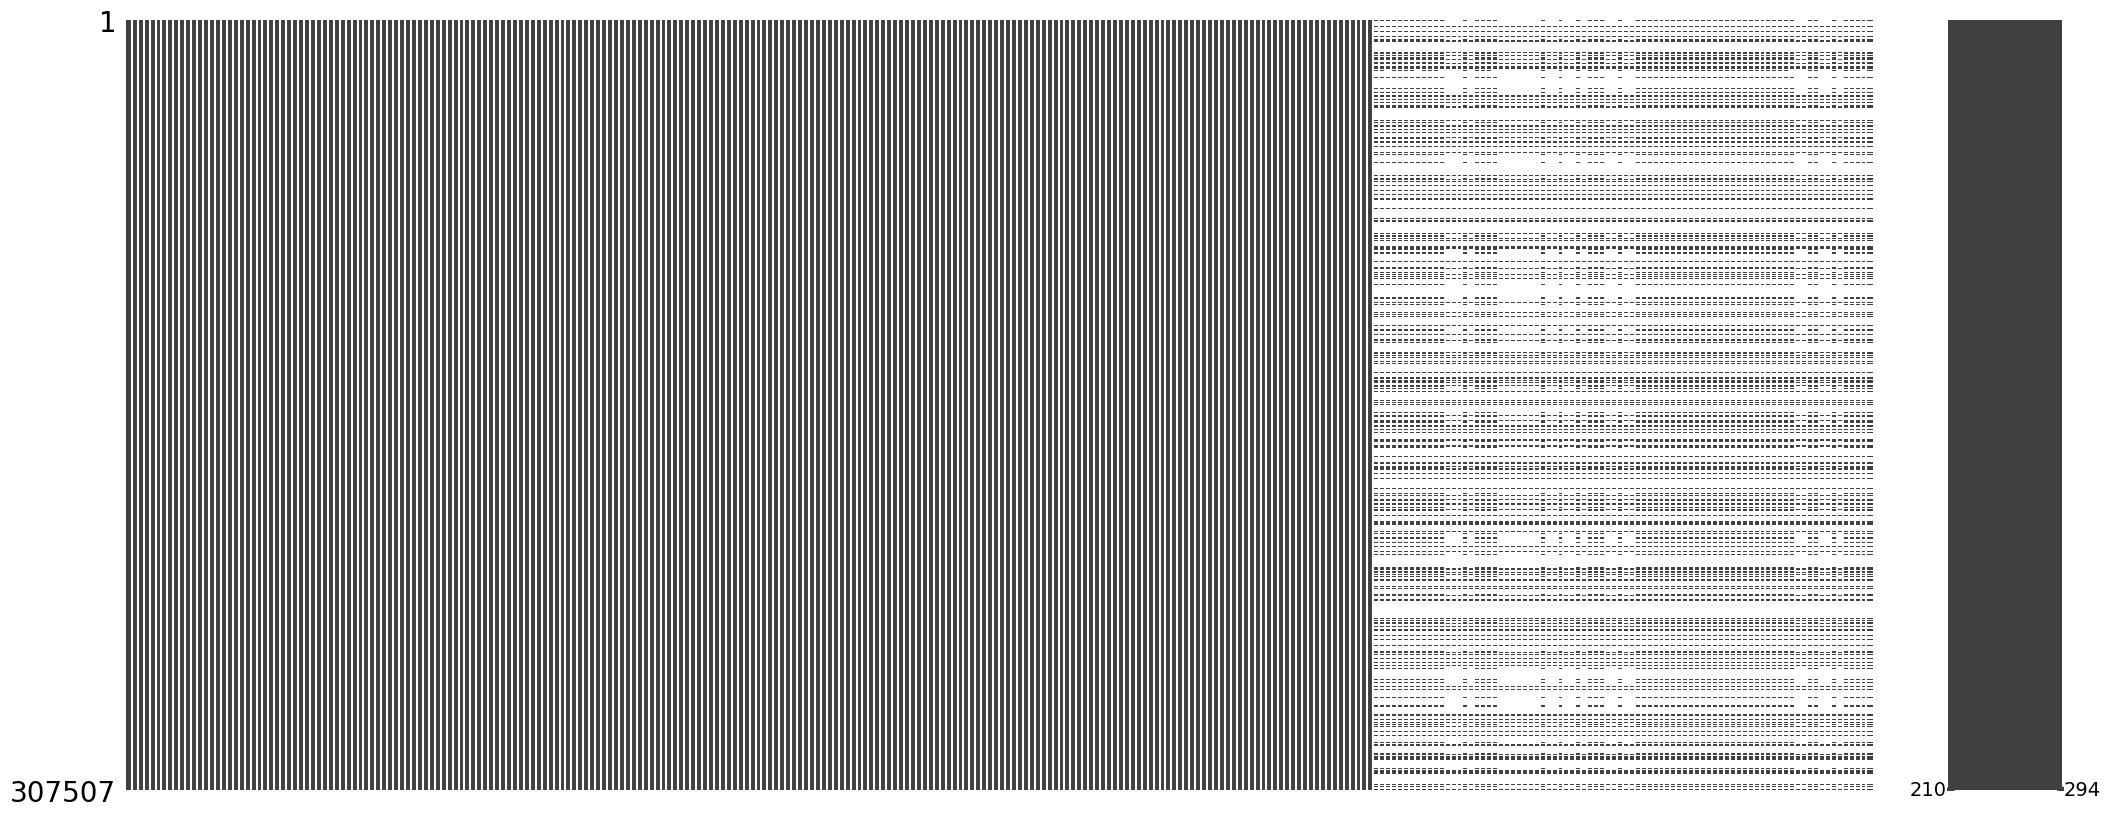

In [84]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

Ce graphique nous présente bien une forte présence de valeurs manquantes. Nous allons prendre la décision de partir sur une imputaton à travers la méthode du NanImputer, suppression par la moyenne, des valeurs nulles.

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [430]:
# Supprimer les colonnes avec uniquement des NaN
nb_nan = features_set.isna().sum().sum()
print(f'Nombre de nan  avant suppression des NaN : {nb_nan}')
features_set = features_set.dropna(axis=1, how='all')
# Vérification
nb_nan = features_set.isna().sum().sum()
print(f'Nombre de nan après suppression des NaN : {nb_nan}')

Nombre de nan  avant suppression des NaN : 19181746
Nombre de nan après suppression des NaN : 19181746


**Imputation par median** 

In [431]:
# Variables quantitatives - imputation par médiane
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
features_set.fillna(features_set.median(), inplace=True)

# Vérification
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 19181746
Nombre de nan après imputation par median : 0


In [432]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = features_set.columns[(features_set == 0).all()]
colonnes_nulles

Index(['DAYS_EMPLOYED_ANOM', 'NAME_TYPE_SUITE_nan', 'NAME_EDUCATION_TYPE_nan',
       'NAME_FAMILY_STATUS_nan', 'NAME_HOUSING_TYPE_nan',
       'OCCUPATION_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_nan',
       'ORGANIZATION_TYPE_nan', 'HOUSETYPE_MODE_nan', 'WALLSMATERIAL_MODE_nan',
       'CC_SK_DPD_MIN', 'CC_SK_DPD_DEF_MIN',
       'CC_NAME_CONTRACT_STATUS_Approved_MIN',
       'CC_NAME_CONTRACT_STATUS_Demand_MIN',
       'CC_NAME_CONTRACT_STATUS_Refused_MIN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MAX',
       'CC_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRACT_STATUS_nan_SUM',
       'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_SK_DPD_RATIO_MIN'],
      dtype='object')

In [433]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
features_set = features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = features_set.columns[(features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 22
Nombre de champs nulles après imputation: 0


**Imputation avec NaNIMputer (Verstack)**

In [86]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = features_set.isna().sum().sum()

In [87]:
# Copie du jeu de données
X_nan = features_set.copy()

In [89]:
# !pip install verstack pour l'installation
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)

In [144]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_imp2_set = df_tmp_nan

Nombre de nan avant imputation par NaNImputer : 0


In [354]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

Valeurs manquantes :0 NaN pour 83641904 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


***Test set***

Valeurs manquantes :2804280 NaN pour 14233248 données (19.7 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
CC_AMT_PAYMENT_CURRENT_VAR                                     37761   
CC_CNT_DRAWINGS_ATM_CURRENT_VAR                                37745   
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR                              37745   
CC_AMT_DRAWINGS_ATM_CURRENT_VAR                                37745   
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN                               37690   
...                                                              ...   
CC_NAME_CONTRACT_STATUS_Active_MEAN                            32091   
CC_NAME_CONTRACT_STATUS_Approved_MIN                           32091   
CC_NAME_CONTRACT_STATUS_Approved_MAX                           32091   
CC_NAME_CONTRACT_STATUS_Approved_MEAN                          32091   
CC_CNT_INSTALMENT_MATURE_CUM_MIN                               32091   

                                       % de valeurs manquantes  
CC_AMT_PAYMENT_CURRENT_VAR                               77.47  
CC_CNT_DRAWINGS_ATM_CURRENT_VAR                          77.44  
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR                        77.44  
CC_AMT_DRAWINGS_ATM_CURRENT_VAR                          77.44  
CC_AMT_DRAWINGS_ATM_CURRENT_MEAN                         77.32  
...                                                        ...  
CC_NAME_CONTRACT_STATUS_Active_MEAN                      65.84  
CC_NAME_CONTRACT_STATUS_Approved_MIN                     65.84  
CC_NAME_CONTRACT_STATUS_Approved_MAX                     65.84  
CC_NAME_CONTRACT_STATUS_Approved_MEAN                    65.84  
CC_CNT_INSTALMENT_MATURE_CUM_MIN                         65.84  

[83 rows x 2 columns]

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


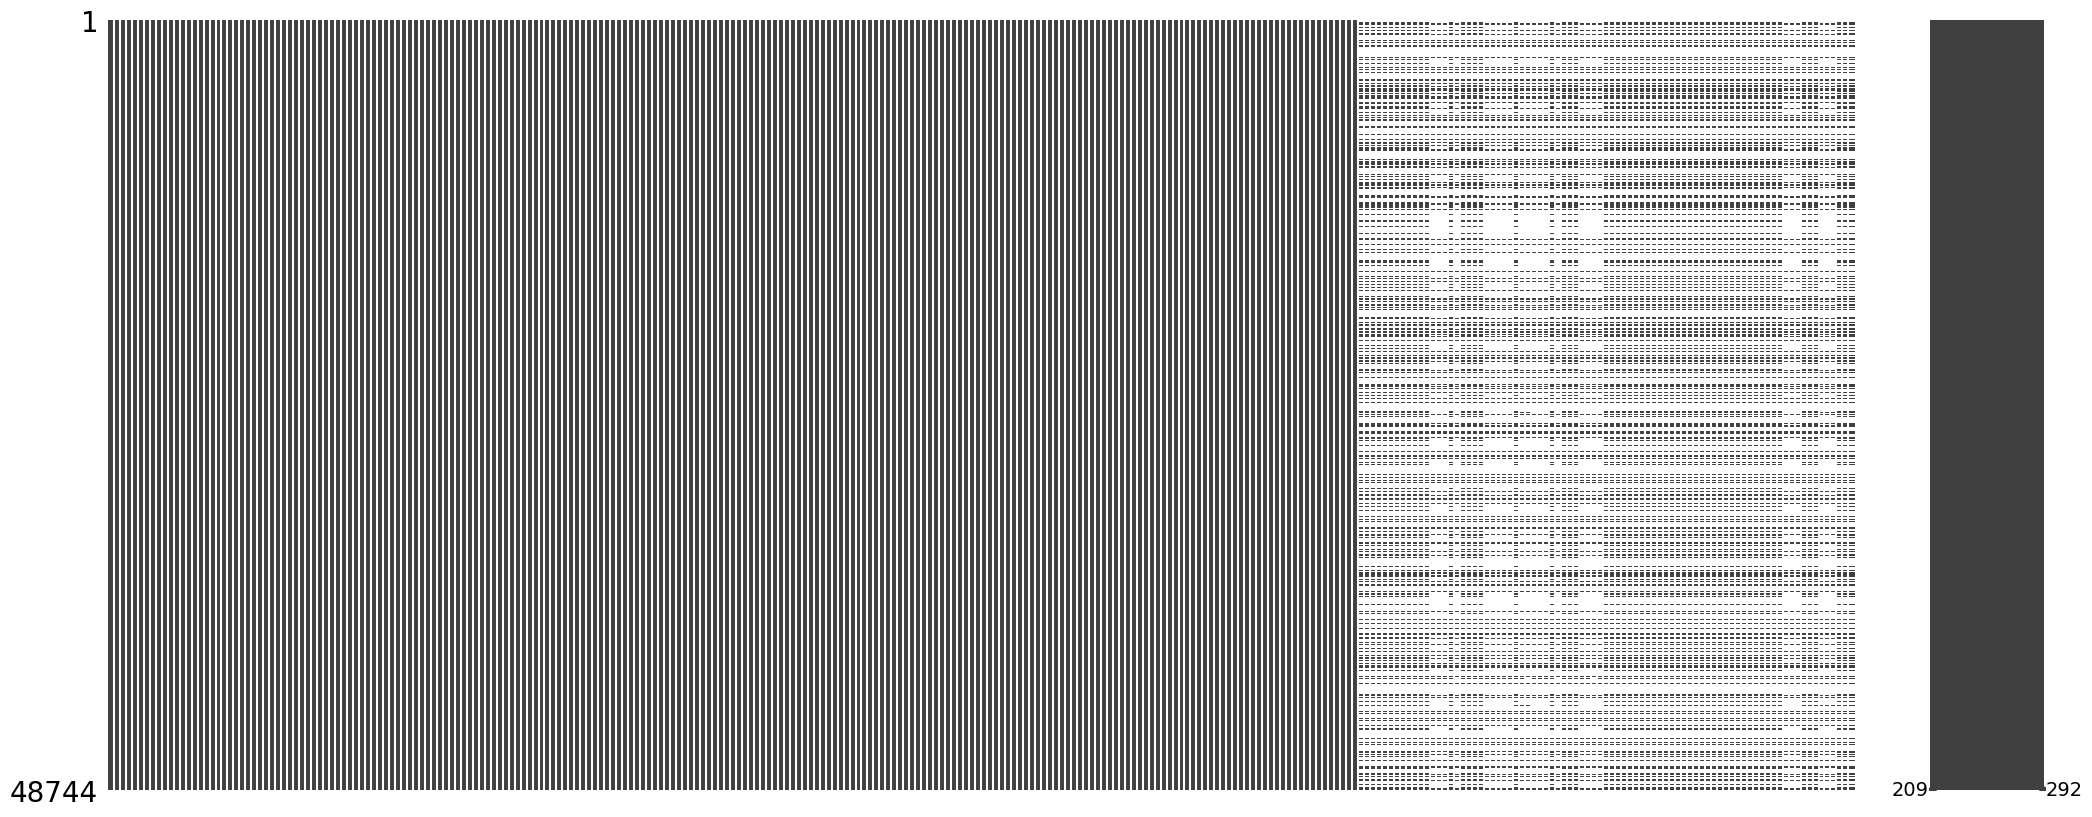

In [70]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [435]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
test_features_set = test_features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 2804280
Nombre de nan ou valeurs nulles après suppression des champs vierges : 2804280


**Imputation par median** 

In [436]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_features_set.fillna(test_features_set.median(), inplace=True)

# Vérification
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 2804280
Nombre de nan après imputation par median : 0


In [437]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
colonnes_nulles

Index(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'NAME_TYPE_SUITE_nan',
       'NAME_INCOME_TYPE_nan', 'NAME_EDUCATION_TYPE_nan',
       'NAME_FAMILY_STATUS_nan', 'NAME_HOUSING_TYPE_nan',
       'OCCUPATION_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_nan',
       'ORGANIZATION_TYPE_nan', 'HOUSETYPE_MODE_nan', 'WALLSMATERIAL_MODE_nan',
       'CC_NAME_CONTRACT_STATUS_Approved_MIN',
       'CC_NAME_CONTRACT_STATUS_Approved_MAX',
       'CC_NAME_CONTRACT_STATUS_Approved_MEAN',
       'CC_NAME_CONTRACT_STATUS_Approved_SUM',
       'CC_NAME_CONTRACT_STATUS_Approved_VAR',
       'CC_NAME_CONTRACT_STATUS_Refused_MIN',
       'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_MAX',
       'CC_NAME_CONTRACT_STATUS_nan_MEAN', 'CC_NAME_CONTRAC

In [438]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
test_features_set = test_features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 33
Nombre de champs nulles après imputation: 0


**Imputation avec NaNIMputer (Verstack)**

In [148]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features_set.isna().sum().sum()

In [149]:
# Copie du jeu de données
X_nan = test_features_set.copy()

In [150]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.10996 seconds


In [151]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


Valeurs manquantes :0 NaN pour 14281992 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


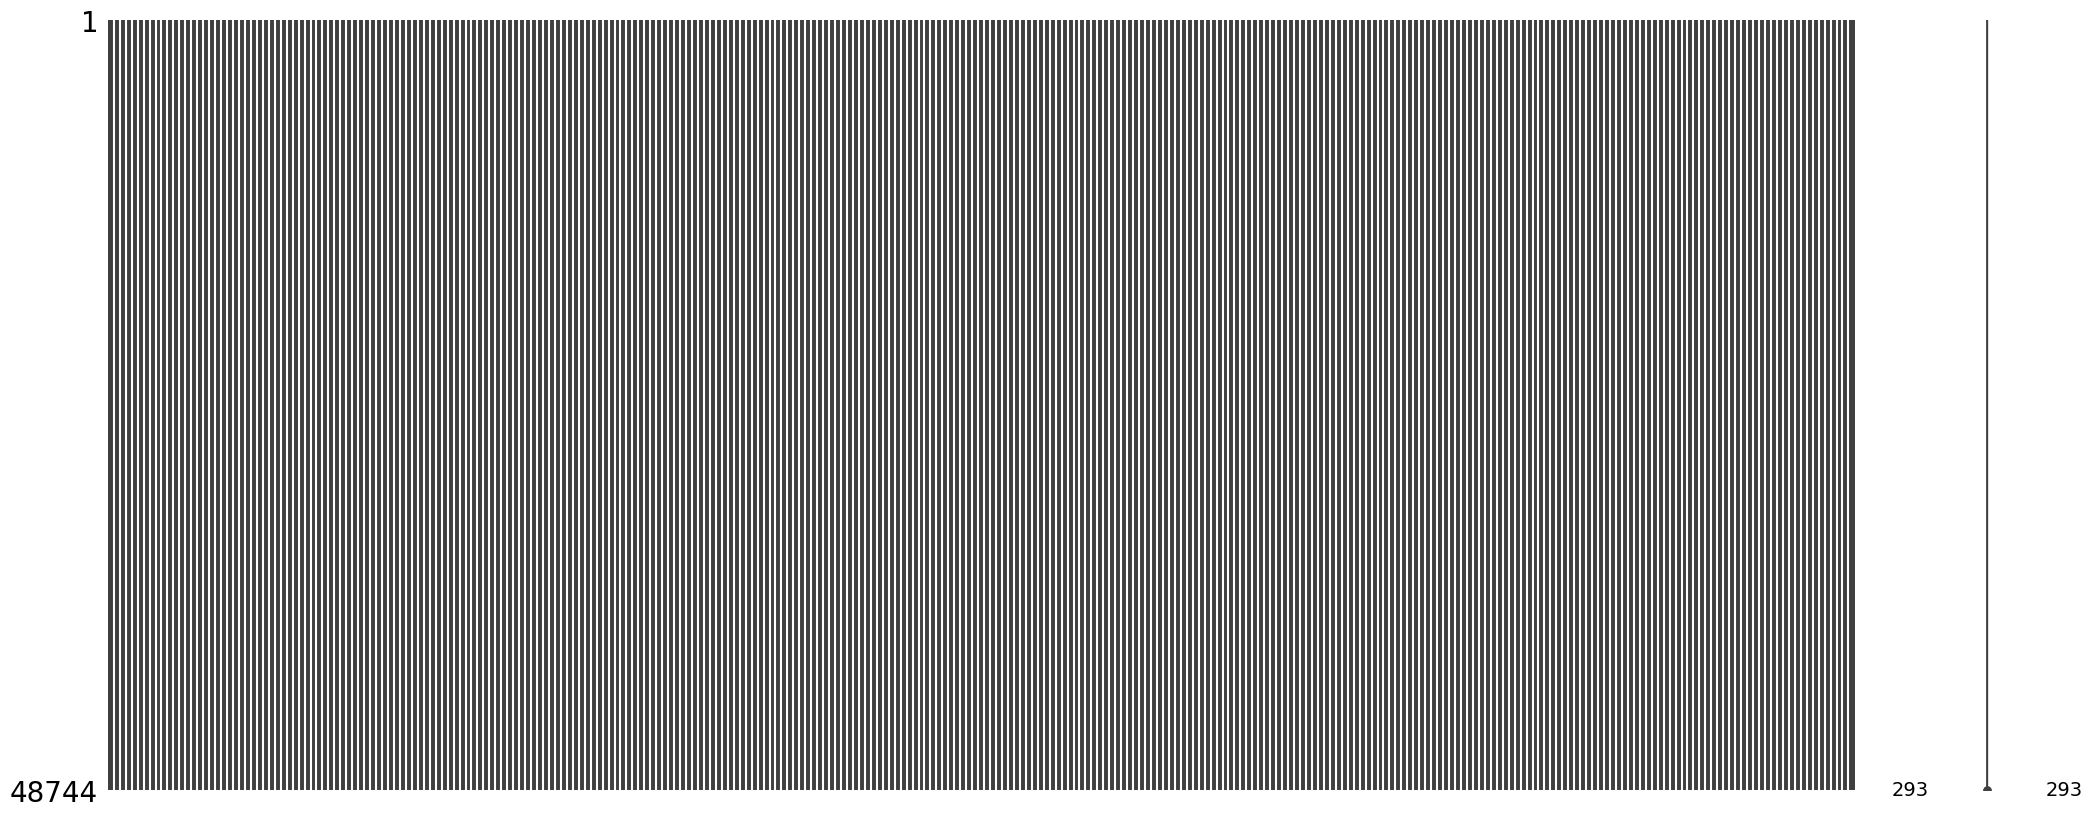

In [152]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

### <span style='background:orange'>4.2. Fichiers installments_payments.csv</span>

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon.</p> |  |
| <p style='text-align: justify;'>**NUM_INSTALMENT_VERSION**</p> | <p style='text-align: justify;'>Version du calendrier des versements du crédit précédent. Le changement de la version des versements d'un mois à l'autre signifie qu'un paramètre du calendrier de paiement a changé.</p> | 0 pour la carte de crédit |
| <p style='text-align: justify;'>**NUM_INSTALMENT_NUMBER**</p> | <p style='text-align: justify;'>Sur quel versement nous observons le paiement ?</p> |  |
| <p style='text-align: justify;'>**DAYS_INSTALMENT**</p> | <p style='text-align: justify;'>La date à laquelle le versement du crédit précédent était censé être payé (par rapport à la date de demande du prêt actuel).</p> |  |
| <p style='text-align: justify;'>**DAYS_ENTRY_PAYMENT**</p> | <p style='text-align: justify;'>Quand les échéances du crédit précédent ont-elles été effectivement payées (par rapport à la date de demande du prêt actuel) ?</p> |  |
| <p style='text-align: justify;'>**AMT_INSTALMENT**</p> | <p style='text-align: justify;'>Quel était le montant de l'acompte prescrit du crédit précédent sur cet acompte ?</p> |  |
| <p style='text-align: justify;'>**AMT_PAYMENT**</p> | <p style='text-align: justify;'>Ce que le client a effectivement payé sur le crédit précédent pour ce versement.</p> |  |

In [439]:
# Taille : nombre de lignes/colonnes
nRow, nVar = installment_payment.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 13605401 lignes et 8 variables.


In [440]:
# Variables quantitatives
cols_num_pay = installment_payment.select_dtypes(include=[np.number]) \
    .columns \
    .to_list()
cols_num_pay

['SK_ID_PREV',
 'SK_ID_CURR',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'DAYS_INSTALMENT',
 'DAYS_ENTRY_PAYMENT',
 'AMT_INSTALMENT',
 'AMT_PAYMENT']

In [441]:
# Variables catégorielles
cols_cat_pay = installment_payment.select_dtypes(exclude=[np.number]) \
    .columns \
    .to_list()
cols_cat_pay

[]

#### <span style='background:Moccasin'>4.2.1. Réduction de la mémoire d'usage de chaque dataframe</span>

On traite le dataset  installment_payment data


SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000

Taille :-------------------------------------------------------------- (13605401, 8)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Valeurs manquantes  % total des valeurs
DAYS_ENTRY_PAYMENT                2905                  0.0
AMT_PAYMENT                       2905                  0.0

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_PREV------------------------------------------------------------ contient 997752 valeurs différentes
SK_ID_CURR------------------------------------------------------------ contient 339587 valeurs différentes
NUM_INSTALMENT_VERSION------------------------------------------------ contient 65 valeurs différentes
NUM_INSTALMENT_NUMBER------------------------------------------------- contient 277 valeurs différentes
DAYS_INSTALMENT------------------------------------------------------- contient 2922 valeurs différentes
DAYS_ENTRY_PAYMENT---------------------------------------------------- contient 3039 valeurs différentes
AMT_INSTALMENT-------------------------------------------------------- contient 902539 valeurs différentes
AMT_PAYMENT----------------------------------------------------------- contient 944235 valeurs différentes
-----------------

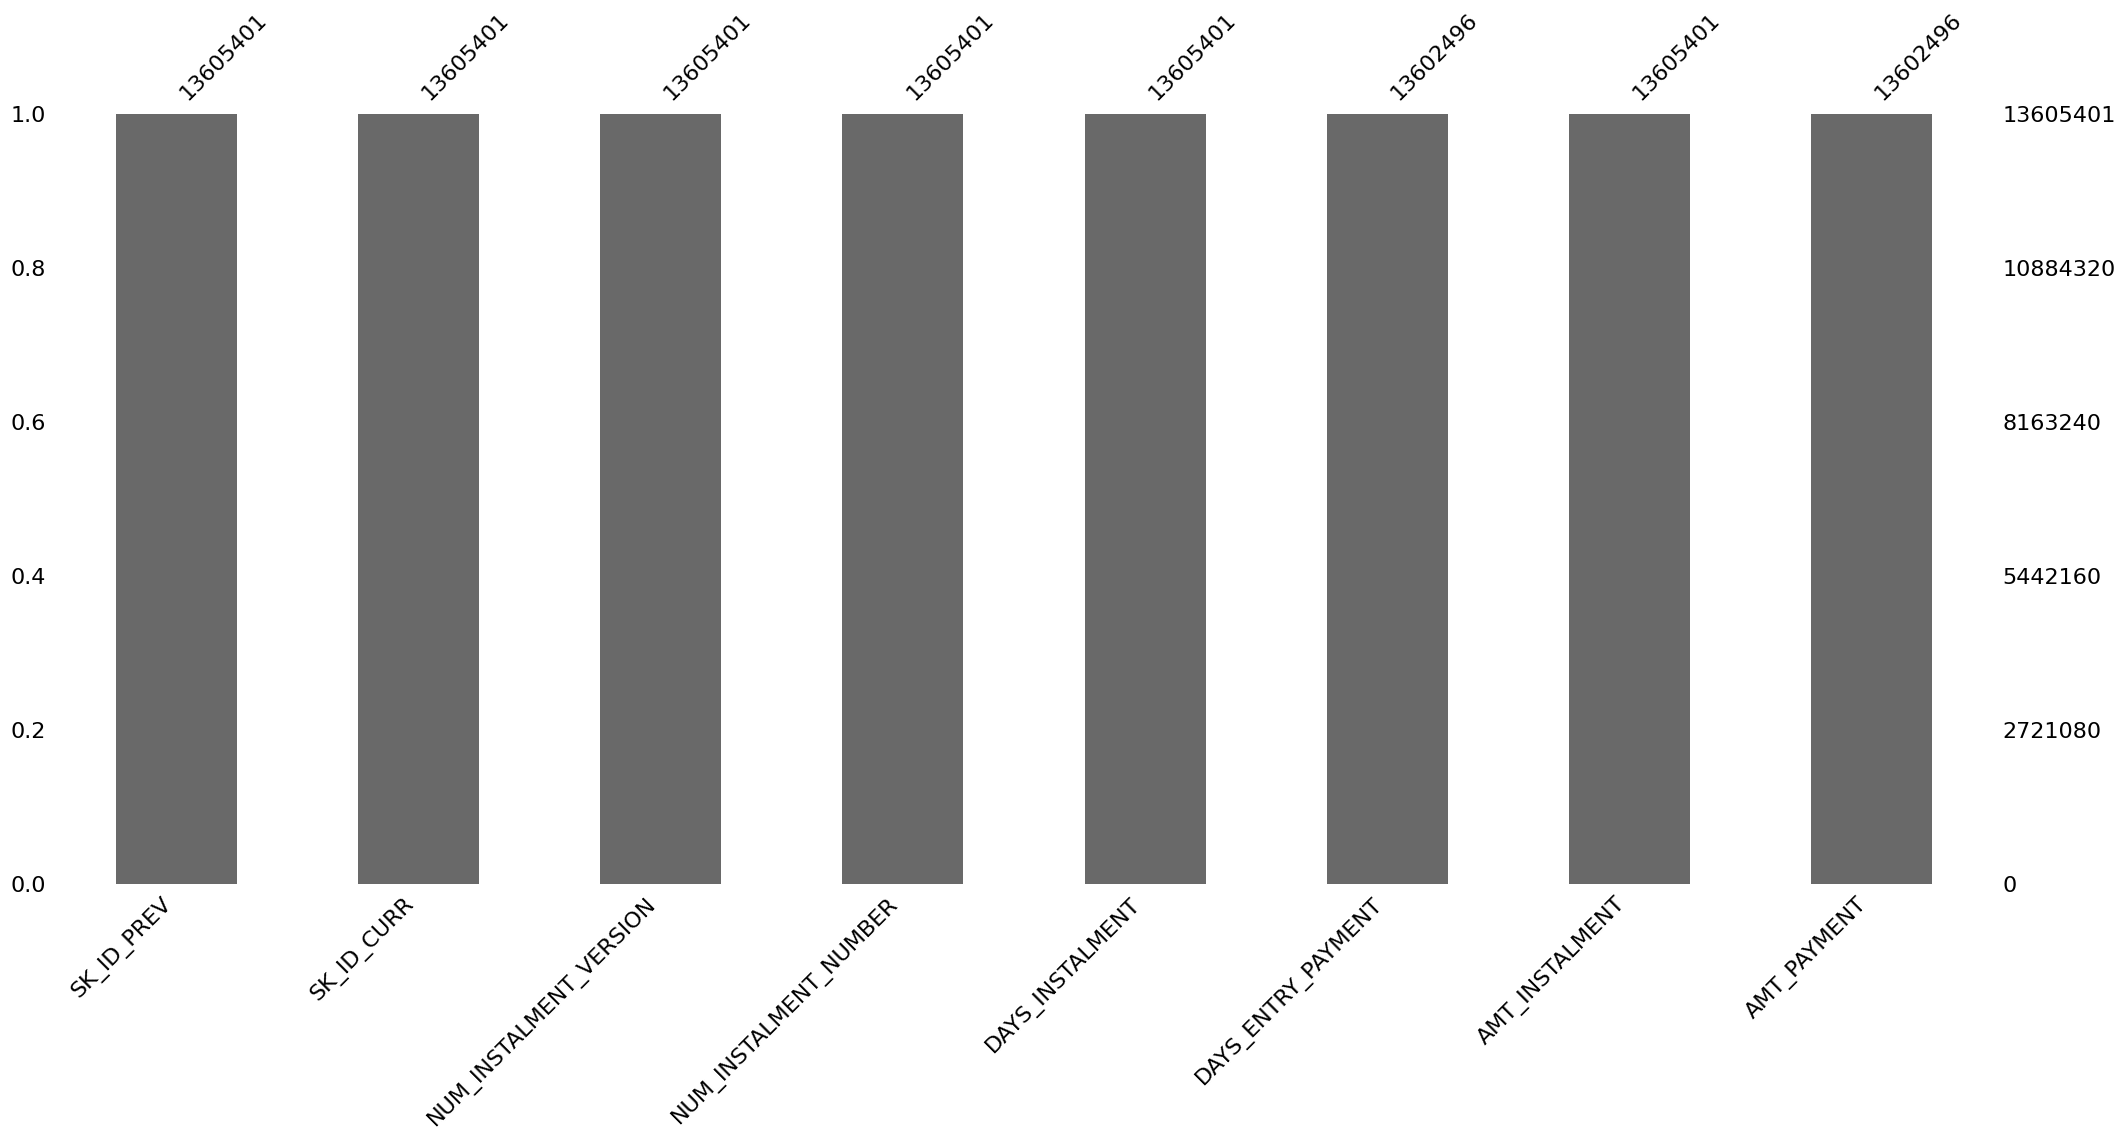

In [158]:
fonctions_data.description_dataset(installment_payment, 'installment_payment data')

<Axes: title={'center': 'Répartition des types de colonnes'}>

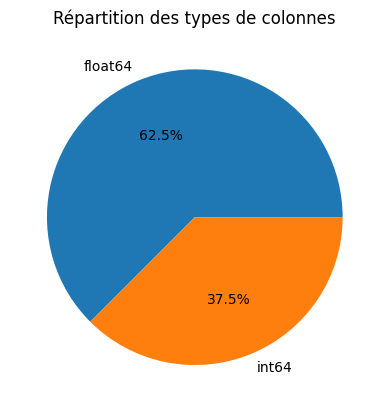

In [159]:
# Types des variables
installment_payment.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

In [442]:
installment_payment = fonctions_data.reduce_mem_usage(installment_payment, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 830.41 MB
Memory usage après optimization: 311.40 MB
Diminution de 62.5%
-------------------------------------------------------------------------------


In [162]:
# Types des variables
installment_payment.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

<Axes: title={'center': 'Répartition des types de colonnes'}>

#### <span style='background:Moccasin'>4.2.2. Feature Engineering</span>

**Feature engineering**
- Création de nouvelles variables simples
- Catégorisation des variables binaires
- Imputation des valeurs manquantes
- Encodage des variables catégorielles
- Normalisation des variables numériques

In [365]:
def installment():
    inst_pay = installment_payment

    inst_pay, cat_cols = one_hot_encoder(inst_pay, nan_as_category=True)

     # Ratio : La date à laquelle le versement du crédit précédent était censé
    #         être payé (par rapport à la date de demande du prêt actuel) \
    #         Quand les échéances du crédit précédent ont-elles été
    #         effectivement payées (par rapport à la date de demande du prêt
    #         actuel) ?
    inst_pay['DAYS_PAYMENT_RATIO'] = \
        inst_pay['DAYS_INSTALMENT'] / \
        (inst_pay['DAYS_ENTRY_PAYMENT'] + 0.00001)
    # Différence : La date à laquelle le versement du crédit précédent était
    #              censé être payé (par rapport à la date de demande du prêt
    #              actuel) - Quand les échéances du crédit précédent ont-elles
    #              été effectivement payées (par rapport à la date de demande
    #              du prêt actuel) ?
    inst_pay['DAYS_PAYMENT_DIFF'] = \
        inst_pay['DAYS_INSTALMENT'] - \
        inst_pay['DAYS_ENTRY_PAYMENT']
    
    # Ratio : Ce que le client a effectivement payé sur le crédit précédent
    #         pour ce versement \
    #         Quel était le montant de l'acompte prescrit du crédit précédent
    #         sur cet acompte ?
    inst_pay['AMT_PAYMENT_RATIO'] = \
        inst_pay['AMT_PAYMENT'] / \
        (inst_pay['AMT_INSTALMENT'] + 0.00001)
    # Différence : Quel était le montant de l'acompte prescrit du crédit
    #              précédent sur cet acompte ? -
    #              Ce que le client a effectivement payé sur le crédit
    #              précédent pour ce versement
    inst_pay['AMT_PAYMENT_DIFF'] = \
        inst_pay['AMT_INSTALMENT'] - \
        inst_pay['AMT_PAYMENT']
    
    # # Features: Perform aggregations

    dico_agg_pay= {'NUM_INSTALMENT_VERSION' : ['mean', 'sum'],
               'NUM_INSTALMENT_NUMBER' : ['max'],
               'DAYS_INSTALMENT' : ['max', 'min', 'mean'],
               'DAYS_ENTRY_PAYMENT' : ['max', 'min', 'mean'],
               'AMT_INSTALMENT' : ['mean', 'sum', 'min', 'max'],
               'AMT_PAYMENT' : ['mean', 'sum', 'min', 'max'],
               # Nouvelles Features
               'DAYS_PAYMENT_RATIO' : ['mean', 'min', 'max'],
               'DAYS_PAYMENT_DIFF' : ['mean', 'min', 'max'],
               'AMT_PAYMENT_RATIO' : ['mean', 'min', 'max'],
               'AMT_PAYMENT_DIFF' : ['mean', 'min', 'max']}

    for cat in cat_cols:
        dico_agg_pay[cat] = ['mean']
    ins_agg = inst_pay.groupby('SK_ID_CURR').agg(dico_agg_pay)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = inst_pay.groupby('SK_ID_CURR').size()

    # from oof (DAYS_ENTRY_PAYMENT)
    cond_day = inst_pay['DAYS_ENTRY_PAYMENT'] >= -365
    ins_d365_grp = inst_pay[cond_day].groupby('SK_ID_CURR')
    ins_d365_agg_dict = {
        'SK_ID_CURR': ['count'],
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DAYS_ENTRY_PAYMENT': ['mean', 'max', 'sum'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_PAYMENT': ['mean', 'max', 'sum'],
        'DAYS_PAYMENT_RATIO' : ['mean', 'min', 'max'],
        'DAYS_PAYMENT_DIFF' : ['mean', 'min', 'max'],
        'AMT_PAYMENT_RATIO' : ['mean', 'min', 'max'],
        'AMT_PAYMENT_DIFF' : ['mean', 'min', 'max']}
       

    ins_d365_agg = ins_d365_grp.agg(ins_d365_agg_dict)
    ins_d365_agg.columns = ['INS_D365' + ('_').join(column).upper() for column in ins_d365_agg.columns.ravel()]
    
    ins_agg = ins_agg.merge(ins_d365_agg, on='SK_ID_CURR', how='left')
    

    print('"Installments Payments" final shape:', ins_agg.shape)
    return ins_agg

In [443]:
installment_fe = installment()

"Installments Payments" final shape: (339587, 56)


In [444]:
installment_fe.head()

INSTAL_NUM_INSTALMENT_VERSION_MEAN  \
SK_ID_CURR                                       
100001                                1.142857   
100002                                1.052632   
100003                                1.040000   
100004                                1.333333   
100005                                1.111111   

            INSTAL_NUM_INSTALMENT_VERSION_SUM  \
SK_ID_CURR                                      
100001                                    8.0   
100002                                   20.0   
100003                                   26.0   
100004                                    4.0   
100005                                   10.0   

            INSTAL_NUM_INSTALMENT_NUMBER_MAX  INSTAL_DAYS_INSTALMENT_MAX  \
SK_ID_CURR                                                                 
100001                                     4                     -1619.0   
100002                                    19                       -25.0   
100003                                    12                      -536.0   
100004                                     3                      -724.0   
100005                                     9                      -466.0   

            INSTAL_DAYS_INSTALMENT_MIN  INSTAL_DAYS_INSTALMENT_MEAN  \
SK_ID_CURR                                                            
100001                         -2916.0                 -2187.714355   
100002                          -565.0                  -295.000000   
100003                         -2310.0                 -1378.160034   
100004                          -784.0                  -754.000000   
100005                          -706.0                  -586.000000   

            INSTAL_DAYS_ENTRY_PAYMENT_MAX  INSTAL_DAYS_ENTRY_PAYMENT_MIN  \
SK_ID_CURR                                                                 
100001                            -1628.0                        -2916.0   
100002                              -49.0                         -587.0   
100003                             -544.0                        -2324.0   
100004                             -727.0                         -795.0   
100005                             -470.0                         -736.0   

            INSTAL_DAYS_ENTRY_PAYMENT_MEAN  INSTAL_AMT_INSTALMENT_MEAN  ...  \
SK_ID_CURR                                                              ...   
100001                        -2195.142822                 5885.132324  ...   
100002                         -315.421051                11559.247070  ...   
100003                        -1385.359985                64754.585938  ...   
100004                         -761.666687                 7096.154785  ...   
100005                         -609.555542                 6240.205078  ...   

            INS_D365DAYS_PAYMENT_RATIO_MAX  INS_D365DAYS_PAYMENT_DIFF_MEAN  \
SK_ID_CURR                                                                   
100001                                 NaN                             NaN   
100002                            0.945312                       17.363636   
100003                                 NaN                             NaN   
100004                                 NaN                             NaN   
100005                                 NaN                             NaN   

            INS_D365DAYS_PAYMENT_DIFF_MIN  INS_D365DAYS_PAYMENT_DIFF_MAX  \
SK_ID_CURR                                                                 
100001                                NaN                            NaN   
100002                               12.0                           24.0   
100003                                NaN                            NaN   
100004                                NaN                            NaN   
100005                                NaN                            NaN   

            INS_D365AMT_PAYMENT_RATIO_MEAN  INS_D365AMT_PAYMENT_RATIO_MIN  \
SK_ID_CURR                                

#### <span style='background:Moccasin'>4.2.3. Assemblage avec le 'train set'</span>

In [445]:
features_set = features_set.merge(installment_fe, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with bureau:', features_set.shape)

--=> features_set after merge with bureau: (307507, 328)


In [446]:
# Description
fonctions_data.detail_type_var(features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float16     float16      float16         float16   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count            307507.0    307507.0     307507.0        307507.0   
mean                  0.0         NaN          NaN             NaN   
std                   0.0         0.0          0.0             0.0   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          1.0             0.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type        float16          float16    float16     float16   
nb_nan          0.0              0.0        0.0         0.0   
%_nan           0.0              0.0        0.0         0.0   
count      307507.0         307507.0   307507.0    307507.0   
mean            0.0              0.0        0.0         0.0   
std             0.0              0.0        0.0         0.0   
min             0.0              0.0        0.0         0.0   
25%             0.0         0.000742   0.056183    0.058136   
50%             0.0         0.001039   0.117004     0.09082   
75%        0.052643         0.001512   0.190674    0.128662   
max             1.0              1.0        1.0         1.0   

       REGION_POPULATION_RELATIVE DAYS_BIRTH  ...  \
type                      float16    float16  ...   
nb_nan                        0.0        0.0  ...   
%_nan                         0.0        0.0  ...   
count                    307507.0   307507.0  ...   
mean                          NaN        NaN  ...   
std                           0.0        0.0  ...   
min                           0.0        0.0  ...   
25%                      0.134644   0.312744  ...   
50%                      0.256836    0.53418  ...   
75%                      0.392822   0.722656  ...   
max                           1.0        1.0  ...   

       INS_D365DAYS_PAYMENT_RATIO_MAX INS_D365DAYS_PAYMENT_DIFF_MEAN  \
type                          float16                        float32   
nb_nan                        91638.0                        91638.0   
%_nan                       29.800297                      29.800297   
count                        215869.0                       215869.0   
mean                              NaN                       9.379128   
std                               NaN                      39.695225   
min                          0.079346                        -2884.0   
25%                          0.970703                       4.166667   
50%                               1.0                            8.2   
75%                          1.006836                         13.875   
max                             864.5                          325.0   

       INS_D365DAYS_PAYMENT_DIFF_MIN INS_D365DAYS_PAYMENT_DIFF_MAX  \
type                         float16                       float16   
nb_nan                       91638.0                       91638.0   
%_nan                      29.800297                     29.800297   
count                       215869.0                      215869.0   
mean                             NaN                           NaN   
std                              NaN                           NaN   
min                          -2884.0                       -2884.0   
25%                             -1.0                          13.0   
50%                              0.0                          21.0   
75%                              6.0                          31.0   
max                            325.0                         334.0   

       INS_D365AMT_PAYMENT_RATIO_MEAN INS_D365AMT_PAYMENT_RATIO_MI

#### <span style='background:Moccasin'>4.2.4. Assemblage avec le 'test set'</span>

In [447]:
test_features_set = test_features_set.merge(installment_fe, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with bureau:', test_features_set.shape)

--=> features_set after merge with bureau: (48744, 315)


In [448]:
# Description
fonctions_data.detail_type_var(test_features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float16     float16      float16         float16   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count             48744.0     48744.0      48744.0         48744.0   
mean              0.00901     0.32959     0.337158        0.690918   
std              0.094482    0.470215       0.4729        0.462402   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          0.0             1.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type        float16          float16    float16     float16   
nb_nan          0.0              0.0        0.0         0.0   
%_nan           0.0              0.0        0.0         0.0   
count       48744.0          48744.0    48744.0     48744.0   
mean       0.020905         0.001307   0.117798    0.108521   
std        0.037323          0.00088   0.091248    0.062439   
min             0.0         0.000011        0.0    0.002649   
25%             0.0         0.000742   0.053833    0.063782   
50%             0.0         0.001127   0.101135    0.095886   
75%        0.052643         0.001704   0.157349    0.139526   
max        1.052734         0.037476   0.549316    0.697754   

       REGION_POPULATION_RELATIVE DAYS_BIRTH  ...  \
type                      float16    float16  ...   
nb_nan                        0.0        0.0  ...   
%_nan                         0.0        0.0  ...   
count                     48744.0    48744.0  ...   
mean                     0.290039   0.516602  ...   
std                      0.199829   0.243896  ...   
min                     -0.000511   0.001917  ...   
25%                      0.134521   0.315186  ...   
50%                       0.25708   0.532227  ...   
75%                      0.392822   0.717773  ...   
max                           1.0   1.008789  ...   

       INS_D365DAYS_PAYMENT_RATIO_MAX INS_D365DAYS_PAYMENT_DIFF_MEAN  \
type                          float16                        float32   
nb_nan                        13794.0                        13794.0   
%_nan                       28.298868                      28.298868   
count                         34950.0                        34950.0   
mean                         1.043945                       9.594772   
std                          1.745117                      26.414026   
min                          0.117676                        -2614.0   
25%                          0.974121                       3.833333   
50%                               1.0                       7.692307   
75%                          1.008789                          13.25   
max                           215.625                          289.0   

       INS_D365DAYS_PAYMENT_DIFF_MIN INS_D365DAYS_PAYMENT_DIFF_MAX  \
type                         float16                       float16   
nb_nan                       13794.0                       13794.0   
%_nan                      28.298868                     28.298868   
count                        34950.0                       34950.0   
mean                        0.250977                           inf   
std                              inf                           inf   
min                          -2652.0                       -2614.0   
25%                             -1.0                          12.0   
50%                              0.0                          20.0   
75%                              5.0                          31.0   
max                            288.0                         297.0   

       INS_D365AMT_PAYMENT_RATIO_MEAN INS_D365AMT_PAYMENT_RATIO_MI

#### <span style='background:Moccasin'>4.2.5. Nettoyage</span>

<span style='background:mistyrose'>**Réduction mémoire des dataframes**</span>

In [449]:
features_set = fonctions_data.reduce_mem_usage(features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 253.67 MB
Memory usage après optimization: 232.56 MB
Diminution de 8.3%
-------------------------------------------------------------------------------


In [450]:
test_features_set = fonctions_data.reduce_mem_usage(test_features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 38.68 MB
Memory usage après optimization: 35.05 MB
Diminution de 9.4%
-------------------------------------------------------------------------------


<span style='background:mistyrose'>**Variables fortement corrélées**</span>

In [451]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_features_set = fonctions_data.suppr_var_colineaire(features_set)

27 variables fortement corrélées à supprimer :

CC_AMT_BALANCE_VAR
CC_CNT_DRAWINGS_POS_CURRENT_MIN
CC_AMT_INTEREST_RECEIVABLE_SUM
INSTAL_DAYS_INSTALMENT_MEAN
INSTAL_DAYS_ENTRY_PAYMENT_MAX
INSTAL_DAYS_ENTRY_PAYMENT_MIN
INSTAL_DAYS_ENTRY_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_SUM
INSTAL_AMT_PAYMENT_MIN
INSTAL_AMT_PAYMENT_MAX
INSTAL_AMT_PAYMENT_RATIO_MAX
INS_D365DAYS_ENTRY_PAYMENT_MEAN
INS_D365DAYS_ENTRY_PAYMENT_MAX
INS_D365DAYS_ENTRY_PAYMENT_SUM
INS_D365DAYS_INSTALMENT_MEAN
INS_D365DAYS_INSTALMENT_MAX
INS_D365DAYS_INSTALMENT_SUM
INS_D365AMT_INSTALMENT_MAX
INS_D365AMT_PAYMENT_MEAN
INS_D365AMT_PAYMENT_MAX
INS_D365AMT_PAYMENT_SUM
INS_D365DAYS_PAYMENT_RATIO_MEAN
INS_D365DAYS_PAYMENT_RATIO_MIN
INS_D365DAYS_PAYMENT_RATIO_MAX
INS_D365DAYS_PAYMENT_DIFF_MAX
INS_D365AMT_PAYMENT_RATIO_MAX


In [454]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_test_features_set = fonctions_data.suppr_var_colineaire(test_features_set)

23 variables fortement corrélées à supprimer :

INSTAL_DAYS_INSTALMENT_MEAN
INSTAL_DAYS_ENTRY_PAYMENT_MAX
INSTAL_DAYS_ENTRY_PAYMENT_MIN
INSTAL_DAYS_ENTRY_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_MEAN
INSTAL_AMT_PAYMENT_SUM
INSTAL_AMT_PAYMENT_MIN
INSTAL_AMT_PAYMENT_MAX
INSTAL_AMT_PAYMENT_RATIO_MAX
INSTAL_COUNT
INS_D365DAYS_ENTRY_PAYMENT_MEAN
INS_D365DAYS_ENTRY_PAYMENT_MAX
INS_D365DAYS_ENTRY_PAYMENT_SUM
INS_D365DAYS_INSTALMENT_MEAN
INS_D365DAYS_INSTALMENT_MAX
INS_D365DAYS_INSTALMENT_SUM
INS_D365AMT_PAYMENT_MEAN
INS_D365AMT_PAYMENT_MAX
INS_D365AMT_PAYMENT_SUM
INS_D365DAYS_PAYMENT_RATIO_MEAN
INS_D365DAYS_PAYMENT_RATIO_MIN
INS_D365DAYS_PAYMENT_RATIO_MAX
INS_D365AMT_PAYMENT_RATIO_MAX


***Train set***

In [452]:
# Suppression des variables fortement corrélées du train set
features_set = features_set.drop(columns = var_corr_features_set)
print(f'train_set : {features_set.shape}')

train_set : (307507, 301)


***Test set***

In [455]:
# Suppression des variables fortement corrélées du train set
test_features_set = test_features_set.drop(columns = var_corr_test_features_set)
print(f'train_set : {test_features_set.shape}')

train_set : (48744, 292)


<span style='background:mistyrose'>**Imputation des données**</span>

***Train set***

In [191]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

Valeurs manquantes :1341334 NaN pour 99324761 données (1.35 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
INS_D365AMT_PAYMENT_DIFF_MAX                                    91638   
INS_D365AMT_PAYMENT_DIFF_MIN                                    91638   
INS_D365AMT_PAYMENT_DIFF_MEAN                                   91638   
INS_D365AMT_PAYMENT_RATIO_MIN                                   91638   
INS_D365AMT_PAYMENT_RATIO_MEAN                                  91638   
INS_D365DAYS_PAYMENT_DIFF_MIN                                   91638   
INS_D365DAYS_PAYMENT_DIFF_MEAN                                  91638   
INS_D365AMT_INSTALMENT_SUM                                      91638   
INS_D365AMT_INSTALMENT_MEAN                                     91638   
INS_D365NUM_INSTALMENT_VERSION_NUNIQUE                          91638   
INS_D365SK_ID_CURR_COUNT                                        91638   
INSTAL_NUM_INSTALMENT_VERSION_SUM                               15868   
INSTAL_COUNT                                                    15868   
INSTAL_AMT_PAYMENT_DIFF_MAX                                     15876   
INSTAL_AMT_PAYMENT_DIFF_MIN                                     15876   
INSTAL_AMT_PAYMENT_DIFF_MEAN                                    15876   
INSTAL_NUM_INSTALMENT_VERSION_MEAN                              15868   
INSTAL_AMT_PAYMENT_RATIO_MEAN                                   15876   
INSTAL_DAYS_PAYMENT_DIFF_MAX                                    15876   
INSTAL_DAYS_PAYMENT_DIFF_MIN                                    15876   
INSTAL_DAYS_PAYMENT_DIFF_MEAN                                   15876   
INSTAL_DAYS_PAYMENT_RATIO_MAX                                   15876   
INSTAL_DAYS_PAYMENT_RATIO_MIN                                   15876   
INSTAL_DAYS_PAYMENT_RATIO_MEAN                                  15876   
INSTAL_AMT_INSTALMENT_MAX                                       15868   
INSTAL_AMT_INSTALMENT_MIN                                       15868   
INSTAL_AMT_INSTALMENT_SUM                                       15868   
INSTAL_AMT_INSTALMENT_MEAN                                      15868   
INSTAL_DAYS_INSTALMENT_MIN                                      15868   
INSTAL_DAYS_INSTALMENT_MAX                                      15868   
INSTAL_NUM_INSTALMENT_NUMBER_MAX                                15868   
INSTAL_AMT_PAYMENT_RATIO_MIN                                    15876   

                                        % de valeurs manquantes  
INS_D365AMT_PAYMENT_DIFF_MAX                              29.80  
INS_D365AMT_PAYMENT_DIFF_MIN                              29.80  
INS_D365AMT_PAYMENT_DIFF_MEAN                             29.80  
INS_D365AMT_PAYMENT_RATIO_MIN                             29.80  
INS_D365AMT_PAYMENT_RATIO_MEAN                            29.80  
INS_D365DAYS_PAYMENT_DIFF_MIN                             29.80  
INS_D365DAYS_PAYMENT_DIFF_MEAN                            29.80  
INS_D365AMT_INSTALMENT_SUM                                29.80  
INS_D365AMT_INSTALMENT_MEAN                               29.80  
INS_D365NUM_INSTALMENT_VERSION_NUNIQUE                    29.80  
INS_D365SK_ID_CURR_COUNT                                  29.80  
INSTAL_NUM_INSTALMENT_VERSION_SUM                          5.16  
INSTAL_COUNT                                               5.16  
INSTAL_AMT_PAYMENT_DIFF_MAX                                5.16  
INSTAL_AMT_PAYMENT_DIFF_MIN                                5.16  
INSTAL_AMT_PAYMENT_DIFF_MEAN                               5.16  
INSTAL_NUM_INSTALMENT_VERSION_MEAN                         5.16  
INSTAL_AMT_PAYMENT_RATIO_MEAN                              5.16  
INSTAL_DAYS_PAYMENT_DIFF_MAX                               5.16  
INSTAL_DAYS_PAYMENT_DIFF_MIN                               5.16  
INSTAL_DAYS_PAYMENT_DIFF_MEAN                              5.16  
INSTAL_DAYS_PAYMENT_RATIO_MAX                              5.16  
INSTAL_DAYS_PAYMENT_RATIO_MIN                              5.16  
INSTAL_DAYS_PAYMENT_RATIO_MEAN                

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


On peut voir quelques variables avec des données manquantes. Procédons à l'imputation comme lors du fichier précédent.

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [456]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
features_set = features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 1341334
Nombre de nan ou valeurs nulles après suppression des champs vierges : 1341334


**Imputation par la médiane**

In [457]:
# Variables quantitatives - imputation par médiane
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
features_set.fillna(features_set.median(), inplace=True)

# Vérification
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 1341334
Nombre de nan après imputation par median : 0


In [458]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = features_set.columns[(features_set == 0).all()]
colonnes_nulles

Index([], dtype='object')

In [459]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
features_set = features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = features_set.columns[(features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 0
Nombre de champs nulles après imputation: 0


**Imputation avec NaNIMputer (Verstack)**

In [193]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = features_set.isna().sum().sum()

In [194]:
# Copie du jeu de données
X_nan = features_set.copy()

In [195]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.19365 seconds


In [196]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


In [460]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

Valeurs manquantes :0 NaN pour 92559607 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


***Test set***

In [198]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

Valeurs manquantes :195333 NaN pour 15890544 données (1.23 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
INS_D365AMT_PAYMENT_DIFF_MAX                                    13794   
INS_D365AMT_PAYMENT_DIFF_MIN                                    13794   
INS_D365AMT_PAYMENT_DIFF_MEAN                                   13794   
INS_D365AMT_PAYMENT_RATIO_MIN                                   13794   
INS_D365AMT_PAYMENT_RATIO_MEAN                                  13794   
INS_D365DAYS_PAYMENT_DIFF_MAX                                   13794   
INS_D365DAYS_PAYMENT_DIFF_MIN                                   13794   
INS_D365DAYS_PAYMENT_DIFF_MEAN                                  13794   
INS_D365AMT_INSTALMENT_SUM                                      13794   
INS_D365AMT_INSTALMENT_MAX                                      13794   
INS_D365AMT_INSTALMENT_MEAN                                     13794   
INS_D365NUM_INSTALMENT_VERSION_NUNIQUE                          13794   
INS_D365SK_ID_CURR_COUNT                                        13794   
INSTAL_AMT_PAYMENT_DIFF_MEAN                                      801   
INSTAL_AMT_PAYMENT_DIFF_MAX                                       801   
INSTAL_AMT_PAYMENT_DIFF_MIN                                       801   
INSTAL_NUM_INSTALMENT_VERSION_MEAN                                800   
INSTAL_NUM_INSTALMENT_VERSION_SUM                                 800   
INSTAL_AMT_PAYMENT_RATIO_MEAN                                     801   
INSTAL_DAYS_PAYMENT_DIFF_MAX                                      801   
INSTAL_DAYS_PAYMENT_DIFF_MIN                                      801   
INSTAL_DAYS_PAYMENT_DIFF_MEAN                                     801   
INSTAL_DAYS_PAYMENT_RATIO_MAX                                     801   
INSTAL_DAYS_PAYMENT_RATIO_MIN                                     801   
INSTAL_DAYS_PAYMENT_RATIO_MEAN                                    801   
INSTAL_AMT_INSTALMENT_MAX                                         800   
INSTAL_AMT_INSTALMENT_MIN                                         800   
INSTAL_AMT_INSTALMENT_SUM                                         800   
INSTAL_AMT_INSTALMENT_MEAN                                        800   
INSTAL_DAYS_INSTALMENT_MIN                                        800   
INSTAL_DAYS_INSTALMENT_MAX                                        800   
INSTAL_NUM_INSTALMENT_NUMBER_MAX                                  800   
INSTAL_AMT_PAYMENT_RATIO_MIN                                      801   

                                        % de valeurs manquantes  
INS_D365AMT_PAYMENT_DIFF_MAX                              28.30  
INS_D365AMT_PAYMENT_DIFF_MIN                              28.30  
INS_D365AMT_PAYMENT_DIFF_MEAN                             28.30  
INS_D365AMT_PAYMENT_RATIO_MIN                             28.30  
INS_D365AMT_PAYMENT_RATIO_MEAN                            28.30  
INS_D365DAYS_PAYMENT_DIFF_MAX                             28.30  
INS_D365DAYS_PAYMENT_DIFF_MIN                             28.30  
INS_D365DAYS_PAYMENT_DIFF_MEAN                            28.30  
INS_D365AMT_INSTALMENT_SUM                                28.30  
INS_D365AMT_INSTALMENT_MAX                                28.30  
INS_D365AMT_INSTALMENT_MEAN                               28.30  
INS_D365NUM_INSTALMENT_VERSION_NUNIQUE                    28.30  
INS_D365SK_ID_CURR_COUNT                                  28.30  
INSTAL_AMT_PAYMENT_DIFF_MEAN                               1.64  
INSTAL_AMT_PAYMENT_DIFF_MAX                                1.64  
INSTAL_AMT_PAYMENT_DIFF_MIN                                1.64  
INSTAL_NUM_INSTALMENT_VERSION_MEAN                         1.64  
INSTAL_NUM_INSTALMENT_VERSION_SUM                          1.64  
INSTAL_AMT_PAYMENT_RATIO_MEAN                              1.64  
INSTAL_DAYS_PAYMENT_DIFF_MAX                               1.64  
INSTAL_DAYS_PAYMENT_DIFF_MIN                               1.64  
INSTAL_DAYS_PAYMENT_DIFF_MEAN                              1.64  
INSTAL_DAYS_PAYMENT_RATIO_MAX          

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [80]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
test_features_set = test_features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 195333
Nombre de nan ou valeurs nulles après suppression des champs vierges : 195333


**Imputation par la médiane**

In [81]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_features_set.fillna(test_features_set.median(), inplace=True)

# Vérification
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 195333
Nombre de nan après imputation par median : 0


In [461]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
colonnes_nulles

Index([], dtype='object')

In [462]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
test_features_set = test_features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 0
Nombre de champs nulles après imputation: 0


**Imputation avec NaNIMputer (Verstack)**

In [200]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features_set.isna().sum().sum()

In [201]:
# Copie du jeu de données
X_nan = test_features_set.copy()

In [202]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.03771 seconds


In [203]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


Valeurs manquantes :0 NaN pour 15890544 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


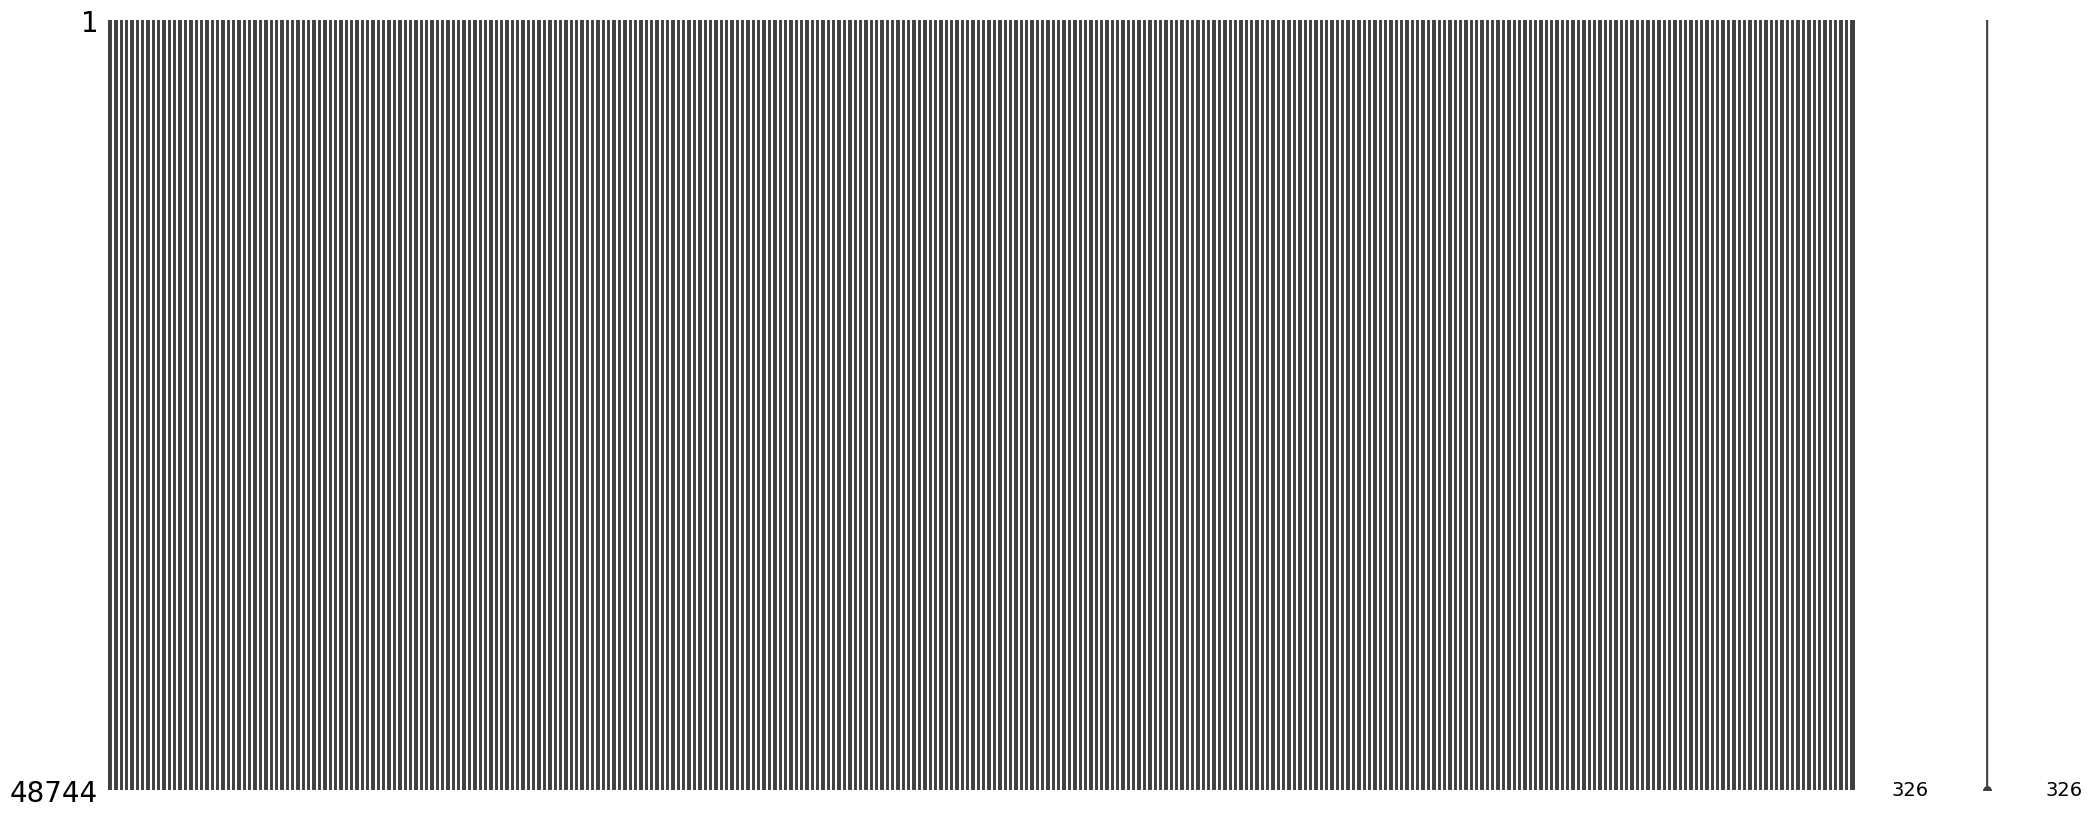

In [204]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

### <span style='background:orange'>4.3. Fichiers POS_CASH_balance.csv</span>

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon.</p> |  |
| <p style='text-align: justify;'>**MONTHS_BALANCE**</p> | <ul style='text-align: justify;'><li>Mois du solde par rapport à la date de la demande.</li> <li>Il s'agit souvent de la même valeur que -1 car de nombreuses banques ne mettent pas régulièrement à jour les informations fournies au Credit Bureau.</li></ul> | <ul style='text-align: justify;'><li>-1 signifie que l'information correspond à l'instantané mensuel le plus récent</li> <li>0 signifie que l'information correspond à la date de la demande</li> </ul>  |
| <p style='text-align: justify;'>**CNT_INSTALMENT**</p> | <p style='text-align: justify;'>Durée du crédit précédent (peut changer avec le temps).</p> |  |
| <p style='text-align: justify;'>**CNT_INSTALMENT_FUTURE**</p> | <p style='text-align: justify;'>Versements restant à payer sur le crédit précédent.</p> |  |
| <p style='text-align: justify;'>**NAME_CONTRACT_STATUS**</p> | <p style='text-align: justify;'>Statut du contrat au cours du mois</p> | <ul style='text-align: justify;'><li>Active</li> <li>Completed</li> <li>Returned to the store</li> <li>Signed</li> <li>Approved</li> <li>Demand</li> <li>Amortized debt</li> <li>Canceled</li> <li>XNA</li></ul> |
| <p style='text-align: justify;'>**SK_DPD**</p> | <p style='text-align: justify;'>DPD (jours de retard) au cours du mois du crédit précédent.</p> |  |
| <p style='text-align: justify;'>**SK_DPD_DEF**</p> | <p style='text-align: justify;'>DPD au cours du mois avec tolérance (les dettes de faible montant sont ignorées) du crédit précédent.</p> |  |

In [463]:
# Taille : nombre de lignes/colonnes
nRow, nVar = cash_balance.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 10001358 lignes et 8 variables.


In [464]:
# Variables quantitatives
cols_num_pos = cash_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_pos

['SK_ID_PREV',
 'SK_ID_CURR',
 'MONTHS_BALANCE',
 'CNT_INSTALMENT',
 'CNT_INSTALMENT_FUTURE',
 'SK_DPD',
 'SK_DPD_DEF']

In [465]:
# Variables catégorielles
cols_cat_pos = cash_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_pos

['NAME_CONTRACT_STATUS']

#### <span style='background:Moccasin'>4.3.1. Réduction de la mémoire d'usage de chaque dataframe</span>

On traite le dataset  cash_balance data


SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0

Taille :-------------------------------------------------------------- (10001358, 8)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Valeurs manquantes  % total des valeurs
CNT_INSTALMENT_FUTURE               26087                  0.3
CNT_INSTALMENT                      26071                  0.3

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_PREV------------------------------------------------------------ contient 936325 valeurs différentes
SK_ID_CURR------------------------------------------------------------ contient 337252 valeurs différentes
MONTHS_BALANCE-------------------------------------------------------- contient 96 valeurs différentes
CNT_INSTALMENT-------------------------------------------------------- contient 73 valeurs différentes
CNT_INSTALMENT_FUTURE------------------------------------------------- contient 79 valeurs différentes
NAME_CONTRACT_STATUS-------------------------------------------------- ['Active' 'Completed' 'Signed' 'Approved' 'Returned to the store' 'Demand'
 'Canceled' 'XNA' 'Amortized debt']
SK_DPD---------------------------------------------------------------- contient 3400 valeurs différentes
SK_DPD_DEF------------------------------------------

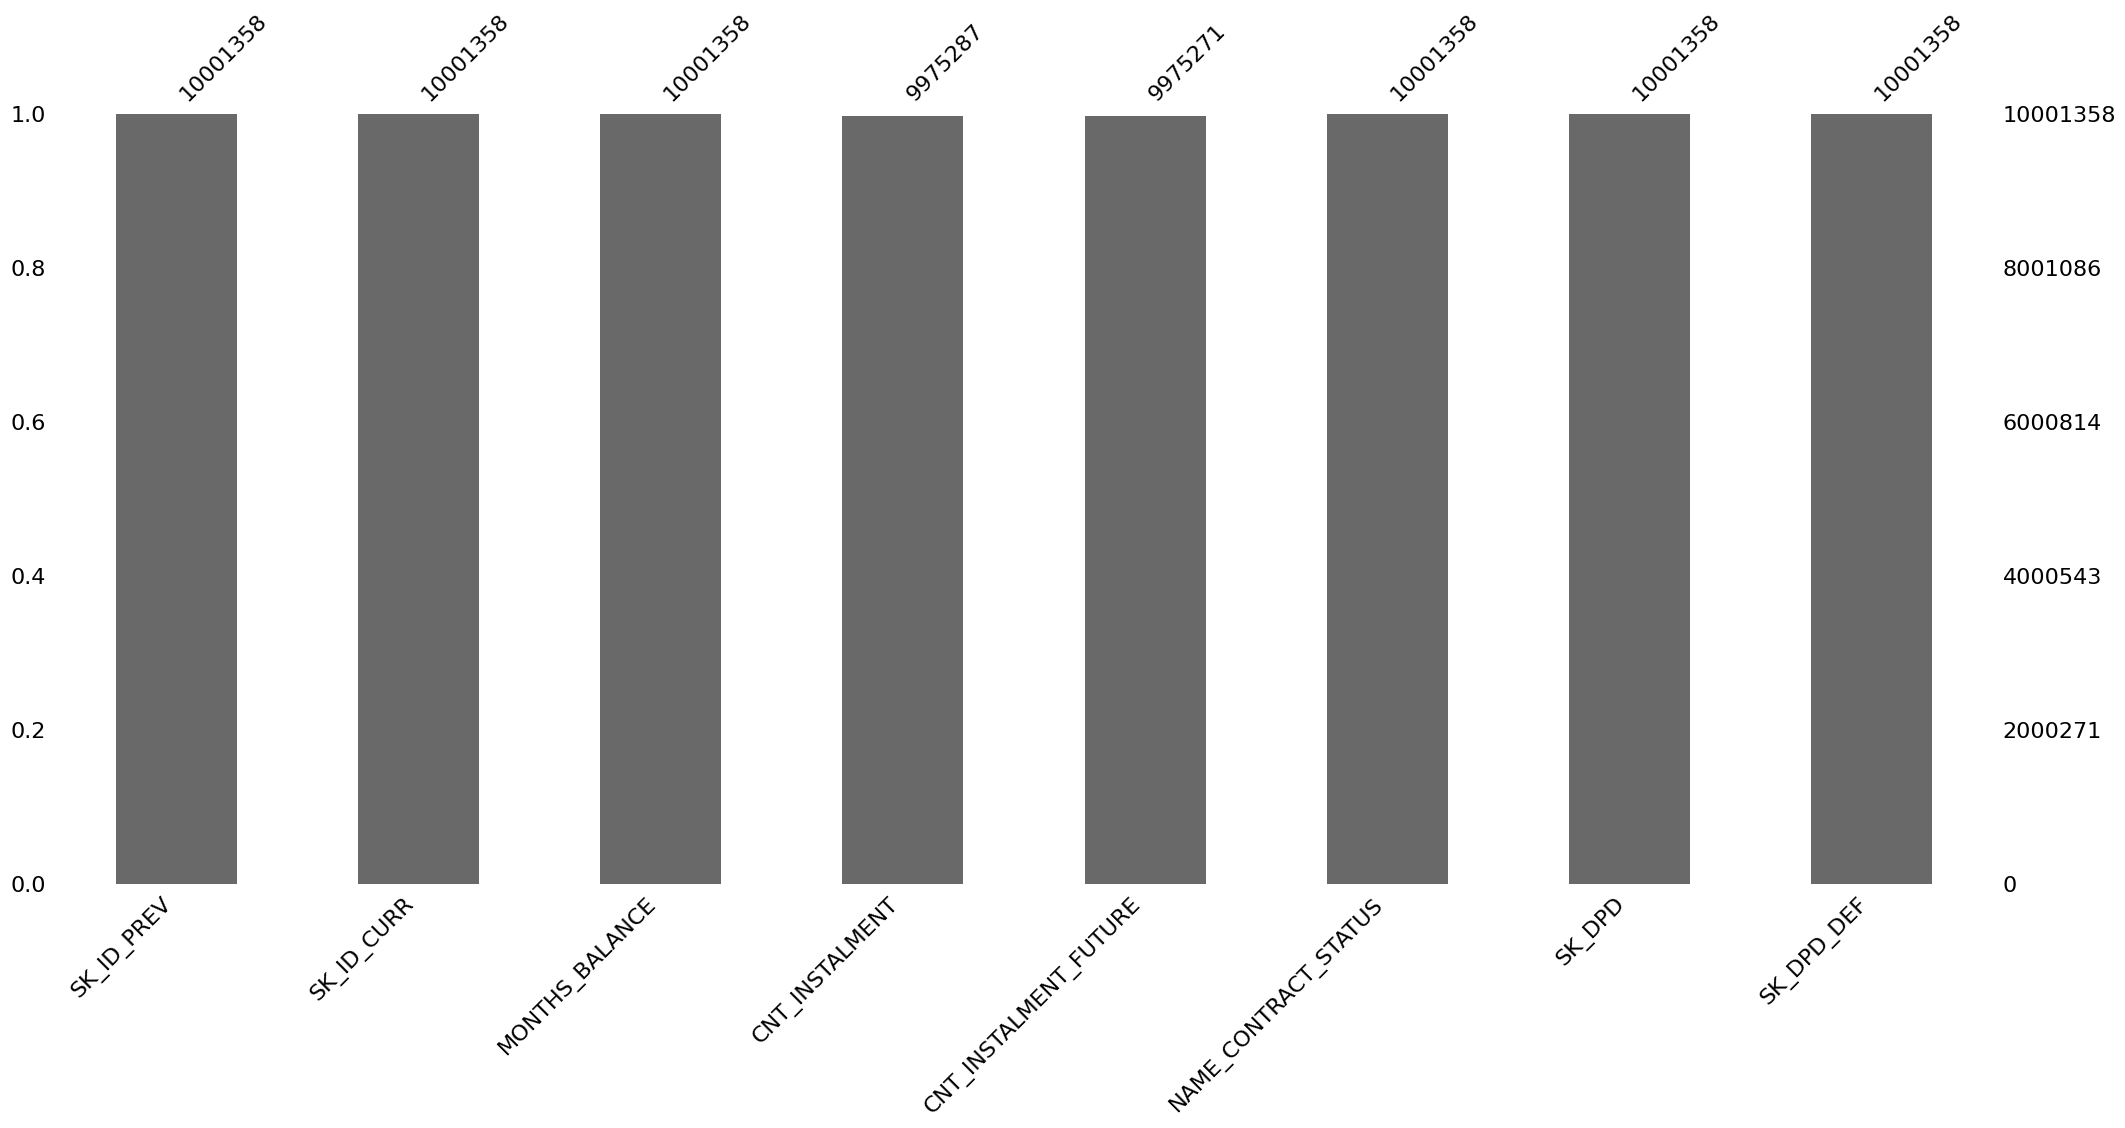

In [209]:
fonctions_data.description_dataset(cash_balance, 'cash_balance data')

<Axes: title={'center': 'Répartition des types de colonnes'}>

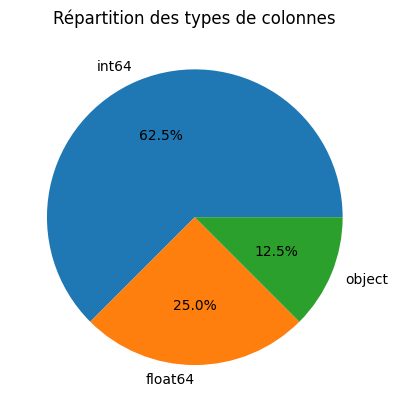

In [210]:
# Types des variables
cash_balance.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

In [466]:
cash_balance= fonctions_data.reduce_mem_usage(cash_balance, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 610.43 MB
Memory usage après optimization: 238.45 MB
Diminution de 60.9%
-------------------------------------------------------------------------------


<Axes: title={'center': 'Répartition des types de colonnes'}>

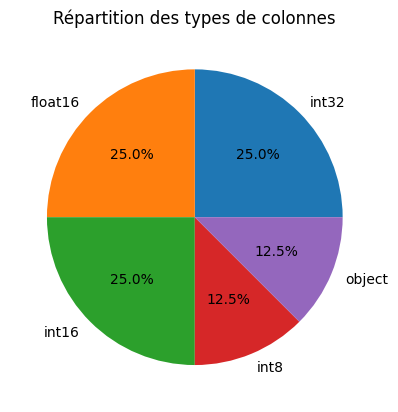

In [212]:
# Types des variables
cash_balance.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### <span style='background:Moccasin'>4.3.2. Feature Engineering</span>

**Feature engineering**
- Création de nouvelles variables simples
- Catégorisation des variables binaires
- Imputation des valeurs manquantes
- Encodage des variables catégorielles
- Normalisation des variables numériques

In [468]:
def pos_cash():
    pos = cash_balance

    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # Flag months with late payment

    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # Ratio : DPD (jours de retard) au cours du mois du crédit précédent \
    #         DPD au cours du mois avec tolérance (les dettes de faible
    #         montant sont ignorées) du crédit précédent
    pos['SK_DPD_RATIO'] = \
        pos['SK_DPD'] / (pos['SK_DPD_DEF'] + 0.00001)
    # Somme : Nombre d'échéances payées sur le crédit précédent +
    #         Versements restant à payer sur le crédit précédent
    pos['TOTAL_TERM'] = \
        pos['CNT_INSTALMENT'] + \
        pos['CNT_INSTALMENT_FUTURE']

    # Features

    aggregations = {'MONTHS_BALANCE' : ['min', 'max','size'],
                'CNT_INSTALMENT' : ['mean', 'max','min'],
                'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
                'SK_DPD' : ['mean', 'max', 'sum'],
                'SK_DPD_DEF' : ['mean', 'max','sum'],
                # Nouvelles Features
                'LATE_PAYMENT': ['mean','max'],
                'SK_DPD_RATIO' : ['mean','max'],
                'TOTAL_TERM' : ['mean','max','last'],}
    

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()


    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df_pos = pd.DataFrame()
    df_pos['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df_pos['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

    # Percentage of previous loans completed and completed before initial term
    df_pos['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = df_pos.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0 \
                                                                      and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df_pos['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df_pos['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()

    # Group by SK_ID_CURR and merge
    df_gp = df_pos.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')

    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR', 'LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')
    pos_agg.set_index('SK_ID_CURR', inplace = True)

    print('"Pos-Cash" balance final shape:', pos_agg.shape) 
    return pos_agg

In [469]:
pos_cash_fe = pos_cash() 

"Pos-Cash" balance final shape: (337252, 38)


In [470]:
pos_cash_fe.head()

POS_MONTHS_BALANCE_MIN  POS_MONTHS_BALANCE_MAX  \
SK_ID_CURR                                                   
100001                         -96                     -53   
100002                         -19                      -1   
100003                         -77                     -18   
100004                         -27                     -24   
100005                         -25                     -15   

            POS_MONTHS_BALANCE_SIZE  POS_CNT_INSTALMENT_MEAN  \
SK_ID_CURR                                                     
100001                            9                 4.000000   
100002                           19                24.000000   
100003                           28                10.107142   
100004                            4                 3.750000   
100005                           11                11.700000   

            POS_CNT_INSTALMENT_MAX  POS_CNT_INSTALMENT_MIN  \
SK_ID_CURR                                                   
100001                         4.0                     4.0   
100002                        24.0                    24.0   
100003                        12.0                     6.0   
100004                         4.0                     3.0   
100005                        12.0                     9.0   

            POS_CNT_INSTALMENT_FUTURE_MEAN  POS_CNT_INSTALMENT_FUTURE_MAX  \
SK_ID_CURR                                                                  
100001                            1.444444                            4.0   
100002                           15.000000                           24.0   
100003                            5.785714                           12.0   
100004                            2.250000                            4.0   
100005                            7.200000                           12.0   

            POS_CNT_INSTALMENT_FUTURE_MIN  POS_SK_DPD_MEAN  ...  \
SK_ID_CURR                                                  ...   
100001                                0.0         0.777778  ...   
100002                                6.0         0.000000  ...   
100003                                0.0         0.000000  ...   
100004                                0.0         0.000000  ...   
100005                                0.0         0.000000  ...   

            POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
SK_ID_CURR                                                        
100001                                                    0.0     
100002                                                    0.0     
100003                                                    0.0     
100004                                                    0.0     
100005                                                    0.0     

            POS_NAME_CONTRACT_STATUS_Signed_MEAN  \
SK_ID_CURR                                         
100001                                  0.000000   
100002                                  0.000000   
100003                                  0.000000   
100004                                  0.000000   
100005                                  0.090909   

            POS_NAME_CONTRACT_STATUS_XNA_MEAN  \
SK_ID_CURR                                      
100001                                    0.0   
100002                                    0.0   
100003                                    0.0   
100004                                    0.0   
100005                                    0.0   

            POS_NAME_CONTRACT_STATUS_nan_MEAN  POS_COUNT  \
SK_ID_CURR                                                 
100001                                    0.0          9   
100002                                    0.0         19   
100003                                    0.0         28   
100004                                    0.0          4   
100005                                    0.0         11   

            POS_LOAN_COMPLETED_MEAN  POS_COMPLETED_BEFORE_MEAN  \
SK_ID_CURR       

#### <span style='background:Moccasin'>4.3.3. Assemblage avec le 'train set'</span>

In [471]:
features_set = features_set.merge(pos_cash_fe, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with bureau:', features_set.shape)

--=> features_set after merge with bureau: (307507, 339)


In [472]:
# Description
fonctions_data.detail_type_var(features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float16     float16      float16         float16   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count            307507.0    307507.0     307507.0        307507.0   
mean                  0.0         NaN          NaN             NaN   
std                   0.0         0.0          0.0             0.0   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          1.0             0.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type        float16          float16    float16     float16   
nb_nan          0.0              0.0        0.0         0.0   
%_nan           0.0              0.0        0.0         0.0   
count      307507.0         307507.0   307507.0    307507.0   
mean            0.0              0.0        0.0         0.0   
std             0.0              0.0        0.0         0.0   
min             0.0              0.0        0.0         0.0   
25%             0.0         0.000742   0.056183    0.058136   
50%             0.0         0.001039   0.117004     0.09082   
75%        0.052643         0.001512   0.190674    0.128662   
max             1.0              1.0        1.0         1.0   

       REGION_POPULATION_RELATIVE DAYS_BIRTH  ...  \
type                      float16    float16  ...   
nb_nan                        0.0        0.0  ...   
%_nan                         0.0        0.0  ...   
count                    307507.0   307507.0  ...   
mean                          NaN        NaN  ...   
std                           0.0        0.0  ...   
min                           0.0        0.0  ...   
25%                      0.134644   0.312744  ...   
50%                      0.256836    0.53418  ...   
75%                      0.392822   0.722656  ...   
max                           1.0        1.0  ...   

       POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
type                                              float64    
nb_nan                                            18067.0    
%_nan                                            5.875313    
count                                            289440.0    
mean                                             0.000804    
std                                              0.010168    
min                                                   0.0    
25%                                                   0.0    
50%                                                   0.0    
75%                                                   0.0    
max                                                   1.0    

       POS_NAME_CONTRACT_STATUS_Signed_MEAN POS_NAME_CONTRACT_STATUS_XNA_MEAN  \
type                                float64                           float64   
nb_nan                              18067.0                           18067.0   
%_nan                              5.875313                          5.875313   
count                              289440.0                          289440.0   
mean                               0.010587                               0.0   
std                                 0.03262                          0.000016   
min                                     0.0                               0.0   
25%                                     0.0                               0.0   
50%                                     0.0                               0.0   
75%                                     0.0                               0.0   
max                                     1.0                           0.00625   

       POS_NAME_CONTRACT_STATUS_nan_MEAN  POS_COUNT PO

#### <span style='background:Moccasin'>4.3.4. Assemblage avec le 'test set'</span>

In [473]:
test_features_set = test_features_set.merge(pos_cash_fe, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with bureau:', test_features_set.shape)

--=> features_set after merge with bureau: (48744, 330)


In [474]:
# Description
fonctions_data.detail_type_var(test_features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float16     float16      float16         float16   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count             48744.0     48744.0      48744.0         48744.0   
mean              0.00901     0.32959     0.337158        0.690918   
std              0.094482    0.470215       0.4729        0.462402   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          0.0             1.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type        float16          float16    float16     float16   
nb_nan          0.0              0.0        0.0         0.0   
%_nan           0.0              0.0        0.0         0.0   
count       48744.0          48744.0    48744.0     48744.0   
mean       0.020905         0.001307   0.117798    0.108521   
std        0.037323          0.00088   0.091248    0.062439   
min             0.0         0.000011        0.0    0.002649   
25%             0.0         0.000742   0.053833    0.063782   
50%             0.0         0.001127   0.101135    0.095886   
75%        0.052643         0.001704   0.157349    0.139526   
max        1.052734         0.037476   0.549316    0.697754   

       REGION_POPULATION_RELATIVE DAYS_BIRTH  ...  \
type                      float16    float16  ...   
nb_nan                        0.0        0.0  ...   
%_nan                         0.0        0.0  ...   
count                     48744.0    48744.0  ...   
mean                     0.290039   0.516602  ...   
std                      0.199829   0.243896  ...   
min                     -0.000511   0.001917  ...   
25%                      0.134521   0.315186  ...   
50%                       0.25708   0.532227  ...   
75%                      0.392822   0.717773  ...   
max                           1.0   1.008789  ...   

       POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN  \
type                                              float64    
nb_nan                                              936.0    
%_nan                                            1.920236    
count                                             47808.0    
mean                                              0.00105    
std                                              0.011993    
min                                                   0.0    
25%                                                   0.0    
50%                                                   0.0    
75%                                                   0.0    
max                                              0.666667    

       POS_NAME_CONTRACT_STATUS_Signed_MEAN POS_NAME_CONTRACT_STATUS_XNA_MEAN  \
type                                float64                           float64   
nb_nan                                936.0                             936.0   
%_nan                              1.920236                          1.920236   
count                               47808.0                           47808.0   
mean                               0.010754                               0.0   
std                                  0.0324                               0.0   
min                                     0.0                               0.0   
25%                                     0.0                               0.0   
50%                                     0.0                               0.0   
75%                                     0.0                               0.0   
max                                     1.0                               0.0   

       POS_NAME_CONTRACT_STATUS_nan_MEAN  POS_COUNT PO

#### <span style='background:Moccasin'>4.3.5. Nettoyage</span>

<span style='background:mistyrose'>**Réduction mémoire des dataframes**</span>

In [475]:
features_set = fonctions_data.reduce_mem_usage(features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 281.24 MB
Memory usage après optimization: 233.73 MB
Diminution de 16.9%
-------------------------------------------------------------------------------


In [476]:
test_features_set = fonctions_data.reduce_mem_usage(test_features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 43.60 MB
Memory usage après optimization: 36.07 MB
Diminution de 17.3%
-------------------------------------------------------------------------------


<span style='background:mistyrose'>**Variables fortement corrélées**</span>

In [477]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_features_set = fonctions_data.suppr_var_colineaire(features_set)

17 variables fortement corrélées à supprimer :

POS_MONTHS_BALANCE_MIN
POS_MONTHS_BALANCE_MAX
POS_CNT_INSTALMENT_MAX
POS_CNT_INSTALMENT_FUTURE_MEAN
POS_CNT_INSTALMENT_FUTURE_MAX
POS_SK_DPD_MAX
POS_SK_DPD_SUM
POS_SK_DPD_DEF_MAX
POS_SK_DPD_DEF_SUM
POS_SK_DPD_RATIO_MEAN
POS_SK_DPD_RATIO_MAX
POS_TOTAL_TERM_MEAN
POS_TOTAL_TERM_MAX
POS_NAME_CONTRACT_STATUS_Completed_MEAN
POS_COUNT
POS_REMAINING_INSTALMENTS_RATIO
LATE_PAYMENT_SUM


In [478]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_test_features_set = fonctions_data.suppr_var_colineaire(test_features_set)

16 variables fortement corrélées à supprimer :

POS_MONTHS_BALANCE_MIN
POS_MONTHS_BALANCE_MAX
POS_CNT_INSTALMENT_MAX
POS_CNT_INSTALMENT_FUTURE_MEAN
POS_CNT_INSTALMENT_FUTURE_MAX
POS_SK_DPD_MAX
POS_SK_DPD_SUM
POS_SK_DPD_DEF_MAX
POS_SK_DPD_DEF_SUM
POS_SK_DPD_RATIO_MEAN
POS_SK_DPD_RATIO_MAX
POS_TOTAL_TERM_MEAN
POS_TOTAL_TERM_MAX
POS_NAME_CONTRACT_STATUS_Completed_MEAN
POS_COUNT
LATE_PAYMENT_SUM


***Train set***

In [479]:
# Suppression des variables fortement corrélées du train set
features_set = features_set.drop(columns = var_corr_features_set)
print(f'train_set : {features_set.shape}')

train_set : (307507, 322)


***Test set***

In [480]:
# Suppression des variables fortement corrélées du train set
test_features_set = test_features_set.drop(columns = var_corr_test_features_set)
print(f'test_set : {test_features_set.shape}')

test_set : (48744, 314)


<span style='background:mistyrose'>**Imputation des données**</span>

***Train set***

Valeurs manquantes :379503 NaN pour 105782408 données (0.36 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
POS_MONTHS_BALANCE_SIZE                                                     18067   
POS_NAME_CONTRACT_STATUS_Approved_MEAN                                      18067   
POS_COMPLETED_BEFORE_MEAN                                                   18067   
POS_LOAN_COMPLETED_MEAN                                                     18067   
POS_NAME_CONTRACT_STATUS_nan_MEAN                                           18067   
POS_NAME_CONTRACT_STATUS_XNA_MEAN                                           18067   
POS_NAME_CONTRACT_STATUS_Signed_MEAN                                        18067   
POS_NAME_CONTRACT_STATUS_Returned to the store_...                          18067   
POS_NAME_CONTRACT_STATUS_Demand_MEAN                                        18067   
POS_NAME_CONTRACT_STATUS_Canceled_MEAN                                      18067   
POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN                                18067   
POS_CNT_INSTALMENT_MEAN                                                     18091   
POS_NAME_CONTRACT_STATUS_Active_MEAN                                        18067   
POS_TOTAL_TERM_LAST                                                         18091   
POS_LATE_PAYMENT_MAX                                                        18067   
POS_LATE_PAYMENT_MEAN                                                       18067   
POS_SK_DPD_DEF_MEAN                                                         18067   
POS_SK_DPD_MEAN                                                             18067   
POS_CNT_INSTALMENT_FUTURE_MIN                                               18091   
POS_CNT_INSTALMENT_MIN                                                      18091   
POS_REMAINING_INSTALMENTS                                                   18067   

                                                    % de valeurs manquantes  
POS_MONTHS_BALANCE_SIZE                                                5.88  
POS_NAME_CONTRACT_STATUS_Approved_MEAN                                 5.88  
POS_COMPLETED_BEFORE_MEAN                                              5.88  
POS_LOAN_COMPLETED_MEAN                                                5.88  
POS_NAME_CONTRACT_STATUS_nan_MEAN                                      5.88  
POS_NAME_CONTRACT_STATUS_XNA_MEAN                                      5.88  
POS_NAME_CONTRACT_STATUS_Signed_MEAN                                   5.88  
POS_NAME_CONTRACT_STATUS_Returned to the store_...                     5.88  
POS_NAME_CONTRACT_STATUS_Demand_MEAN                                   5.88  
POS_NAME_CONTRACT_STATUS_Canceled_MEAN                                 5.88  
POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN                           5.88  
POS_CNT_INSTALMENT_MEAN                                                5.88  
POS_NAME_CONTRACT_STATUS_Active_MEAN                                   5.88  
POS_TOTAL_TERM_LAST                                                    5.88  
POS_LATE_PAYMENT_MAX                                                   5.88  
POS_LATE_PAYMENT_MEAN                                                  5.88  
POS_SK_DPD_DEF_MEAN                                                    5.88  
POS_SK_DPD_MEAN                                                        5.88  
POS_CNT_INSTALMENT_FUTURE_MIN                                          5.88  
POS_CNT_INSTALMENT_MIN                                                 5.88  
POS_REMAINING_INSTALMENTS                                              5.88

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


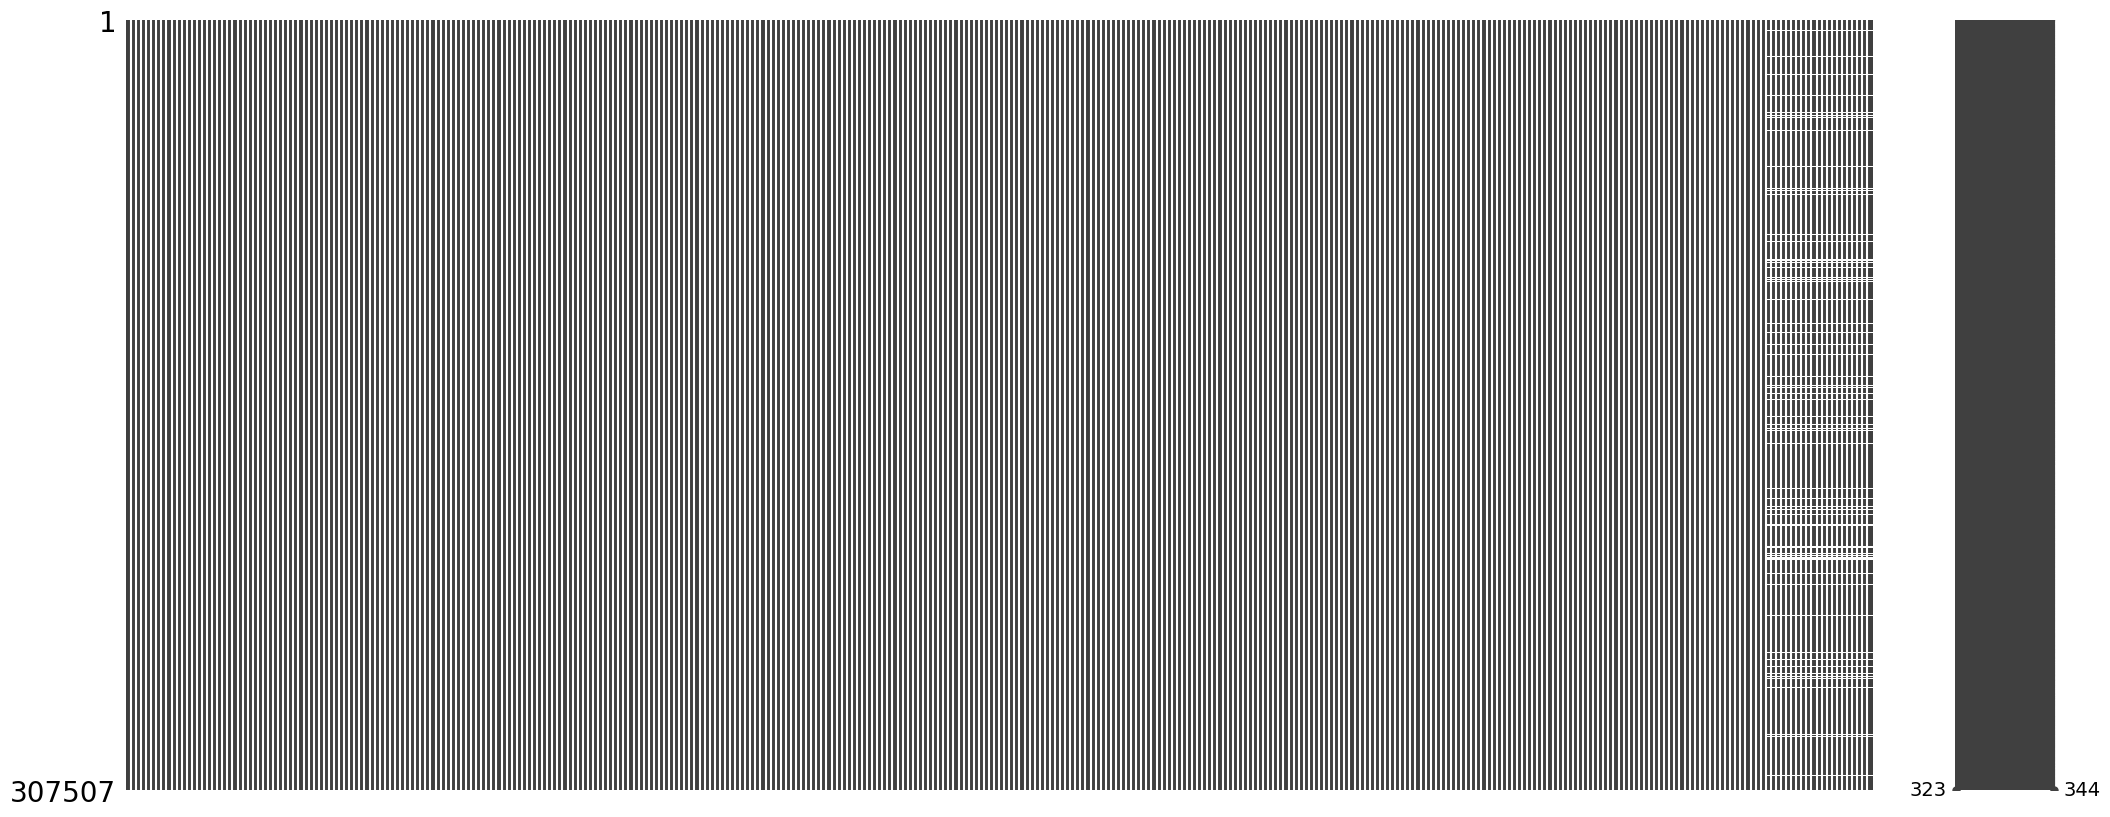

In [235]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [481]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
features_set = features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 379503
Nombre de nan ou valeurs nulles après suppression des champs vierges : 379503


**Imputation par la médiane**

In [482]:
# Variables quantitatives - imputation par médiane
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
features_set.fillna(features_set.median(), inplace=True)

# Vérification
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 379503
Nombre de nan après imputation par median : 0


In [483]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = features_set.columns[(features_set == 0).all()]
colonnes_nulles

Index(['POS_NAME_CONTRACT_STATUS_nan_MEAN'], dtype='object')

In [484]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
features_set = features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = features_set.columns[(features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 1
Nombre de champs nulles après imputation: 0


**Imputation avec NaNIMputer (Verstack)**

In [237]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = features_set.isna().sum().sum()

In [238]:
# Copie du jeu de données
X_nan = features_set.copy()

In [239]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.18696 seconds


In [240]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


Valeurs manquantes :0 NaN pour 98709747 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


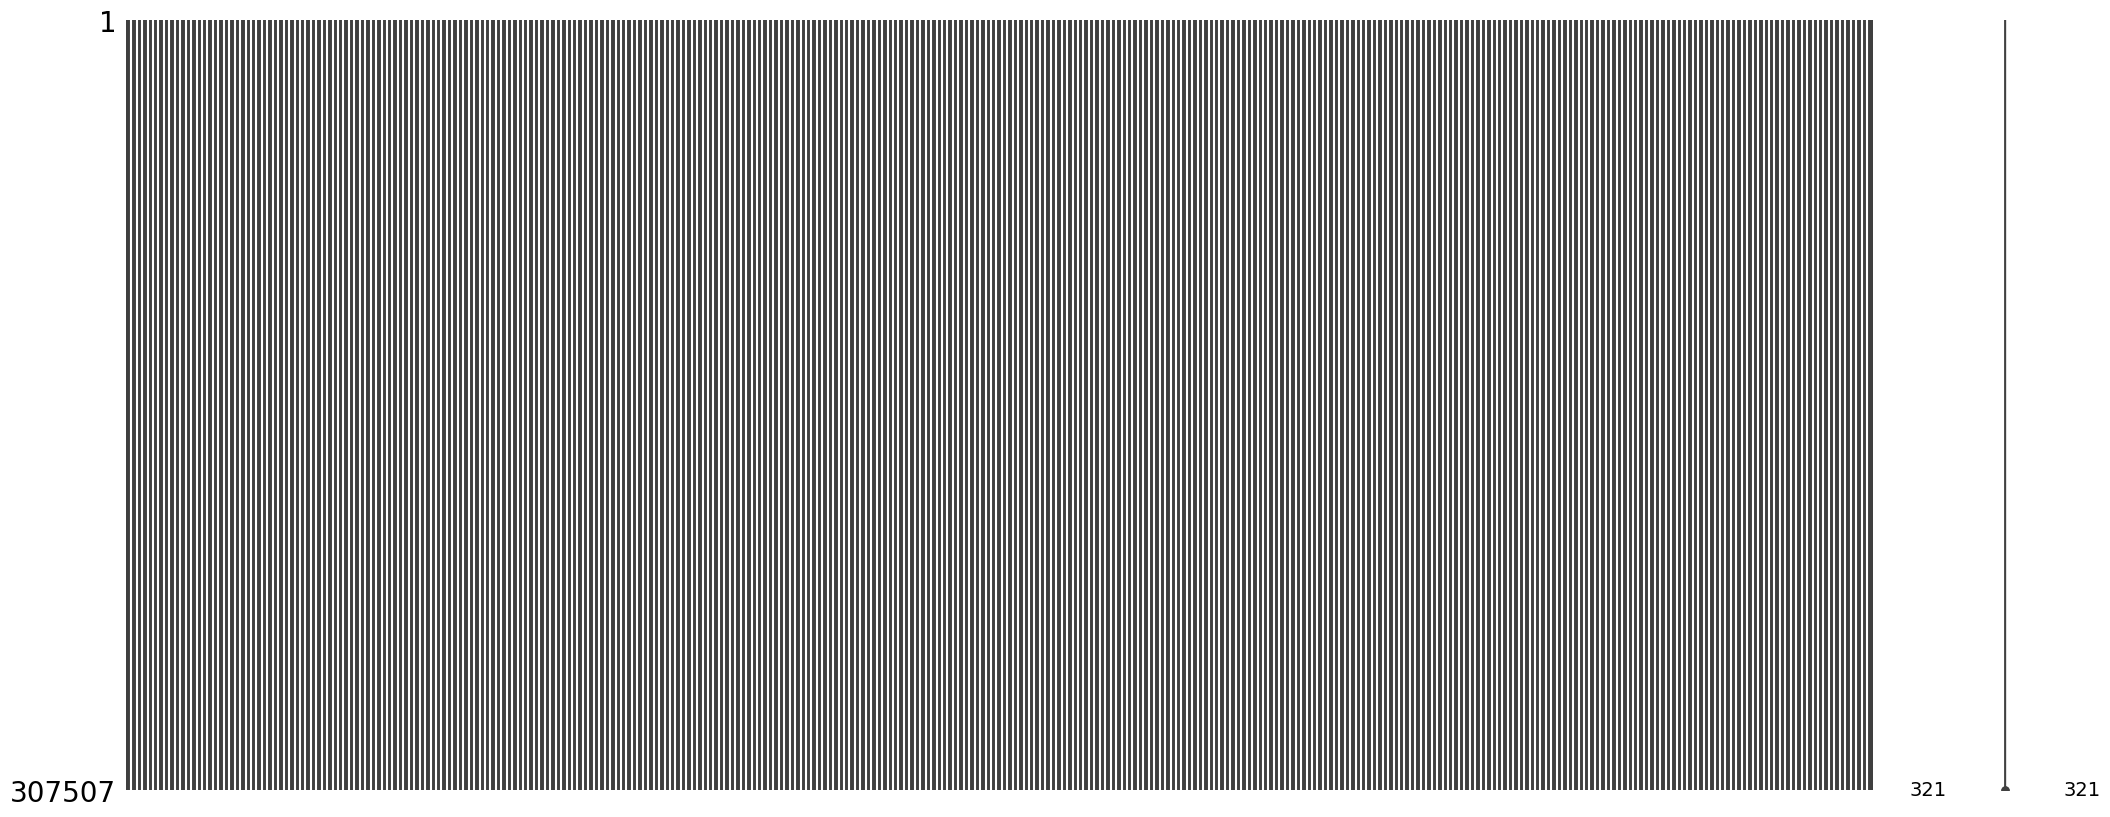

In [485]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

***Test set***

Valeurs manquantes :20608 NaN pour 16962912 données (0.12 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
POS_CNT_INSTALMENT_MIN                                                        940   
POS_CNT_INSTALMENT_FUTURE_MIN                                                 940   
POS_TOTAL_TERM_LAST                                                           940   
POS_CNT_INSTALMENT_MEAN                                                       940   
POS_MONTHS_BALANCE_SIZE                                                       936   
POS_NAME_CONTRACT_STATUS_Demand_MEAN                                          936   
POS_REMAINING_INSTALMENTS                                                     936   
POS_COMPLETED_BEFORE_MEAN                                                     936   
POS_LOAN_COMPLETED_MEAN                                                       936   
POS_NAME_CONTRACT_STATUS_nan_MEAN                                             936   
POS_NAME_CONTRACT_STATUS_XNA_MEAN                                             936   
POS_NAME_CONTRACT_STATUS_Signed_MEAN                                          936   
POS_NAME_CONTRACT_STATUS_Returned to the store_...                            936   
POS_NAME_CONTRACT_STATUS_Approved_MEAN                                        936   
POS_NAME_CONTRACT_STATUS_Canceled_MEAN                                        936   
POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN                                  936   
POS_NAME_CONTRACT_STATUS_Active_MEAN                                          936   
POS_LATE_PAYMENT_MAX                                                          936   
POS_LATE_PAYMENT_MEAN                                                         936   
POS_SK_DPD_DEF_MEAN                                                           936   
POS_SK_DPD_MEAN                                                               936   
POS_REMAINING_INSTALMENTS_RATIO                                               936   

                                                    % de valeurs manquantes  
POS_CNT_INSTALMENT_MIN                                                 1.93  
POS_CNT_INSTALMENT_FUTURE_MIN                                          1.93  
POS_TOTAL_TERM_LAST                                                    1.93  
POS_CNT_INSTALMENT_MEAN                                                1.93  
POS_MONTHS_BALANCE_SIZE                                                1.92  
POS_NAME_CONTRACT_STATUS_Demand_MEAN                                   1.92  
POS_REMAINING_INSTALMENTS                                              1.92  
POS_COMPLETED_BEFORE_MEAN                                              1.92  
POS_LOAN_COMPLETED_MEAN                                                1.92  
POS_NAME_CONTRACT_STATUS_nan_MEAN                                      1.92  
POS_NAME_CONTRACT_STATUS_XNA_MEAN                                      1.92  
POS_NAME_CONTRACT_STATUS_Signed_MEAN                                   1.92  
POS_NAME_CONTRACT_STATUS_Returned to the store_...                     1.92  
POS_NAME_CONTRACT_STATUS_Approved_MEAN                                 1.92  
POS_NAME_CONTRACT_STATUS_Canceled_MEAN                                 1.92  
POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN                           1.92  
POS_NAME_CONTRACT_STATUS_Active_MEAN                                   1.92  
POS_LATE_PAYMENT_MAX                                                   1.92  
POS_LATE_PAYMENT_MEAN                                                  1.92  
POS_SK_DPD_DEF_MEAN                                                    1.92  
POS_SK_DPD_MEAN                                                        1.92  
POS_REMAINING_INSTALMENTS_RATIO                                        1.92

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


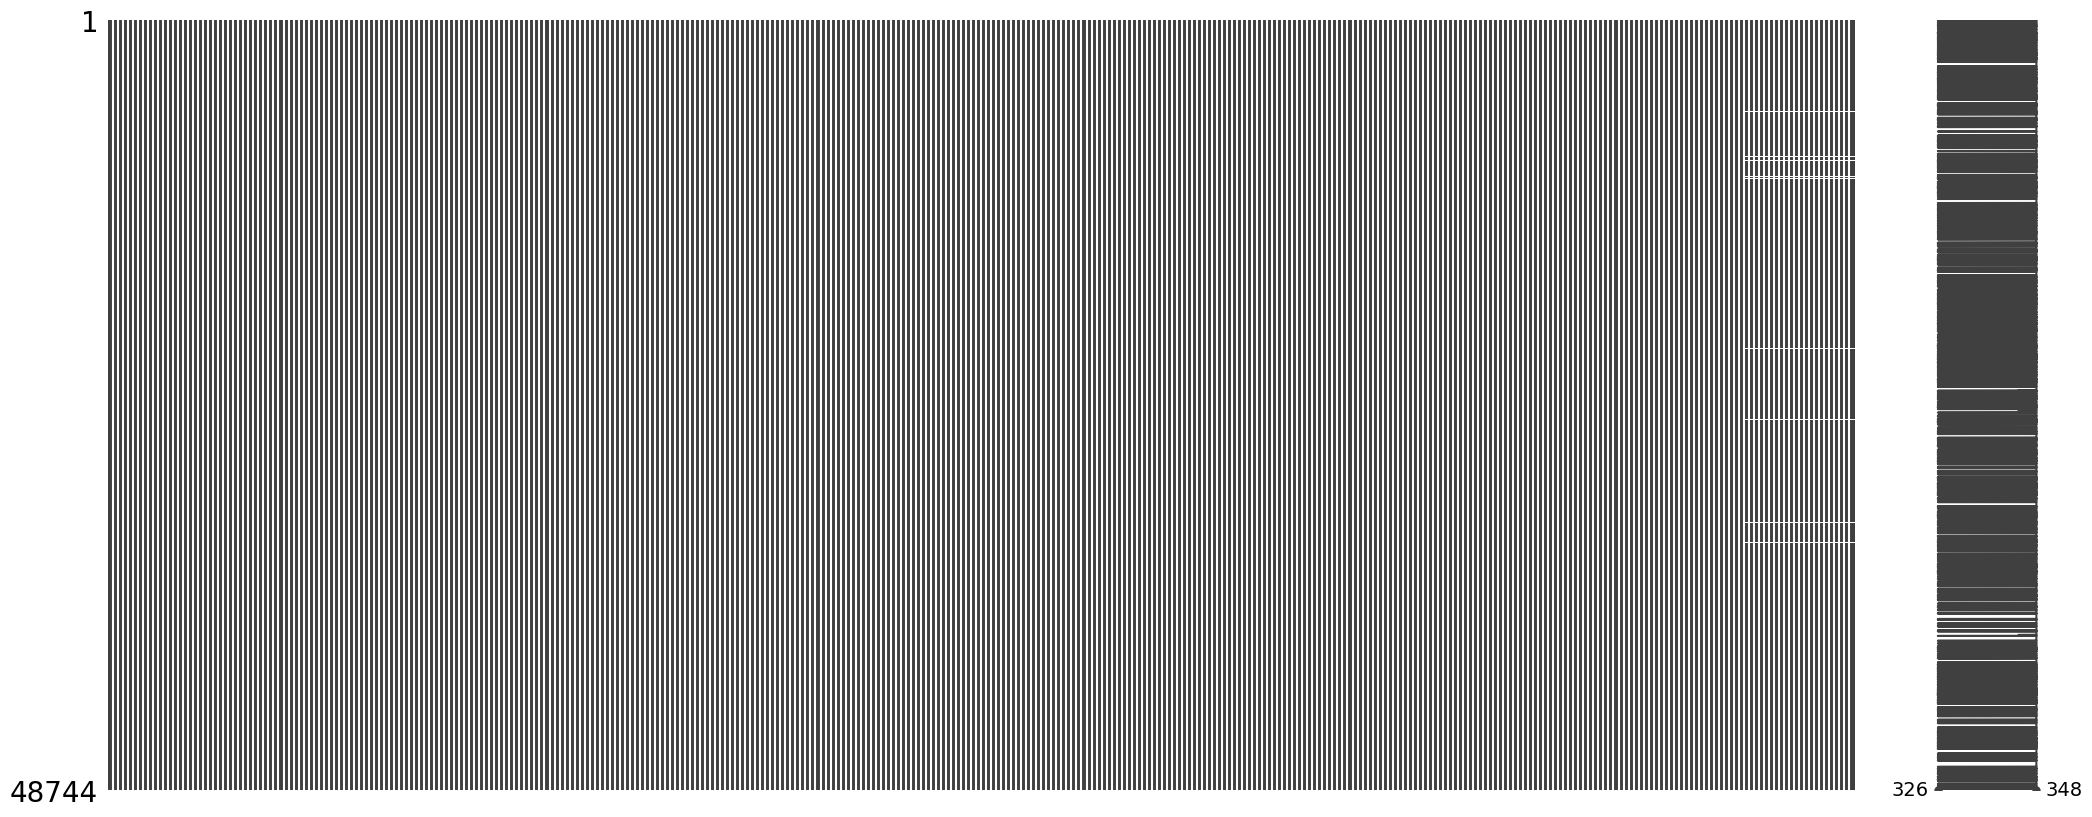

In [242]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [486]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
test_features_set = test_features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 215941
Nombre de nan ou valeurs nulles après suppression des champs vierges : 215941


**Imputation par la médiane**

In [487]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_features_set.fillna(test_features_set.median(), inplace=True)

# Vérification
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 215941
Nombre de nan après imputation par median : 0


In [488]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
colonnes_nulles

Index(['POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN'], dtype='object')

In [489]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
test_features_set = test_features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 2
Nombre de champs nulles après imputation: 0


**Imputation avec NaNIMputer (Verstack)**

In [244]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features_set.isna().sum().sum()

In [245]:
# Copie du jeu de données
X_nan = test_features_set.copy()

In [246]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.07662 seconds


In [247]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


Valeurs manquantes :0 NaN pour 15208128 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


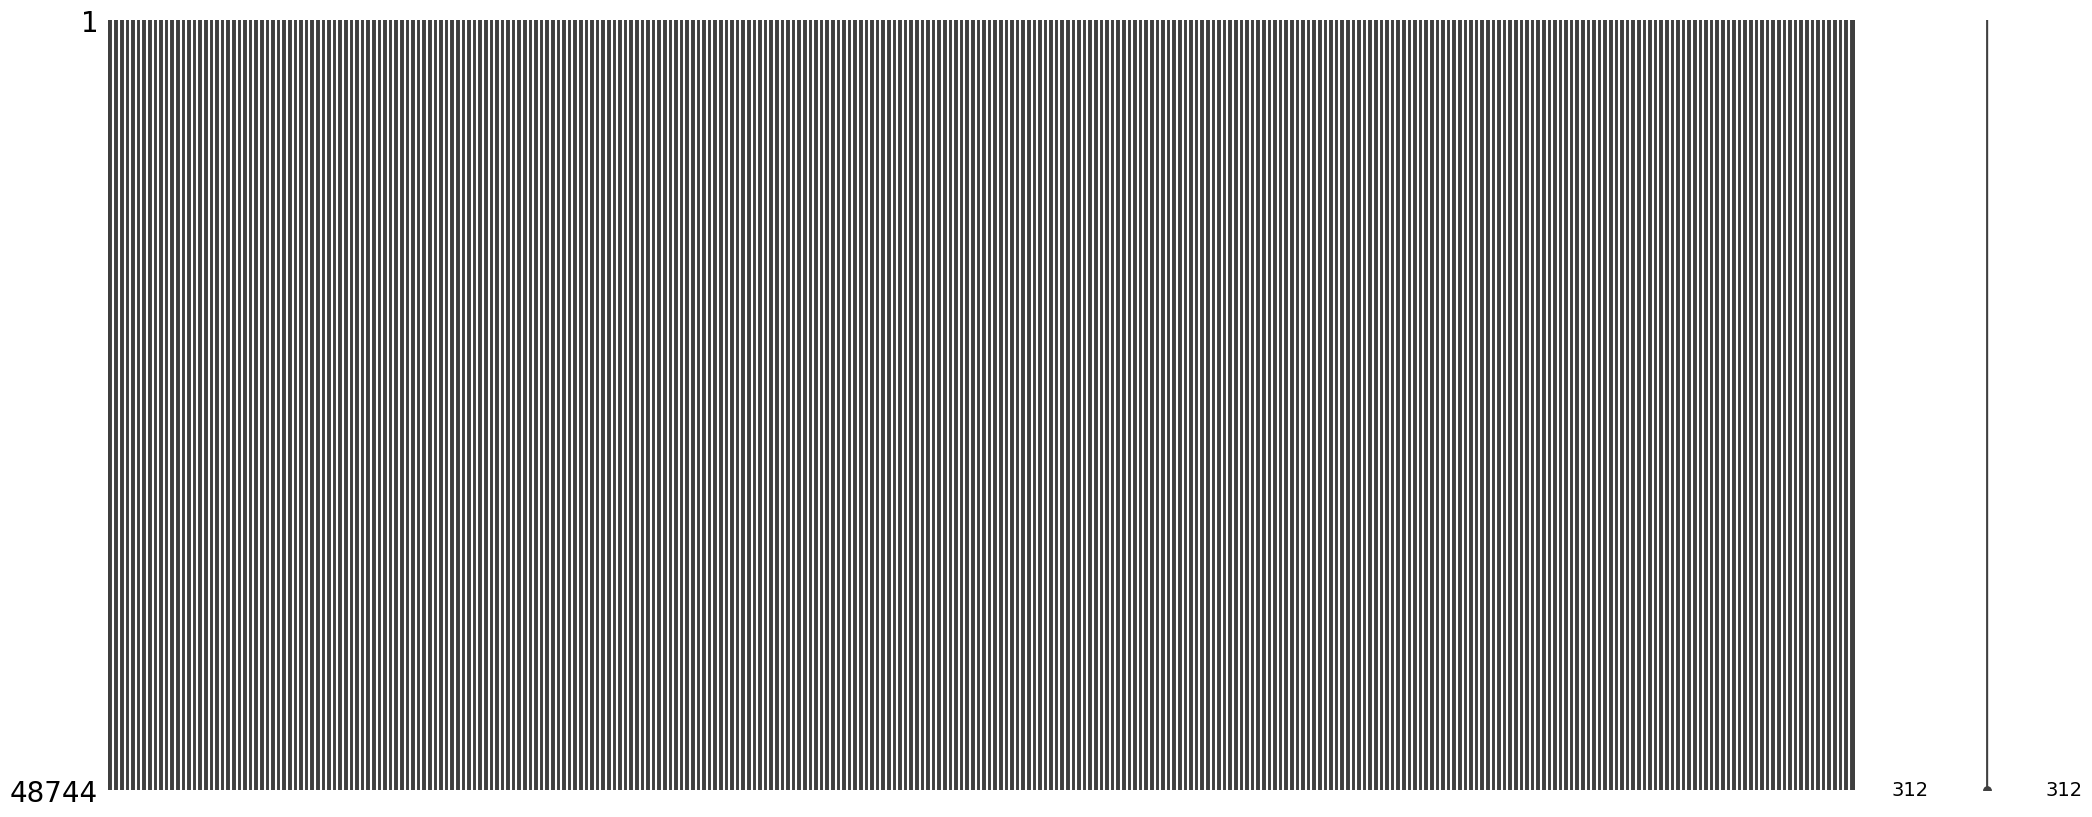

In [490]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

### <span style='background:orange'>4.4. Fichiers previous_application.csv</span>

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_PREV**</p> | <ul style='text-align: justify;'><li>ID du crédit précédent dans le crédit immobilier lié au prêt dans notre échantillon.</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de prêts précédents dans Home Credit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <p style='text-align: justify;'>ID du prêt dans notre échantillon.</p> |  |
| <p style='text-align: justify;'>**NAME_CONTRACT_TYPE**</p> | <p style='text-align: justify;'>Type de produit contractuel (prêt d'argent ou prêt à la consommation [POS]...) de la demande précédente.</p> | <ul style='text-align: justify;'><li>Consumer loans</li> <li>Cash loans</li> <li>Revolving loans</li> <li>XNA</li></ul>  |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuité de la demande précédente</p> |  |
| <p style='text-align: justify;'>**AMT_APPLICATION**</p> | <p style='text-align: justify;'>Pour quel montant de crédit le client a-t-il demandé lors de la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT**</p> | <ul style='text-align: justify;'><li>Montant final du crédit sur la demande précédente.</li> <li>Il diffère de AMT_APPLICATION dans la mesure où AMT_APPLICATION est le montant pour lequel le client a initialement fait une demande mais au cours de notre processus d'approbation il aurait pu recevoir un montant différent : AMT_CREDIT.</li></ul> |  |
| <p style='text-align: justify;'>**AMT_DOWN_PAYMENT**</p> | <p style='text-align: justify;'>Acompte sur la demande précédente.</p> |  |
| <p style='text-align: justify;'>**AMT_GOODS_PRICE**</p> | <p style='text-align: justify;'>Prix du bien que le client a demandé (le cas échéant) sur la demande précédente.</p> |  |
| <p style='text-align: justify;'>**WEEKDAY_APPR_PROCESS_START**</p> | <p style='text-align: justify;'>Quel jour de la semaine le client a-t-il fait la demande précédente ?</p> | <ul style='text-align: justify;'><li>SATURDAY</li> <li>FRIDAY</li> <li>SUNDAY</li> <li>THURSDAY</li> <li>TUESDAY</li> <li>MONDAY</li> <li>WEDNESDAY</li></ul>  |
| <p style='text-align: justify;'>**HOUR_APPR_PROCESS_START**</p> | <p style='text-align: justify;'>À quelle heure environ le client a-t-il fait sa demande pour la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**FLAG_LAST_APPL_PER_CONTRACT**</p> | <ul style='text-align: justify;'><li>Indicateur si c'était la dernière demande pour le contrat précédent.</li> <li>Parfois par erreur du client ou de notre greffier il peut y avoir plusieurs demandes pour un seul contrat.</li></ul> |  |
| <p style='text-align: justify;'>**NFLAG_LAST_APPL_IN_DAY**</p> | <ul style='text-align: justify;'><li>Indicateur indiquant si la demande était la dernière demande par jour du client.</li> <li>Il arrive que les clients postulent pour plusieurs demandes par jour.</li> <li>Dans de rares cas il peut aussi s'agir d'une erreur de notre système qui fait qu'une demande figure deux fois dans la base de données.</li></ul> |  |
| <p style='text-align: justify;'>**NFLAG_MICRO_CASH**</p> | <p style='text-align: justify;'>Indicateur Micro finance loan.</p> |  |
| <p style='text-align: justify;'>**RATE_DOWN_PAYMENT**</p> | <p style='text-align: justify;'>Taux d'acompte normalisé sur le crédit antérieur.</p> |  |
| <p style='text-align: justify;'>**RATE_INTEREST_PRIMARY**</p> | <p style='text-align: justify;'>Taux d'intérêt normalisé sur le crédit antérieur.</p> |  |
| <p style='text-align: justify;'>**RATE_INTEREST_PRIVILEGED**</p> | <p style='text-align: justify;'>Taux d'intérêt normalisé sur le crédit antérieur.</p> |  |
| <p style='text-align: justify;'>**NAME_CASH_LOAN_PURPOSE**</p> | <p style='text-align: justify;'>Objectif du prêt d'argent.</p> | <ul style='text-align: justify;'><li>XAP</li> <li>XNA</li> <li>Other</li> <li>Payments on other loans</li> <li>Buying a used car</li> <li>Repairs</li> <li>Education</li> <li>Buying a new car</li> <li>Everyday expenses</li> <li>Medicine</li> <li>Car repairs</li> <li>Urgent needs</li> <li>Buying a holiday home / land</li> <li>Building a house or an annex</li> <li>Furniture</li> <li>Journey</li> <li>Purchase of electronic equipment</li> <li>Wedding / gift / holiday</li> <li>Buying a home</li> <li>Business development</li> <li>Gasification / water supply</li> <li>Buying a garage</li> <li>Hobby</li> <li>Money for a third person</li> <li>Refusal to name the goal</li></ul>  |
| <p style='text-align: justify;'>**NAME_CONTRACT_STATUS**</p> | <p style='text-align: justify;'>Statut du contrat (approuvé ou annulé ...) de la demande précédente.</p> |  <ul style='text-align: justify;'><li>Approved</li> <li>Canceled</li> <li>Refused</li> <li>Unused offer</li></ul>  |
| <p style='text-align: justify;'>**DAYS_DECISION**</p> | <p style='text-align: justify;'>Par rapport à la demande actuelle quand la décision concernant la demande précédente a-t-elle été prise ?</p> |  |
| <p style='text-align: justify;'>**NAME_PAYMENT_TYPE**</p> | <p style='text-align: justify;'>Mode de paiement que le client a choisi pour payer la demande précédente.</p> | <ul style='text-align: justify;'><li>XNA</li> <li>Cash through the bank</li> <li>Non-cash from your account</li> <li>Cashless from the account of the employer</li></ul>  |
| <p style='text-align: justify;'>**CODE_REJECT_REASON**</p> | <p style='text-align: justify;'>Pourquoi la demande précédente a-t-elle été rejetée ?</p> | <ul style='text-align: justify;'><li>XAP</li> <li>LIMIT</li> <li>HC</li> <li>SCO</li> <li>SCOFR</li> <li>VERIF</li> <li>CLIENT</li> <li>XNA</li> <li>SYSTEM</li></ul>  |
| <p style='text-align: justify;'>**NAME_TYPE_SUITE**</p> | <p style='text-align: justify;'>Qui a accompagné le client lors de la demande précédente ?</p> | <ul style='text-align: justify;'><li>Unaccompanied</li> <li>Family</li> <li>Spouse</li> <li>partner</li> <li>Children</li> <li>Other_A</li> <li>Other_B</li> <li>Group of people</li></ul>  |
| <p style='text-align: justify;'>**NAME_CLIENT_TYPE**</p> | <p style='text-align: justify;'>Le client était-il un ancien ou un nouveau client lors de la demande précédente ?</p> | <ul style='text-align: justify;'><li>New</li> <li>Repeater</li> <li>Refreshed</li> <li>XNA</li></ul> |
| <p style='text-align: justify;'>**NAME_GOODS_CATEGORY**</p> | <p style='text-align: justify;'>Quel type de marchandises le client a-t-il demandé dans la demande précédente ?</p> | <ul style='text-align: justify;'><li>Vehicles</li> <li>XNA</li> <li>Furniture</li> <li>Consumer Electronics</li> <li>Mobile</li> <li>Audio/Video</li> <li>Construction Materials</li> <li>Gardening</li> <li>Photo / Cinema Equipment</li> <li>Computers</li> <li>Clothing and Accessories</li> <li>Homewares</li> <li>Medical Supplies</li> <li>Other</li> <li>Jewelry</li> <li>Office Appliances</li> <li>Tourism</li> <li>Auto Accessories</li> <li>Sport and Leisure</li> <li>Medicine</li> <li>Weapon</li> <li>Direct Sales</li> <li>Fitness</li> <li>Insurance</li> <li>Additional Service</li> <li>Education</li> <li>Animals</li></ul>  |
| <p style='text-align: justify;'>**NAME_PORTFOLIO**</p> | <p style='text-align: justify;'>Est-ce que l'application précédente était pour CASH ou POS ou CAR ...</p> | <ul style='text-align: justify;'><li>POS</li> <li>Cash</li> <li>XNA</li> <li>Cards</li> <li>Cars</li></ul>  |
| <p style='text-align: justify;'>**NAME_PRODUCT_TYPE**</p> | <p style='text-align: justify;'>L'application précédente était-elle x-sell o walk-in?</p> | <ul style='text-align: justify;'><li>XNA</li> <li>x-sell</li> <li>walk-in</li></ul>  |
| <p style='text-align: justify;'>**CHANNEL_TYPE**</p> | <p style='text-align: justify;'>Par quel canal avons-nous acquis le client lors de la demande précédente ?</p> | <ul style='text-align: justify;'><li>Stone</li> <li>Credit and cash offices</li> <li>Country-wide</li> <li>Regional / Local</li> <li>AP+ (Cash loan)</li> <li>Contact center</li> <li>Channel of corporate sales</li> <li>Car dealer</li></ul> |
| <p style='text-align: justify;'>**SELLERPLACE_AREA**</p> | <p style='text-align: justify;'>Zone de vente du vendeur lieu de la demande précédente</p> |  |
| <p style='text-align: justify;'>**NAME_SELLER_INDUSTRY**</p> | <p style='text-align: justify;'>Le secteur d'activité du vendeur</p> | ul style='text-align: justify;'><li>Auto technology</li> <li>XNA</li> <li>Furniture</li> <li>Consumer electronics</li> <li>Connectivity</li> <li>Construction</li> <li>Clothing</li> <li>Industry</li> <li>Tourism</li> <li>Jewelry</li> <li>MLM partners</li></ul> |
| <p style='text-align: justify;'>**CNT_PAYMENT**</p> | <p style='text-align: justify;'>Durée du crédit précédent à la demande de la demande précédente.</p> |  |
| <p style='text-align: justify;'>**NAME_YIELD_GROUP**</p> | <p style='text-align: justify;'>Taux d'intérêt groupé en petit moyen et élevé de la demande précédente.</p> | <ul style='text-align: justify;'><li>low_normal</li> <li>middle</li> <li>XNA</li> <li>high</li> <li>low_action</li></ul>  |
| <p style='text-align: justify;'>**PRODUCT_COMBINATION**</p> | <p style='text-align: justify;'>Combinaison détaillée des produits de la demande précédente.</p> | <ul style='text-align: justify;'><li>POS other with interest</li> <li>Cash X-Sell: low</li> <li>POS industry with interest</li> <li>POS household with interest</li> <li>POS mobile without interest</li> <li>Card Street</li> <li>Card X-Sell</li> <li>Cash X-Sell: high</li> <li>Cash</li> <li>Cash Street: high</li> <li>Cash X-Sell: middle</li> <li>POS mobile with interest</li> <li>POS household without interest</li> <li>POS industry without interest</li> <li>Cash Street: low</li> <li>Cash Street: middle</li> <li>POS others without interest</li></ul> |
| <p style='text-align: justify;'>**DAYS_FIRST_DRAWING**</p> | <p style='text-align: justify;'>Par rapport à la date de demande de la demande actuelle quand a eu lieu le premier déboursement de la demande précédente.</p> |  |
| <p style='text-align: justify;'>**DAYS_FIRST_DUE**</p> | <p style='text-align: justify;'>Par rapport à la date d'application de l'application actuelle quand la première échéance était-elle censée être celle de l'application précédente ?</p> |  |
| <p style='text-align: justify;'>**DAYS_LAST_DUE_1ST_VERSION**</p> | <p style='text-align: justify;'>Par rapport à la date de demande de la demande actuelle quelle était la première échéance de la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**DAYS_LAST_DUE**</p> | <p style='text-align: justify;'>Par rapport à la date de demande de la demande actuelle quelle était la dernière date d'échéance de la demande précédente ?</p> |  |
| <p style='text-align: justify;'>**DAYS_TERMINATION**</p> | <p style='text-align: justify;'>Par rapport à la date d'application de l'application actuelle quand était prévue la fin de l'application précédente ?</p> |  |
| <p style='text-align: justify;'>**NFLAG_INSURED_ON_APPROVAL**</p> | <p style='text-align: justify;'>Le client a-t-il demandé une assurance lors de la demande précédente ?</p> |  |

In [491]:
# Taille : nombre de lignes/colonnes
nRow, nVar = previous_application.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1670214 lignes et 37 variables.


In [492]:
# Variables quantitatives
cols_num_prev = previous_application.select_dtypes(include=[np.number]) \
    .columns.to_list()
cols_num_prev

['SK_ID_PREV',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [493]:
# Variables catégorielles
cols_cat_prev = previous_application.select_dtypes(exclude=[np.number]) \
    .columns.to_list()
cols_cat_prev

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

#### <span style='background:Moccasin'>4.4.1. Réduction de la mémoire d'usage de chaque dataframe</span>

On traite le dataset  previous_application data


SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  

[3 rows x 37 columns]

Taille :-------------------------------------------------------------- (1670214, 37)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Valeurs manquantes  % total des valeurs
RATE_INTEREST_PRIMARY                 1664263                 99.6
RATE_INTEREST_PRIVILEGED              1664263                 99.6
AMT_DOWN_PAYMENT                       895844                 53.6
RATE_DOWN_PAYMENT                      895844                 53.6
NAME_TYPE_SUITE                        820405                 49.1
DAYS_FIRST_DRAWING                     673065                 40.3
DAYS_FIRST_DUE                         673065                 40.3
DAYS_LAST_DUE_1ST_VERSION              673065                 40.3
DAYS_LAST_DUE                          673065                 40.3
DAYS_TERMINATION                       673065                 40.3
NFLAG_INSURED_ON_APPROVAL              673065                 40.3
AMT_GOODS_PRICE                        385515                 23.1
AMT_ANNUITY                            372235                 22.3
CNT_PAYMENT                            372230                 22.3
PRODUCT_COMBINATION                       346                  0.0
AMT_CREDIT                                  1                  0.0

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_PREV------------------------------------------------------------ contient 1670214 valeurs différentes
SK_ID_CURR------------------------------------------------------------ contient 338857 valeurs différentes
NAME_CONTRACT_TYPE---------------------------------------------------- ['Consumer loans' 'Cash loans' 'Revolving loans' 'XNA']
AMT_ANNUITY----------------------------------------------------------- contient 357959 valeurs différentes
AMT_APPLICATION------------------------------------------------------- contient 93885 valeurs différentes
AMT_CREDIT------------------------------------------------------------ contient 86803 valeurs différentes
AMT_DOWN_PAYMENT------------------------------------------------------ contient 29278 valeurs différentes
AMT_GOODS_PRICE------------------------------------------------------- contient 93885 valeurs d

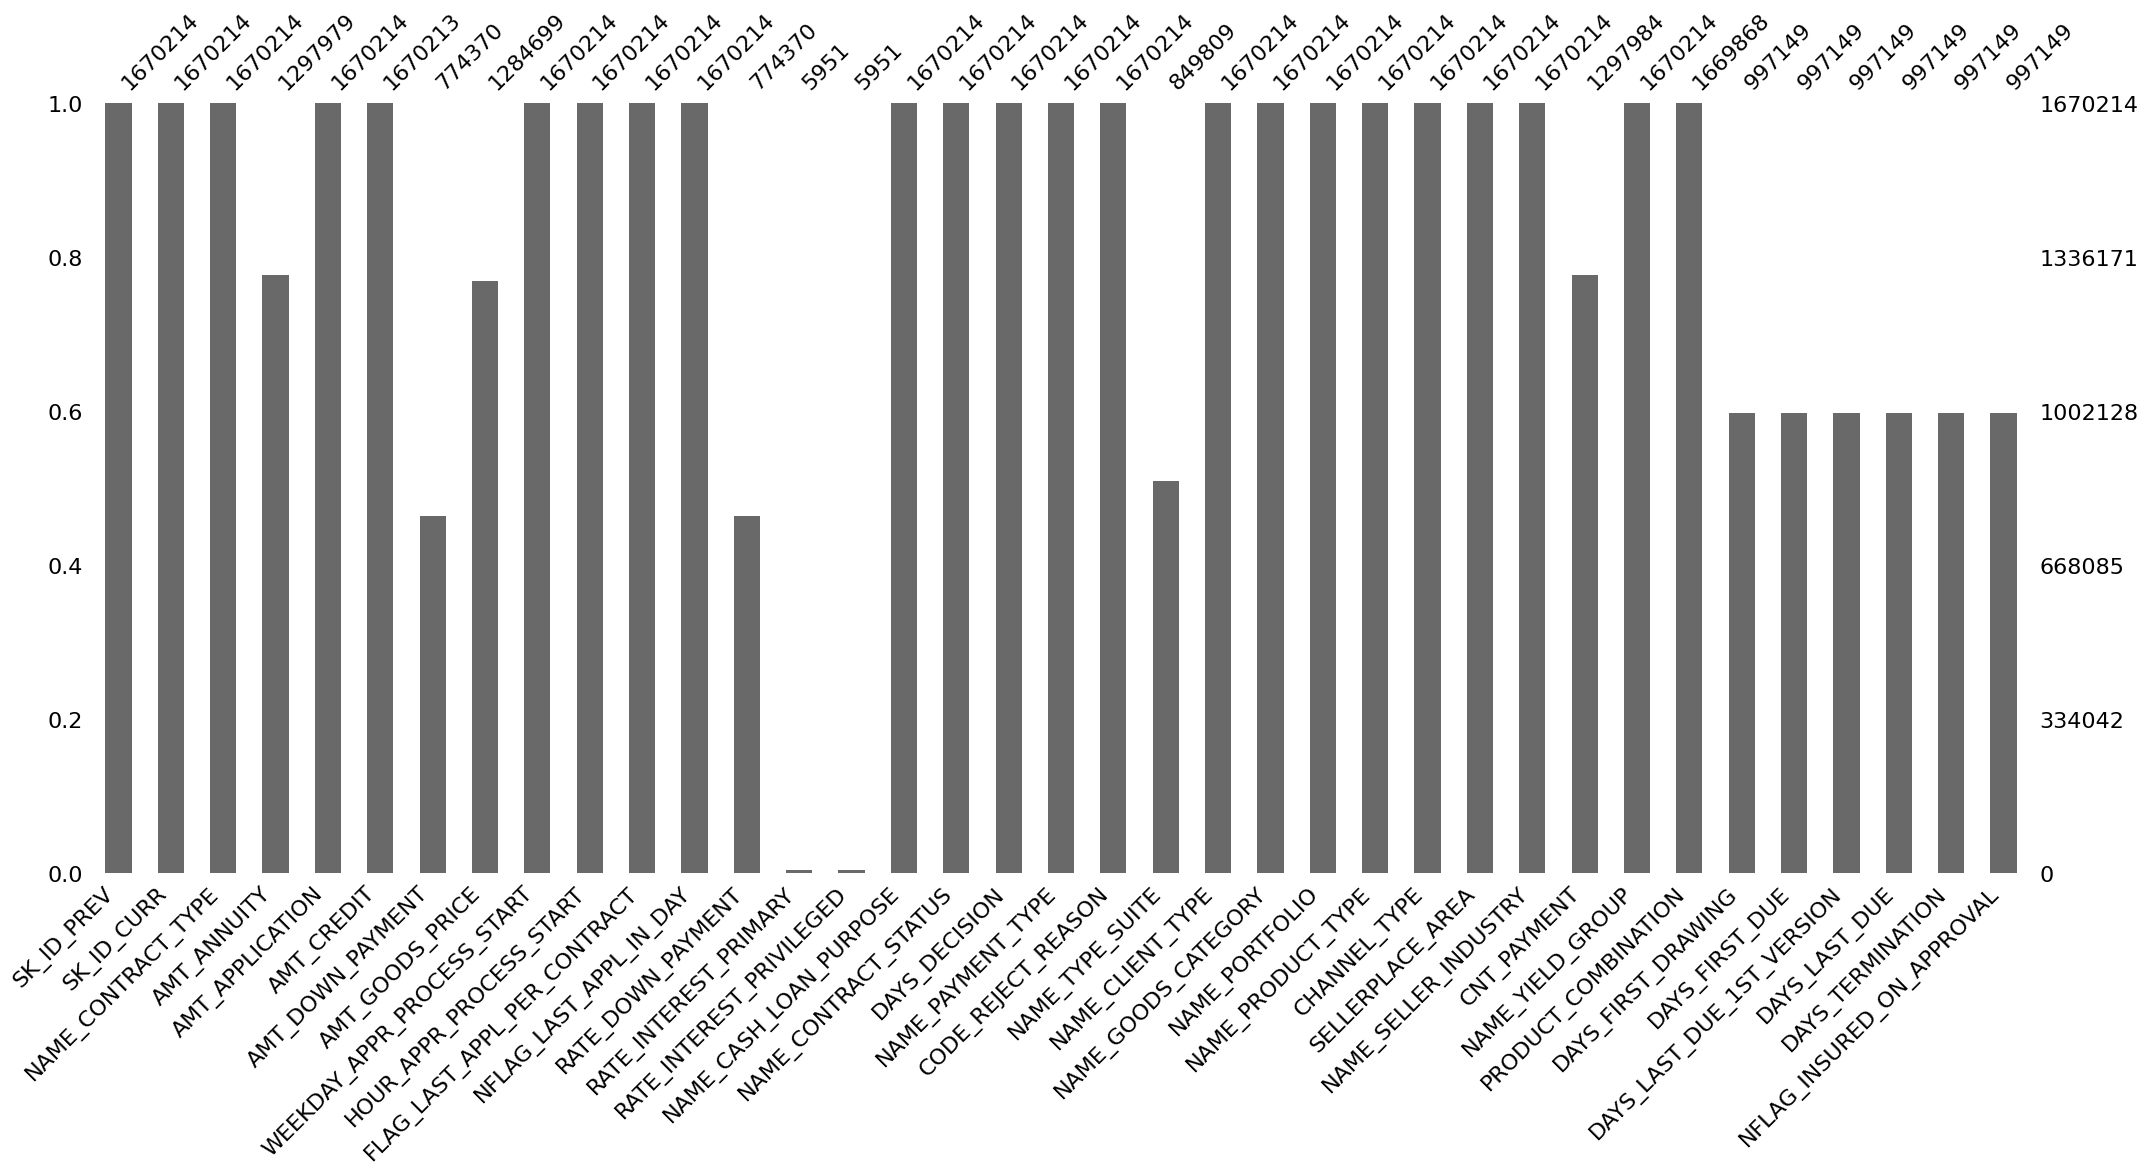

In [281]:
fonctions_data.description_dataset(previous_application, 'previous_application data')

<Axes: title={'center': 'Répartition des types de colonnes'}>

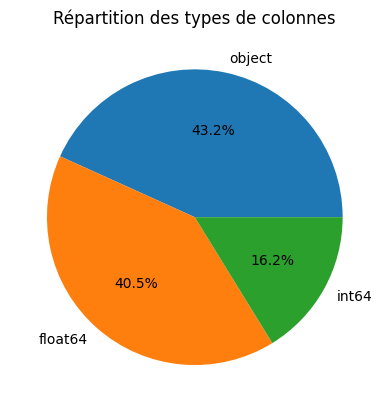

In [270]:
# Types des variables
previous_application.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

In [494]:
previous_application = fonctions_data.reduce_mem_usage(previous_application, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 471.48 MB
Memory usage après optimization: 309.01 MB
Diminution de 34.5%
-------------------------------------------------------------------------------


<Axes: title={'center': 'Répartition des types de colonnes'}>

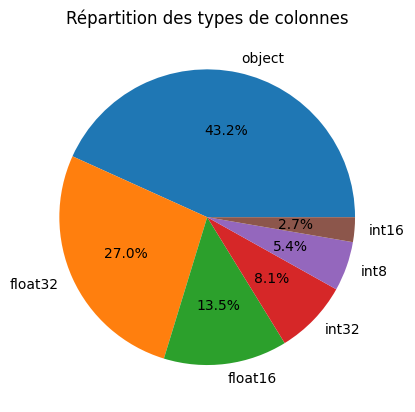

In [272]:
# Types des variables
previous_application.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### <span style='background:Moccasin'>4.4.2. Valeurs aberrantes</span>

**NAME_CONTRACT_STATUS**

In [495]:
name_contract_dict = {'Approved': 0,
                      'Refused': 3,
                      'Canceled': 2,
                      'Unused offer': 1}
previous_application['NAME_CONTRACT_STATUS'] = previous_application[
    'NAME_CONTRACT_STATUS'].map(name_contract_dict)

**NAME_YIELD_GROUP**

In [496]:
yield_group_dict = {'XNA': 0,
                    'low_action': 1,
                    'low_normal': 2,
                    'middle': 3,
                    'high': 4}
previous_application['NAME_YIELD_GROUP'] = previous_application[
    'NAME_YIELD_GROUP'].map(yield_group_dict)

**FLAG_LAST_APPL_PER_CONTRACT**

In [497]:
appl_per_contract_last_dict = {'Y': 1,
                               'N': 0}
previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = previous_application[
    'FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)

#### <span style='background:Moccasin'>4.4.3. Feature Engineering</span>

**Feature engineering**
- Création de nouvelles variables simples
- Catégorisation des variables binaires
- Imputation des valeurs manquantes
- Encodage des variables catégorielles
- Normalisation des variables numériques

In [498]:
def prv_application():
    
    prev_application = previous_application

    prev_application, cat_cols = one_hot_encoder(prev_application, nan_as_category=True)

        # Ratio : montant de crédit demandé lors de la demande précédente \
    #         Montant final du crédit sur la demande précédente
    prev_application['AMT_CREDIT_APPLICATION_RATIO'] = prev_application[
        'AMT_APPLICATION'] / (prev_application['AMT_CREDIT'] + 0.00001)
    # Différence : montant de crédit demandé lors de la demande précédente -
    #              Montant final du crédit sur la demande précédente
    prev_application['AMT_DECLINED'] = prev_application[
        'AMT_APPLICATION'] - prev_application['AMT_CREDIT']
    
    # Ratio : Montant final du crédit sur la demande précédente \
    #         Prix du bien demandé (le cas échéant) sur la demande précédente
    prev_application['AMT_CREDIT_GOODS_RATIO'] = prev_application[
        'AMT_CREDIT'] / (prev_application['AMT_GOODS_PRICE'] + 0.00001)
    # Différence : Montant final du crédit sur la demande précédente
    #              Prix du bien demandé (le cas échéant) sur la demande
    #              précédente
    prev_application['AMT_CREDIT_GOODS_DIFF'] = prev_application[
        'AMT_CREDIT'] - prev_application['AMT_GOODS_PRICE']
    
    # Ratio : Acompte sur la demande précédente \
    #         Montant final du crédit sur la demande précédente
    prev_application['CREDIT_DOWNPAYMENT_RATIO'] = prev_application[
        'AMT_DOWN_PAYMENT'] / (prev_application['AMT_CREDIT'] + 0.00001)
    
    # Ratio : Acompte sur la demande précédente \
    #         Prix du bien demandé (le cas échéant) sur la demande précédente
    prev_application['GOOD_DOWNPAYMET_RATIO'] = prev_application[
        'AMT_DOWN_PAYMENT'] / (prev_application['AMT_GOODS_PRICE'] + 0.00001)
    
    # Multiplication : Taux d'acompte normalisé sur le crédit antérieur,
    #                  Acompte sur la demande précédente
    prev_application['INTEREST_DOWNPAYMENT'] = prev_application[
        'RATE_DOWN_PAYMENT'] * prev_application['AMT_DOWN_PAYMENT']
    
    # Multiplication : Montant final du crédit sur la demande précédente
    #                  Taux d'intérêt normalisé sur le crédit antérieur
    prev_application['INTEREST_CREDIT'] = prev_application[
        'AMT_CREDIT'] * prev_application['RATE_INTEREST_PRIMARY']
    
    # Multiplication : Montant final du crédit sur la demande précédente
    #                  Taux d'intérêt normalisé sur le crédit antérieur
    prev_application['INTEREST_CREDIT_PRIVILEGED'] = prev_application[
        'AMT_CREDIT'] * prev_application['RATE_INTEREST_PRIVILEGED']
    
    # Ratio : montant de crédit demandé lors de la demande précédente \
    #         nombre de jours pour prendre la décision
    prev_application['APPLICATION_AMT_TO_DECISION_RATIO'] = \
        prev_application['AMT_APPLICATION'] / (prev_application[
            'DAYS_DECISION'] + 0.00001) * -1
    
    # Ratio : montant de crédit demandé lors de la demande précédente \
    #         Zone de vente du vendeur
    prev_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = \
        prev_application['AMT_APPLICATION'] / (prev_application[
            'SELLERPLACE_AREA'] + 0.00001)
    
    # Ratio : Montant final du crédit sur la demande précédente \
    #         Durée du crédit précédent à la demande de la demande précédente
    prev_application['ANNUITY'] = prev_application['AMT_CREDIT'] / \
        (prev_application['CNT_PAYMENT'] + 0.00001)
    
    # Ratio : Prix du bien demandé (le cas échéant) sur la demande précédente
    #         Durée du crédit précédent
    prev_application['ANNUITY_GOODS'] = prev_application[
            'AMT_GOODS_PRICE'] / (prev_application['CNT_PAYMENT'] + 0.00001)
    
    # Différence : Par rapport à la date de demande de la demande actuelle
    #              quelle était la première échéance de la demande précédente? \
    #              Par rapport à la date d'application de l'application
    #              actuelle quand la première échéance était-elle censée être
    #              celle de l'application précédente ?
    prev_application['DAYS_FIRST_LAST_DUE_DIFF'] = prev_application[
        'DAYS_LAST_DUE'] - prev_application['DAYS_FIRST_DUE']
    
    # Multiplication : Montant final du crédit sur la demande précédente *
    #                  Indicateur indiquant si la demande était la dernière
    #                  demande par jour du client
    prev_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = \
        prev_application['AMT_CREDIT'] * prev_application[
        'NFLAG_LAST_APPL_IN_DAY']
    
    # Multiplication : Montant final du crédit sur la demande précédente *
    #                  Taux d'intérêt groupé en petit moyen et élevé de la
    #                  demande précédente
    prev_application['AMT_CREDIT_YIELD_GROUP'] = prev_application[
        'AMT_CREDIT'] * prev_application['NAME_YIELD_GROUP']
    
    # Ratio : Annuité de prêt /
    #         Montant final du crédit sur la demande précédente
    prev_application['LOAN_RATE'] = prev_application[
        'AMT_ANNUITY'] / prev_application['AMT_CREDIT']
    
    # https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
    prev_application['AMT_INTEREST'] = prev_application[
        'CNT_PAYMENT'] * prev_application[
        'AMT_ANNUITY'] - prev_application['AMT_CREDIT']
    prev_application['INTEREST_SHARE'] = prev_application[
        'AMT_INTEREST'] / (prev_application['AMT_CREDIT'] + 0.00001)
    prev_application['INTEREST_RATE'] = 2 * 12 * prev_application[
        'AMT_INTEREST'] / (prev_application[
            'AMT_CREDIT'] * (prev_application['CNT_PAYMENT'] + 1))
    

    num_aggregations = {'AMT_ANNUITY' : ['mean', 'sum', 'min', 'max'],
                 'AMT_APPLICATION' : ['mean', 'sum', 'min', 'max'],
                 'AMT_CREDIT' : ['mean', 'sum', 'min', 'max'],
                 'AMT_DOWN_PAYMENT' : ['mean', 'max', 'sum'],
                 'AMT_GOODS_PRICE' : ['mean', 'sum', 'min', 'max'],
                 'HOUR_APPR_PROCESS_START' : ['mean', 'min', 'max'],
                 'FLAG_LAST_APPL_PER_CONTRACT' : ['mean', 'sum'],
                 'NFLAG_LAST_APPL_IN_DAY' : ['mean', 'sum'],
                 'RATE_DOWN_PAYMENT' : ['mean', 'min', 'max'],
                 'RATE_INTEREST_PRIMARY' : ['mean', 'max'],
                 'RATE_INTEREST_PRIVILEGED' : ['mean', 'max'],
                 'NAME_CONTRACT_STATUS' : ['mean', 'max', 'last'],
                 'DAYS_DECISION' : ['mean', 'min', 'max'],
                 'SELLERPLACE_AREA' : ['mean', 'max', 'min', 'sum'],
                 'CNT_PAYMENT' : ['sum', 'mean', 'max'],
                 'NAME_YIELD_GROUP' : ['mean', 'last'],
                 'DAYS_FIRST_DRAWING' : ['mean', 'max'],
                 'DAYS_FIRST_DUE' : ['mean', 'max', 'sum'],
                 'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
                 'DAYS_LAST_DUE' : ['mean', 'max'],
                 'DAYS_TERMINATION' : ['mean', 'max'],
                 'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
                 # Nouvelles Features
                 'AMT_DECLINED' : ['mean','max', 'sum'],
                 'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
                 'AMT_CREDIT_GOODS_DIFF' : ['sum', 'mean', 'max', 'min'],
                 'AMT_CREDIT_APPLICATION_RATIO' : ['mean', 'min'],
                 'CREDIT_DOWNPAYMENT_RATIO' : ['mean', 'max'],
                 'GOOD_DOWNPAYMET_RATIO' : ['mean', 'max'],
                 'INTEREST_DOWNPAYMENT' : ['mean', 'sum', 'max'],
                 'INTEREST_CREDIT' : ['mean', 'sum', 'max'],
                 'INTEREST_CREDIT_PRIVILEGED' : ['mean', 'sum', 'max'],
                 'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean', 'min'],
                 'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean', 'max'],
                 'ANNUITY' : ['mean', 'sum', 'max'],
                 'ANNUITY_GOODS' : ['mean', 'sum', 'max'],
                 'LOAN_RATE': ['max', 'mean'],
                 'DAYS_FIRST_LAST_DUE_DIFF' : ['mean', 'max'],
                 'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean', 'max'],
                 'AMT_CREDIT_YIELD_GROUP' : ['mean', 'sum', 'min'],
                 'AMT_INTEREST' : ['mean', 'sum', 'max', 'min'],
                 'INTEREST_SHARE' : ['mean', 'max', 'min'],
                 'INTEREST_RATE' : ['mean', 'max', 'min']}
    

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    print('"Previous Applications" final shape:', prev_agg.shape)
    return prev_agg

In [499]:
previous_application_fe = prv_application()

"Previous Applications" final shape: (338857, 258)


In [500]:
previous_application_fe.head()

PREV_AMT_ANNUITY_MEAN  PREV_AMT_ANNUITY_SUM  PREV_AMT_ANNUITY_MIN  \
SK_ID_CURR                                                                      
100001                3951.000000           3951.000000           3951.000000   
100002                9251.775391           9251.775391           9251.775391   
100003               56553.988281         169661.968750           6737.310059   
100004                5357.250000           5357.250000           5357.250000   
100005                4813.200195           4813.200195           4813.200195   

            PREV_AMT_ANNUITY_MAX  PREV_AMT_APPLICATION_MEAN  \
SK_ID_CURR                                                    
100001               3951.000000                   24835.50   
100002               9251.775391                  179055.00   
100003              98356.992188                  435436.50   
100004               5357.250000                   24282.00   
100005               4813.200195                   22308.75   

            PREV_AMT_APPLICATION_SUM  PREV_AMT_APPLICATION_MIN  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                     1306309.5                   68809.5   
100004                       24282.0                   24282.0   
100005                       44617.5                       0.0   

            PREV_AMT_APPLICATION_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                                   
100001                       24835.5              23787.00   
100002                      179055.0             179055.00   
100003                      900000.0             484191.00   
100004                       24282.0              20106.00   
100005                       44617.5              20076.75   

            PREV_AMT_CREDIT_SUM  ...  \
SK_ID_CURR                       ...   
100001                  23787.0  ...   
100002                 179055.0  ...   
100003                1452573.0  ...   
100004                  20106.0  ...   
100005                  40153.5  ...   

            PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN  \
SK_ID_CURR                                                      
100001                                                    0.0   
100002                                                    0.0   
100003                                                    0.0   
100004                                                    0.0   
100005                                                    0.0   

            PREV_PRODUCT_COMBINATION_POS household with interest_MEAN  \
SK_ID_CURR                                                              
100001                                               0.000000           
100002                                               0.000000           
100003                                               0.333333           
100004                                               0.000000           
100005                                               0.000000           

            PREV_PRODUCT_COMBINATION_POS household without interest_MEAN  \
SK_ID_CURR                                                                 
100001                                                    0.0              
100002                                                    0.0              
100003                                                    0.0              
100004                                                    0.0              
100005                                                    0.0              

            PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN  \
SK_ID_CURR                                                             
100001                                               0.000000          
100002                                               0.000000          
100003                            

#### <span style='background:Moccasin'>4.4.4. Assemblage avec le 'train set'</span>

In [501]:
features_set = features_set.merge(previous_application_fe, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with bureau:', features_set.shape)

--=> features_set after merge with bureau: (307507, 579)


In [502]:
# Description
fonctions_data.detail_type_var(features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float16     float16      float16         float16   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count            307507.0    307507.0     307507.0        307507.0   
mean                  0.0         NaN          NaN             NaN   
std                   0.0         0.0          0.0             0.0   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          1.0             0.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type        float16          float16    float16     float16   
nb_nan          0.0              0.0        0.0         0.0   
%_nan           0.0              0.0        0.0         0.0   
count      307507.0         307507.0   307507.0    307507.0   
mean            0.0              0.0        0.0         0.0   
std             0.0              0.0        0.0         0.0   
min             0.0              0.0        0.0         0.0   
25%             0.0         0.000742   0.056183    0.058136   
50%             0.0         0.001039   0.117004     0.09082   
75%        0.052643         0.001512   0.190674    0.128662   
max             1.0              1.0        1.0         1.0   

       REGION_POPULATION_RELATIVE DAYS_BIRTH  ...  \
type                      float16    float16  ...   
nb_nan                        0.0        0.0  ...   
%_nan                         0.0        0.0  ...   
count                    307507.0   307507.0  ...   
mean                          NaN        NaN  ...   
std                           0.0        0.0  ...   
min                           0.0        0.0  ...   
25%                      0.134644   0.312744  ...   
50%                      0.256836    0.53418  ...   
75%                      0.392822   0.722656  ...   
max                           1.0        1.0  ...   

       PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN  \
type                                             float64   
nb_nan                                           16454.0   
%_nan                                           5.350773   
count                                           291053.0   
mean                                            0.062555   
std                                             0.133853   
min                                                  0.0   
25%                                                  0.0   
50%                                                  0.0   
75%                                                  0.0   
max                                                  1.0   

       PREV_PRODUCT_COMBINATION_POS household with interest_MEAN  \
type                                              float64          
nb_nan                                            16454.0          
%_nan                                            5.350773          
count                                            291053.0          
mean                                             0.206853          
std                                              0.293253          
min                                                   0.0          
25%                                                   0.0          
50%                                                   0.0          
75%                                              0.333333          
max                                                   1.0          

       PREV_PRODUCT_COMBINATION_POS household without interest_MEAN  \
type                                              float64             
nb_nan                                            16454.0             
%_nan                

#### <span style='background:Moccasin'>4.4.5. Assemblage avec le 'test set'</span>

In [503]:
test_features_set = test_features_set.merge(previous_application_fe, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with bureau:', test_features_set.shape)

--=> features_set after merge with bureau: (48744, 570)


In [504]:
# Description
fonctions_data.detail_type_var(test_features_set, type_var='all')

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
type              float16     float16      float16         float16   
nb_nan                0.0         0.0          0.0             0.0   
%_nan                 0.0         0.0          0.0             0.0   
count             48744.0     48744.0      48744.0         48744.0   
mean              0.00901     0.32959     0.337158        0.690918   
std              0.094482    0.470215       0.4729        0.462402   
min                   0.0         0.0          0.0             0.0   
25%                   0.0         0.0          0.0             0.0   
50%                   0.0         0.0          0.0             1.0   
75%                   0.0         1.0          1.0             1.0   
max                   1.0         1.0          1.0             1.0   

       CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type        float16          float16    float16     float16   
nb_nan          0.0              0.0        0.0         0.0   
%_nan           0.0              0.0        0.0         0.0   
count       48744.0          48744.0    48744.0     48744.0   
mean       0.020905         0.001307   0.117798    0.108521   
std        0.037323          0.00088   0.091248    0.062439   
min             0.0         0.000011        0.0    0.002649   
25%             0.0         0.000742   0.053833    0.063782   
50%             0.0         0.001127   0.101135    0.095886   
75%        0.052643         0.001704   0.157349    0.139526   
max        1.052734         0.037476   0.549316    0.697754   

       REGION_POPULATION_RELATIVE DAYS_BIRTH  ...  \
type                      float16    float16  ...   
nb_nan                        0.0        0.0  ...   
%_nan                         0.0        0.0  ...   
count                     48744.0    48744.0  ...   
mean                     0.290039   0.516602  ...   
std                      0.199829   0.243896  ...   
min                     -0.000511   0.001917  ...   
25%                      0.134521   0.315186  ...   
50%                       0.25708   0.532227  ...   
75%                      0.392822   0.717773  ...   
max                           1.0   1.008789  ...   

       PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN  \
type                                             float64   
nb_nan                                             944.0   
%_nan                                           1.936649   
count                                            47800.0   
mean                                            0.068399   
std                                             0.133501   
min                                                  0.0   
25%                                                  0.0   
50%                                                  0.0   
75%                                                  0.1   
max                                                  1.0   

       PREV_PRODUCT_COMBINATION_POS household with interest_MEAN  \
type                                              float64          
nb_nan                                              944.0          
%_nan                                            1.936649          
count                                             47800.0          
mean                                             0.190043          
std                                              0.278383          
min                                                   0.0          
25%                                                   0.0          
50%                                                   0.0          
75%                                              0.285714          
max                                                   1.0          

       PREV_PRODUCT_COMBINATION_POS household without interest_MEAN  \
type                                              float64             
nb_nan                                              944.0             
%_nan                

#### <span style='background:Moccasin'>4.4.6. Nettoyage</span>

<span style='background:mistyrose'>**Réduction mémoire des dataframes**</span>

In [505]:
features_set = fonctions_data.reduce_mem_usage(features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 730.51 MB
Memory usage après optimization: 415.55 MB
Diminution de 43.1%
-------------------------------------------------------------------------------


In [506]:
test_features_set = fonctions_data.reduce_mem_usage(test_features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 114.82 MB
Memory usage après optimization: 64.71 MB
Diminution de 43.6%
-------------------------------------------------------------------------------


<span style='background:mistyrose'>**Variables fortement corrélées**</span>

In [507]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_features_set = fonctions_data.suppr_var_colineaire(features_set)

80 variables fortement corrélées à supprimer :

PREV_AMT_ANNUITY_MAX
PREV_AMT_APPLICATION_SUM
PREV_AMT_APPLICATION_MAX
PREV_AMT_CREDIT_MEAN
PREV_AMT_CREDIT_SUM
PREV_AMT_CREDIT_MIN
PREV_AMT_CREDIT_MAX
PREV_AMT_DOWN_PAYMENT_MAX
PREV_AMT_DOWN_PAYMENT_SUM
PREV_AMT_GOODS_PRICE_MEAN
PREV_AMT_GOODS_PRICE_SUM
PREV_AMT_GOODS_PRICE_MAX
PREV_HOUR_APPR_PROCESS_START_MIN
PREV_HOUR_APPR_PROCESS_START_MAX
PREV_NFLAG_LAST_APPL_IN_DAY_SUM
PREV_RATE_DOWN_PAYMENT_MIN
PREV_RATE_DOWN_PAYMENT_MAX
PREV_RATE_INTEREST_PRIMARY_MAX
PREV_RATE_INTEREST_PRIVILEGED_MAX
PREV_NAME_CONTRACT_STATUS_MAX
PREV_DAYS_DECISION_MIN
PREV_SELLERPLACE_AREA_MIN
PREV_SELLERPLACE_AREA_SUM
PREV_CNT_PAYMENT_SUM
PREV_CNT_PAYMENT_MAX
PREV_DAYS_FIRST_DUE_MAX
PREV_DAYS_FIRST_DUE_SUM
PREV_DAYS_LAST_DUE_1ST_VERSION_MEAN
PREV_DAYS_TERMINATION_MEAN
PREV_DAYS_TERMINATION_MAX
PREV_AMT_DECLINED_MAX
PREV_AMT_CREDIT_GOODS_DIFF_MIN
PREV_CREDIT_DOWNPAYMENT_RATIO_MEAN
PREV_CREDIT_DOWNPAYMENT_RATIO_MAX
PREV_GOOD_DOWNPAYMET_RATIO_MEAN
PREV_GOOD_DOWNPAY

In [510]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_test_features_set = fonctions_data.suppr_var_colineaire(test_features_set)

82 variables fortement corrélées à supprimer :

PREV_AMT_ANNUITY_MAX
PREV_AMT_APPLICATION_SUM
PREV_AMT_CREDIT_MEAN
PREV_AMT_CREDIT_SUM
PREV_AMT_CREDIT_MIN
PREV_AMT_CREDIT_MAX
PREV_AMT_DOWN_PAYMENT_MAX
PREV_AMT_DOWN_PAYMENT_SUM
PREV_AMT_GOODS_PRICE_MEAN
PREV_AMT_GOODS_PRICE_SUM
PREV_AMT_GOODS_PRICE_MAX
PREV_HOUR_APPR_PROCESS_START_MIN
PREV_HOUR_APPR_PROCESS_START_MAX
PREV_NFLAG_LAST_APPL_IN_DAY_SUM
PREV_RATE_DOWN_PAYMENT_MIN
PREV_RATE_DOWN_PAYMENT_MAX
PREV_RATE_INTEREST_PRIMARY_MAX
PREV_RATE_INTEREST_PRIVILEGED_MAX
PREV_NAME_CONTRACT_STATUS_MAX
PREV_DAYS_DECISION_MIN
PREV_SELLERPLACE_AREA_MIN
PREV_SELLERPLACE_AREA_SUM
PREV_CNT_PAYMENT_SUM
PREV_CNT_PAYMENT_MAX
PREV_DAYS_FIRST_DUE_MAX
PREV_DAYS_FIRST_DUE_SUM
PREV_DAYS_TERMINATION_MEAN
PREV_DAYS_TERMINATION_MAX
PREV_AMT_DECLINED_MAX
PREV_AMT_CREDIT_GOODS_DIFF_MAX
PREV_AMT_CREDIT_GOODS_DIFF_MIN
PREV_AMT_CREDIT_APPLICATION_RATIO_MIN
PREV_CREDIT_DOWNPAYMENT_RATIO_MEAN
PREV_CREDIT_DOWNPAYMENT_RATIO_MAX
PREV_GOOD_DOWNPAYMET_RATIO_MEAN
PREV_GOOD

***Train set***

In [508]:
# Suppression des variables fortement corrélées du train set
features_set = features_set.drop(columns = var_corr_features_set)
print(f'train_set : {features_set.shape}')

train_set : (307507, 499)


***Test set***

In [511]:
# Suppression des variables fortement corrélées du train set
test_features_set = test_features_set.drop(columns = var_corr_test_features_set)
print(f'test_set : {test_features_set.shape}')

test_set : (48744, 488)


<span style='background:mistyrose'>**Imputation des données**</span>

***Train set***

Valeurs manquantes :4127204 NaN pour 160518654 données (2.57 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
PREV_RATE_INTEREST_PRIMARY_MEAN                                            302898   
PREV_INTEREST_CREDIT_MEAN                                                  302898   
PREV_INTEREST_CREDIT_PRIVILEGED_MEAN                                       302898   
PREV_RATE_INTEREST_PRIVILEGED_MEAN                                         302898   
PREV_RATE_DOWN_PAYMENT_MEAN                                                 33906   
...                                                                           ...   
PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN                                   16454   
PREV_NAME_CASH_LOAN_PURPOSE_Money for a third p...                          16454   
PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN                                      16454   
PREV_NAME_CASH_LOAN_PURPOSE_Payments on other l...                          16454   
PREV_PRODUCT_COMBINATION_POS others without int...                          16454   

                                                    % de valeurs manquantes  
PREV_RATE_INTEREST_PRIMARY_MEAN                                       98.50  
PREV_INTEREST_CREDIT_MEAN                                             98.50  
PREV_INTEREST_CREDIT_PRIVILEGED_MEAN                                  98.50  
PREV_RATE_INTEREST_PRIVILEGED_MEAN                                    98.50  
PREV_RATE_DOWN_PAYMENT_MEAN                                           11.03  
...                                                                     ...  
PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN                              5.35  
PREV_NAME_CASH_LOAN_PURPOSE_Money for a third p...                     5.35  
PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN                                 5.35  
PREV_NAME_CASH_LOAN_PURPOSE_Payments on other l...                     5.35  
PREV_PRODUCT_COMBINATION_POS others without int...                     5.35  

[178 rows x 2 columns]

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


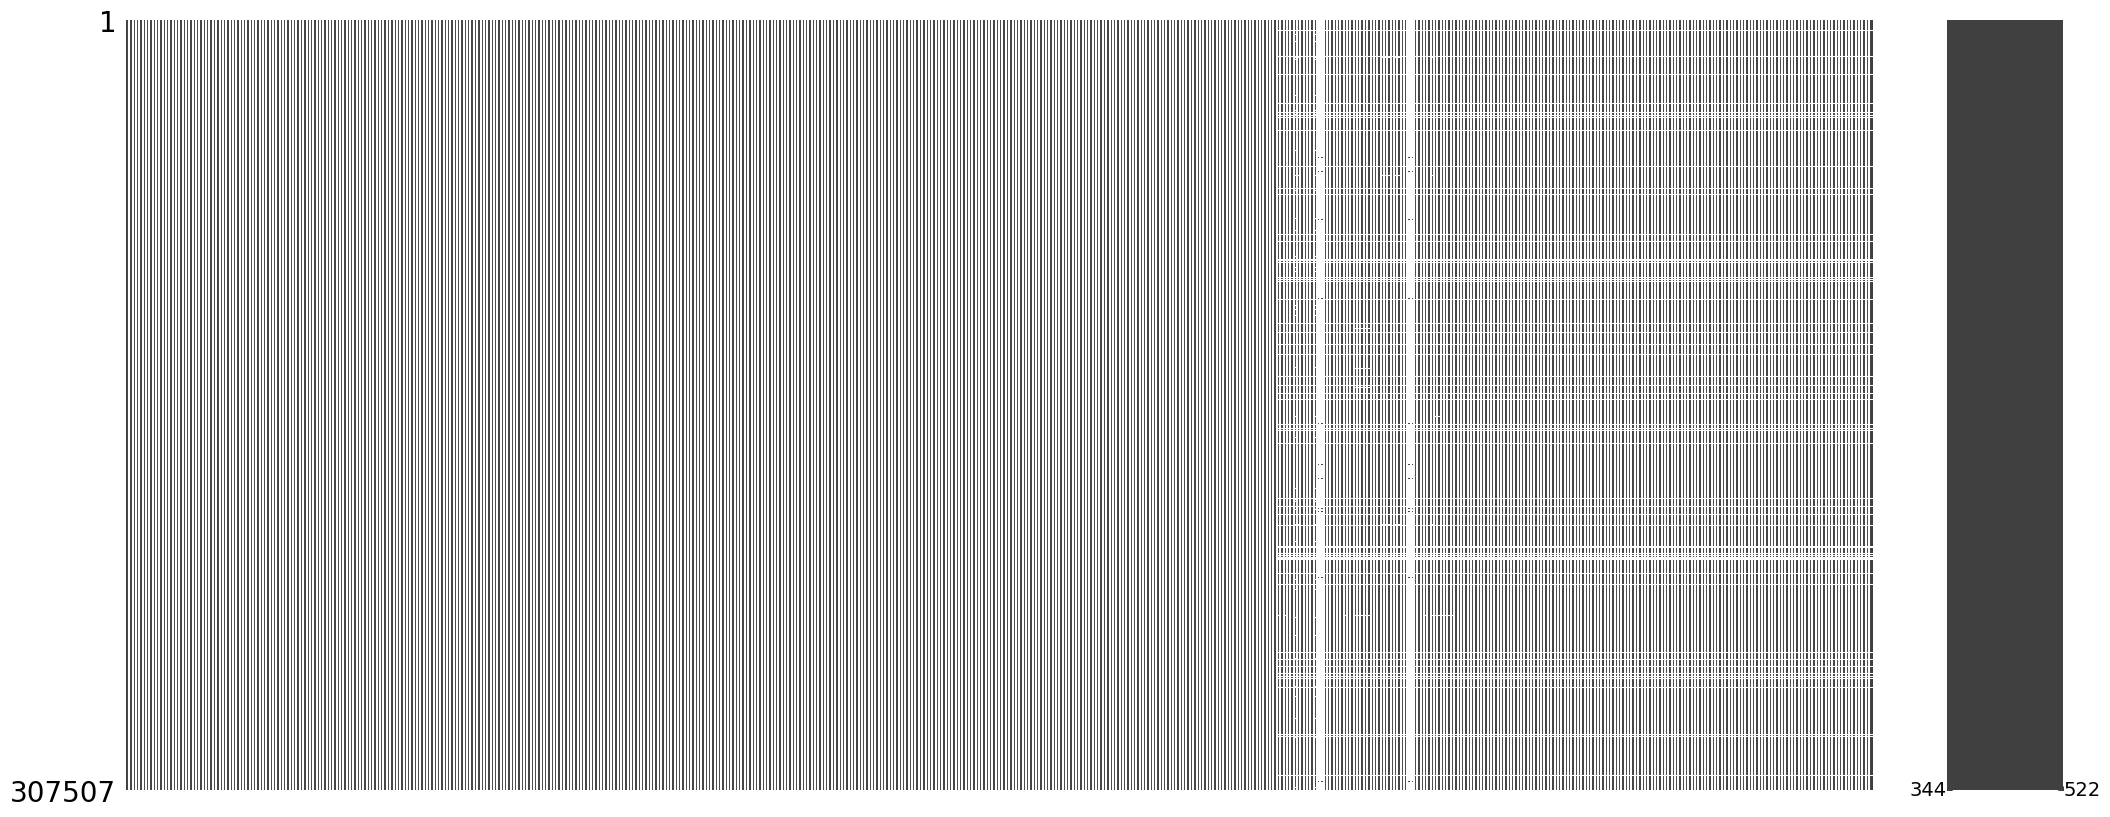

In [341]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [512]:
# Supprimer les colonnes avec uniquement des NaN
nb_nan = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_nan}')
features_set = features_set.dropna(axis=1, how='all')
# Vérification
nb_nan = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_nan}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 4127204
Nombre de nan ou valeurs nulles après suppression des champs vierges : 4127204


**Imputation par la médiane**

In [513]:
# Variables quantitatives - imputation par médiane
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
features_set.fillna(features_set.median(), inplace=True)

# Vérification
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 4127204
Nombre de nan après imputation par median : 0


In [514]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = features_set.columns[(features_set == 0).all()]
colonnes_nulles

Index(['PREV_NAME_CONTRACT_TYPE_nan_MEAN',
       'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN',
       'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN',
       'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN',
       'PREV_NAME_CLIENT_TYPE_nan_MEAN',
       'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
       'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN',
       'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN',
       'PREV_NAME_SELLER_INDUSTRY_nan_MEAN'],
      dtype='object')

In [515]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
features_set = features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = features_set.columns[(features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 12
Nombre de champs nulles après imputation: 0


**Imputation avec NaNImputer (Verstack)**

In [343]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = features_set.isna().sum().sum()

In [344]:
# Copie du jeu de données
X_nan = features_set.copy()

In [345]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.48289 seconds


In [346]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


Valeurs manquantes :0 NaN pour 160518654 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


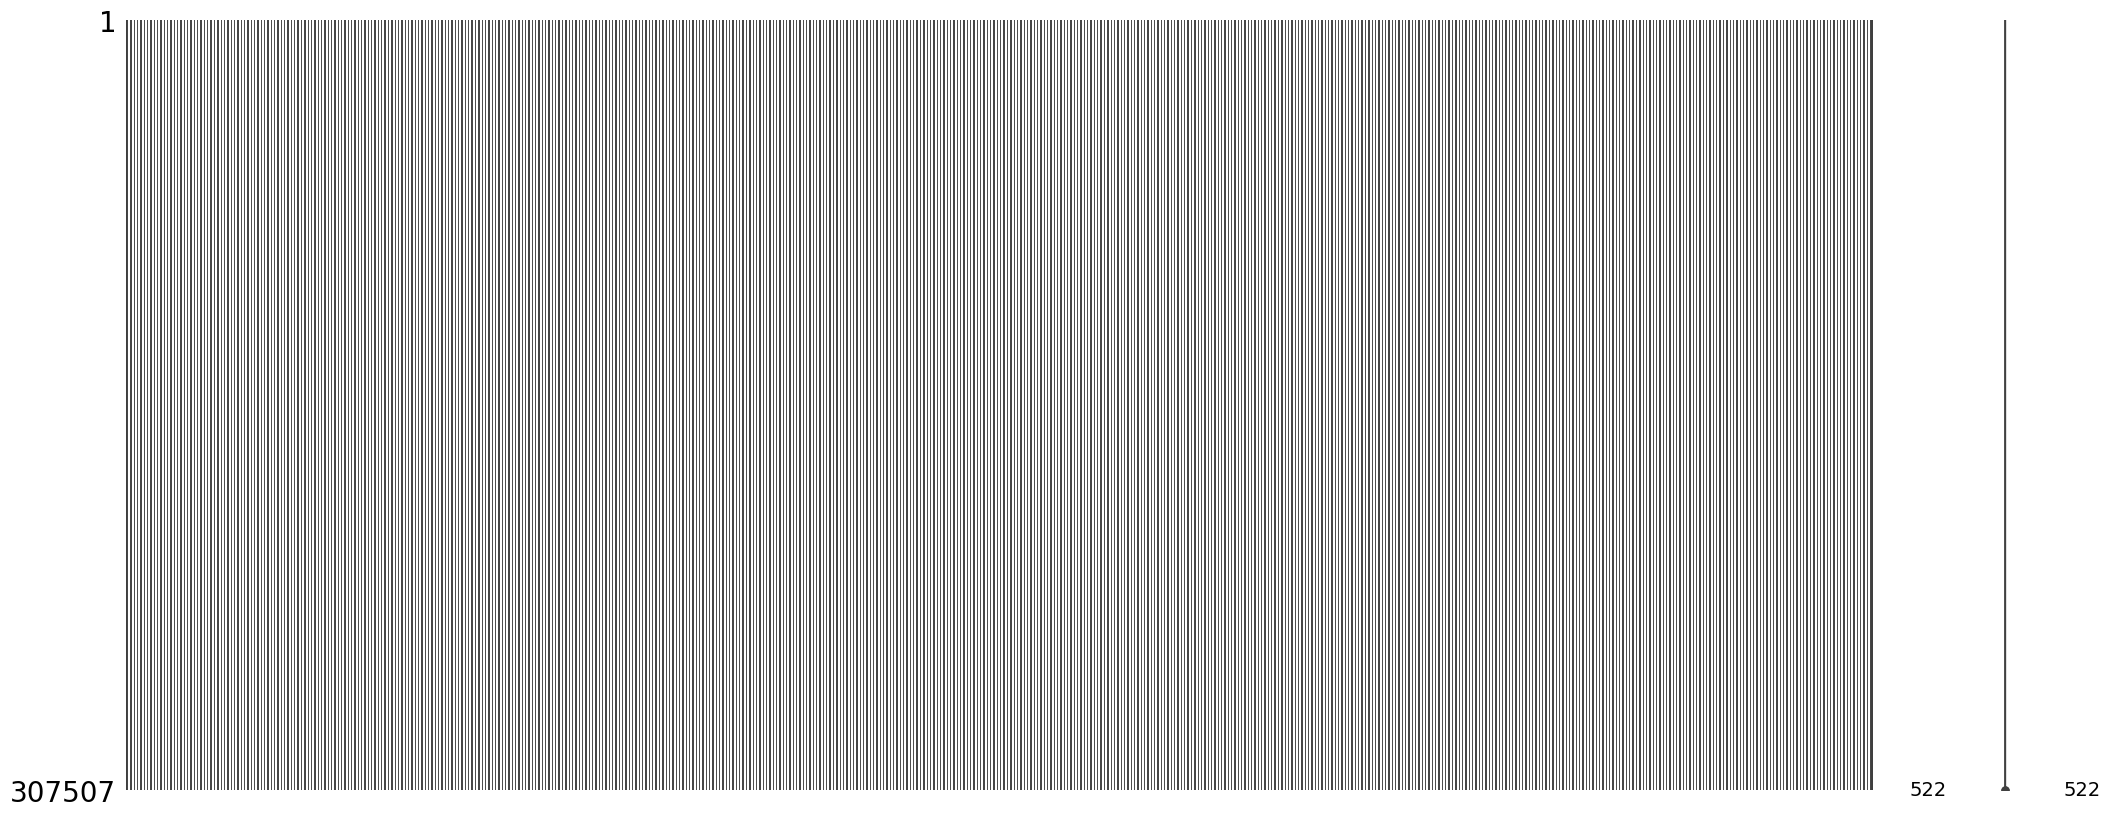

In [347]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

***Test set***

Valeurs manquantes :360730 NaN pour 25541856 données (1.41 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
PREV_INTEREST_CREDIT_PRIVILEGED_MEAN                                        47632   
PREV_INTEREST_CREDIT_MEAN                                                   47632   
PREV_RATE_INTEREST_PRIVILEGED_MEAN                                          47632   
PREV_RATE_INTEREST_PRIMARY_MEAN                                             47632   
PREV_RATE_DOWN_PAYMENT_MEAN                                                  3596   
...                                                                           ...   
PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN                                     944   
PREV_NAME_CASH_LOAN_PURPOSE_Money for a third p...                            944   
PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN                                        944   
PREV_NAME_CASH_LOAN_PURPOSE_Payments on other l...                            944   
PREV_PRODUCT_COMBINATION_POS others without int...                            944   

                                                    % de valeurs manquantes  
PREV_INTEREST_CREDIT_PRIVILEGED_MEAN                                  97.72  
PREV_INTEREST_CREDIT_MEAN                                             97.72  
PREV_RATE_INTEREST_PRIVILEGED_MEAN                                    97.72  
PREV_RATE_INTEREST_PRIMARY_MEAN                                       97.72  
PREV_RATE_DOWN_PAYMENT_MEAN                                            7.38  
...                                                                     ...  
PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN                              1.94  
PREV_NAME_CASH_LOAN_PURPOSE_Money for a third p...                     1.94  
PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN                                 1.94  
PREV_NAME_CASH_LOAN_PURPOSE_Payments on other l...                     1.94  
PREV_PRODUCT_COMBINATION_POS others without int...                     1.94  

[176 rows x 2 columns]

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


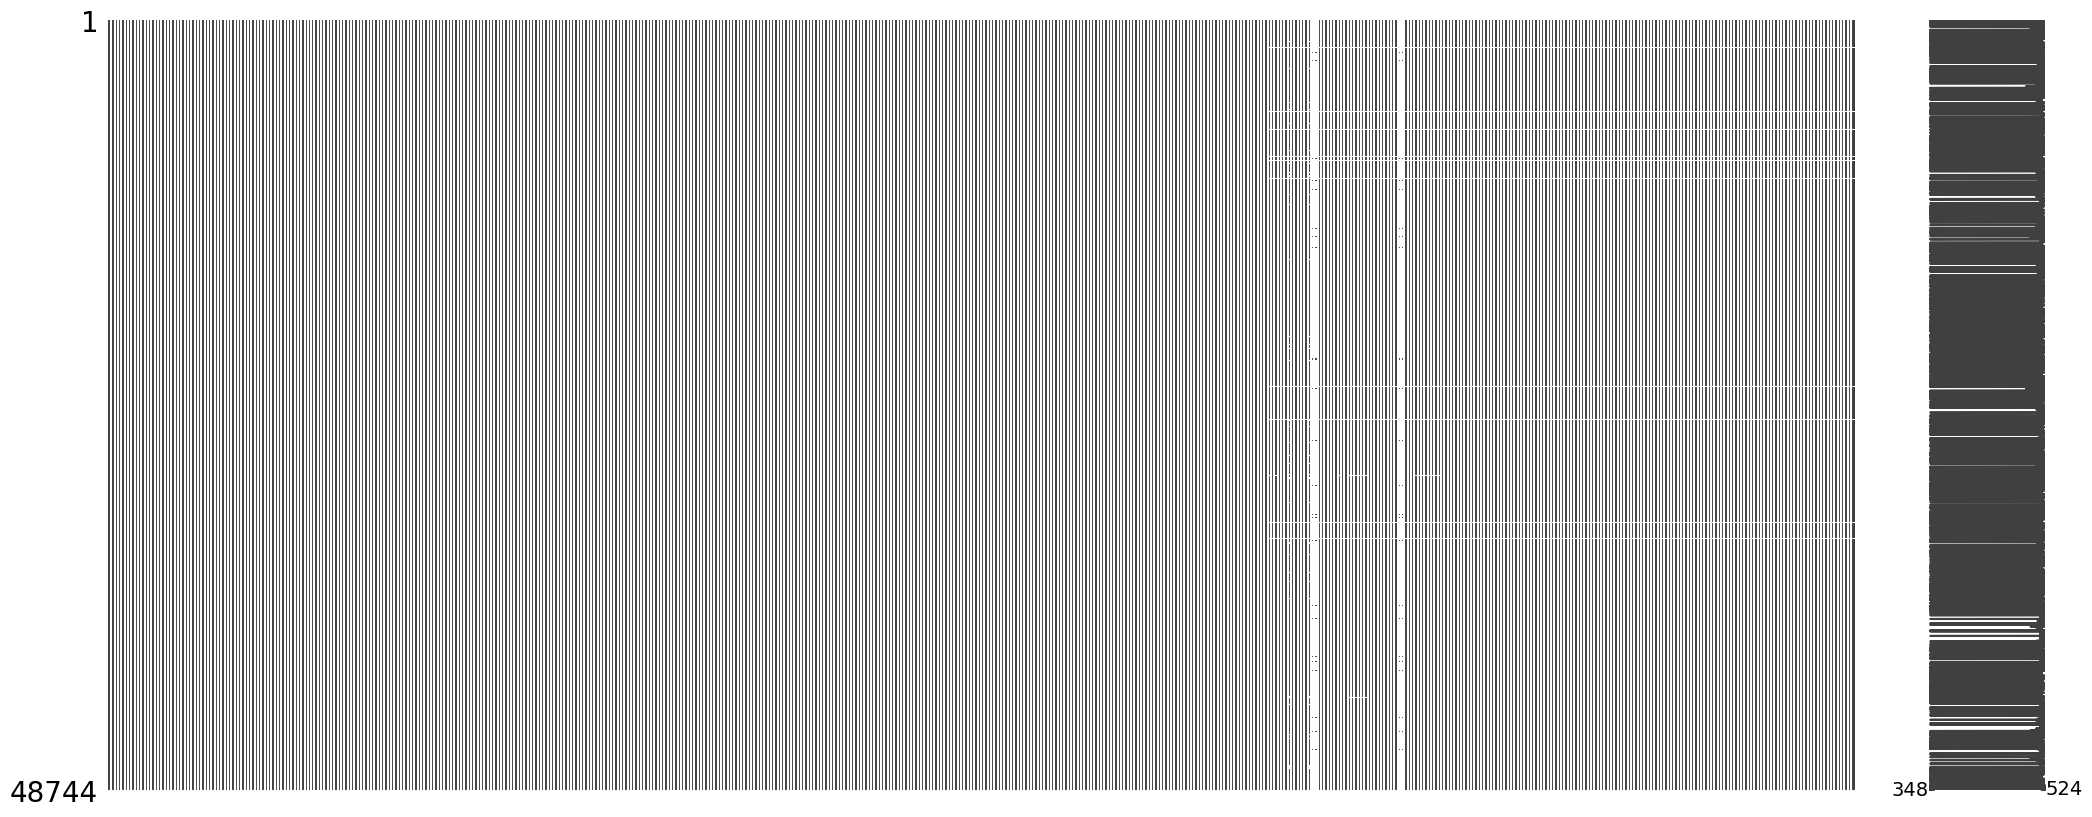

In [348]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [516]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
test_features_set = test_features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 360730
Nombre de nan ou valeurs nulles après suppression des champs vierges : 360730


**Imputation par la médiane**

In [517]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_features_set.fillna(test_features_set.median(), inplace=True)

# Vérification
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 360730
Nombre de nan après imputation par median : 0


In [518]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
colonnes_nulles

Index(['PREV_NAME_CONTRACT_TYPE_nan_MEAN',
       'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN',
       'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN',
       'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN',
       'PREV_NAME_CLIENT_TYPE_nan_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
       'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN',
       'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN',
       'PREV_NAME_SELLER_INDUSTRY_nan_MEAN'],
      dtype='object')

In [519]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
test_features_set = test_features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 12
Nombre de champs nulles après imputation: 0


**Imputation avec NaNImputer (Verstack)**

In [355]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features_set.isna().sum().sum()

In [356]:
# Copie du jeu de données
X_nan = test_features_set.copy()

In [357]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.12294 seconds


In [358]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


Valeurs manquantes :0 NaN pour 25541856 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


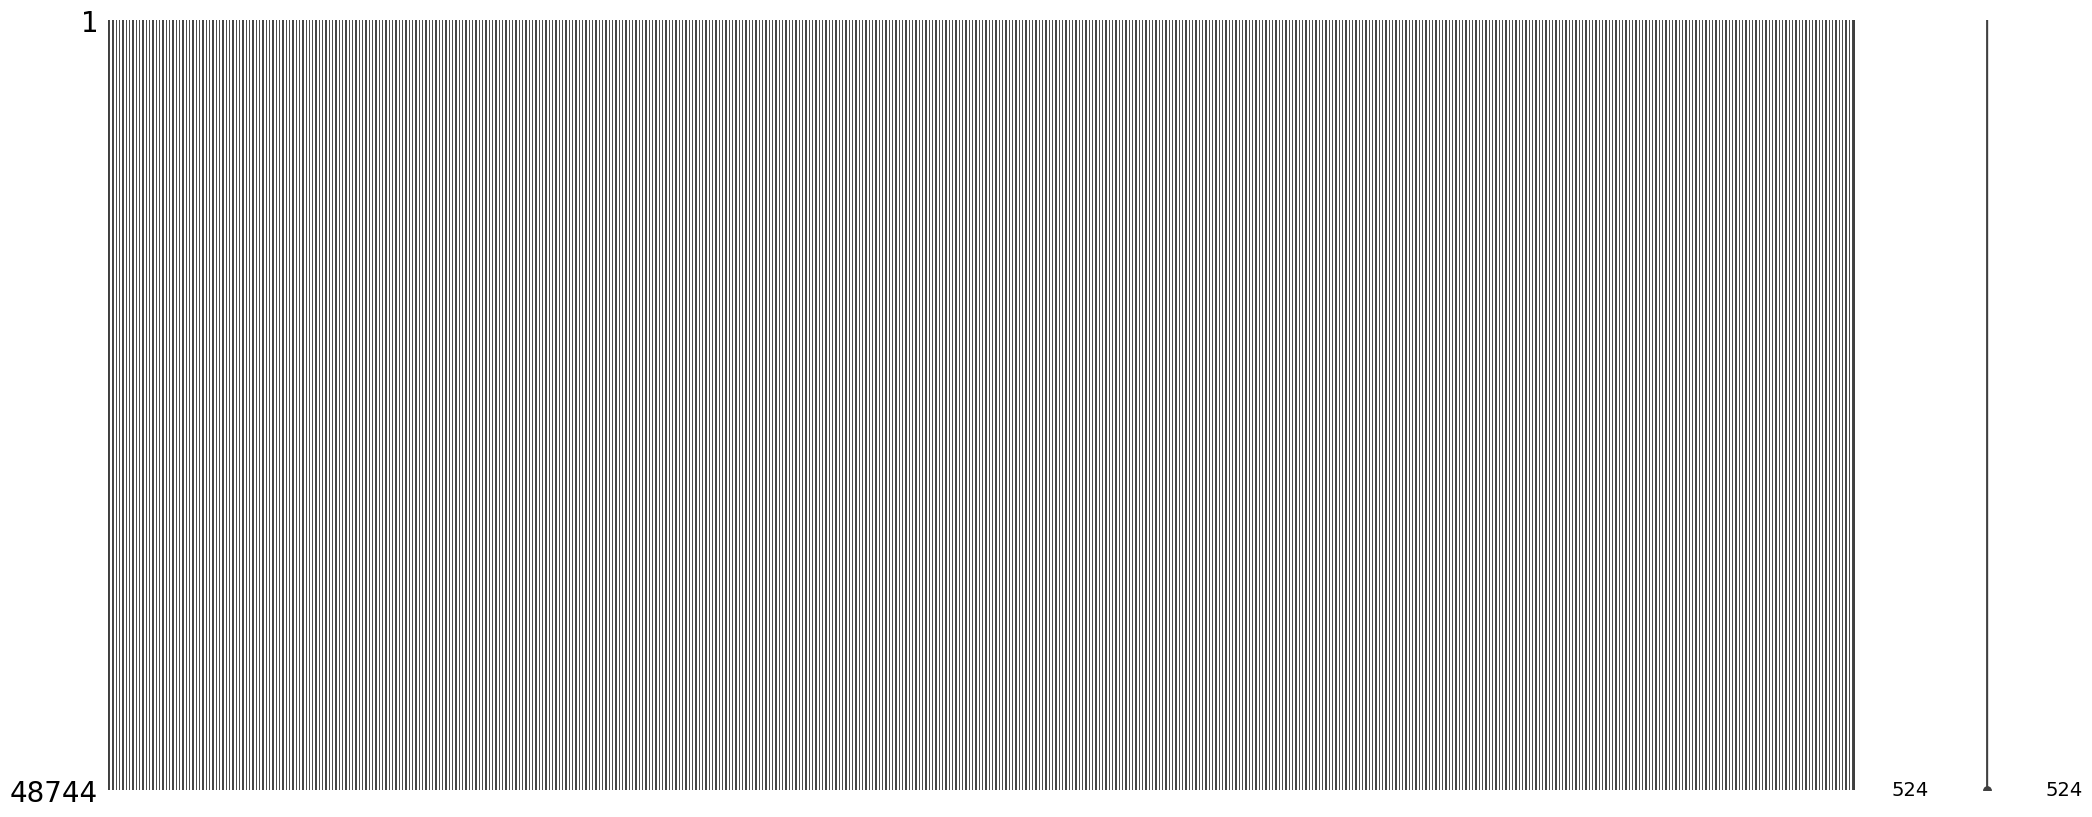

In [359]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

## <span style='background:PowderBlue'>5. Données de crédits annexes à Home Crédit Group</span>

Les 2 fichiers concernés par les prêts antérieurs dans d'autres organismes financiers autres que Home Crédit Group sont :
- **bureau.csv**,
- et **bureau_balance.csv**.

### <span style='background:orange'>5.1. Fichiers bureau_balance.csv</span>

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_BUREAU_ID**</p> | <p style='text-align: justify;'>ID recodé du crédit du Credit Bureau (codage unique pour chaque demande) => à utiliser pour rejoindre la table CREDIT_BUREAU.</p> |  |
| <p style='text-align: justify;'>**MONTHS_BALANCE**</p> | <p style='text-align: justify;'>Mois du solde par rapport à la date d'application.</p> | <ul style='text-align: justify;'><li>-1 signifie la date de solde la plus récente</li>  <li>Le solde du mois le plus ancien est 96 mois en arrière (8 ans d'historique pour les prêts pour lesquels ils existent</li></ul>|
| <p style='text-align: justify;'>**STATUS**</p> | <p style='text-align: justify;'>Statut du prêt du Credit Bureau durant le mois (actif ou fermé ou DPD0-30...)</p> | <ul style='text-align: justify;'><li>C = fermé</li> <li>X = statut inconnu</li> <li>0 = pas de DPD</li> <li>1 = DPD maximal durant le mois entre 1-30</li> <li>2 = DPD 31-60</li> <li>...</li> <li>5 = DPD 120+ ou vendu ou amorti</li></ul> |

In [520]:
# Taille : nombre de lignes/colonnes
nRow, nVar = bureau_balance.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 27299925 lignes et 3 variables.


In [521]:
# Variables quantitatives
cols_num_bal = bureau_balance.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_bal

['SK_ID_BUREAU', 'MONTHS_BALANCE']

In [522]:
# Variables catégorielles
cols_cat_bal = bureau_balance.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_bal

['STATUS']

#### <span style='background:Moccasin'>5.1.1. Réduction de la mémoire d'usage de chaque dataframe</span>

On traite le dataset  bureau_balance data


SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C

Taille :-------------------------------------------------------------- (27299925, 3)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Empty DataFrame
Columns: [Valeurs manquantes, % total des valeurs]
Index: []

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_BUREAU---------------------------------------------------------- contient 817395 valeurs différentes
MONTHS_BALANCE-------------------------------------------------------- contient 97 valeurs différentes
STATUS---------------------------------------------------------------- ['C' '0' 'X' '1' '2' '3' '5' '4']
----------------------------------------------------------------------------------------------------
Nombre de doublons : 0


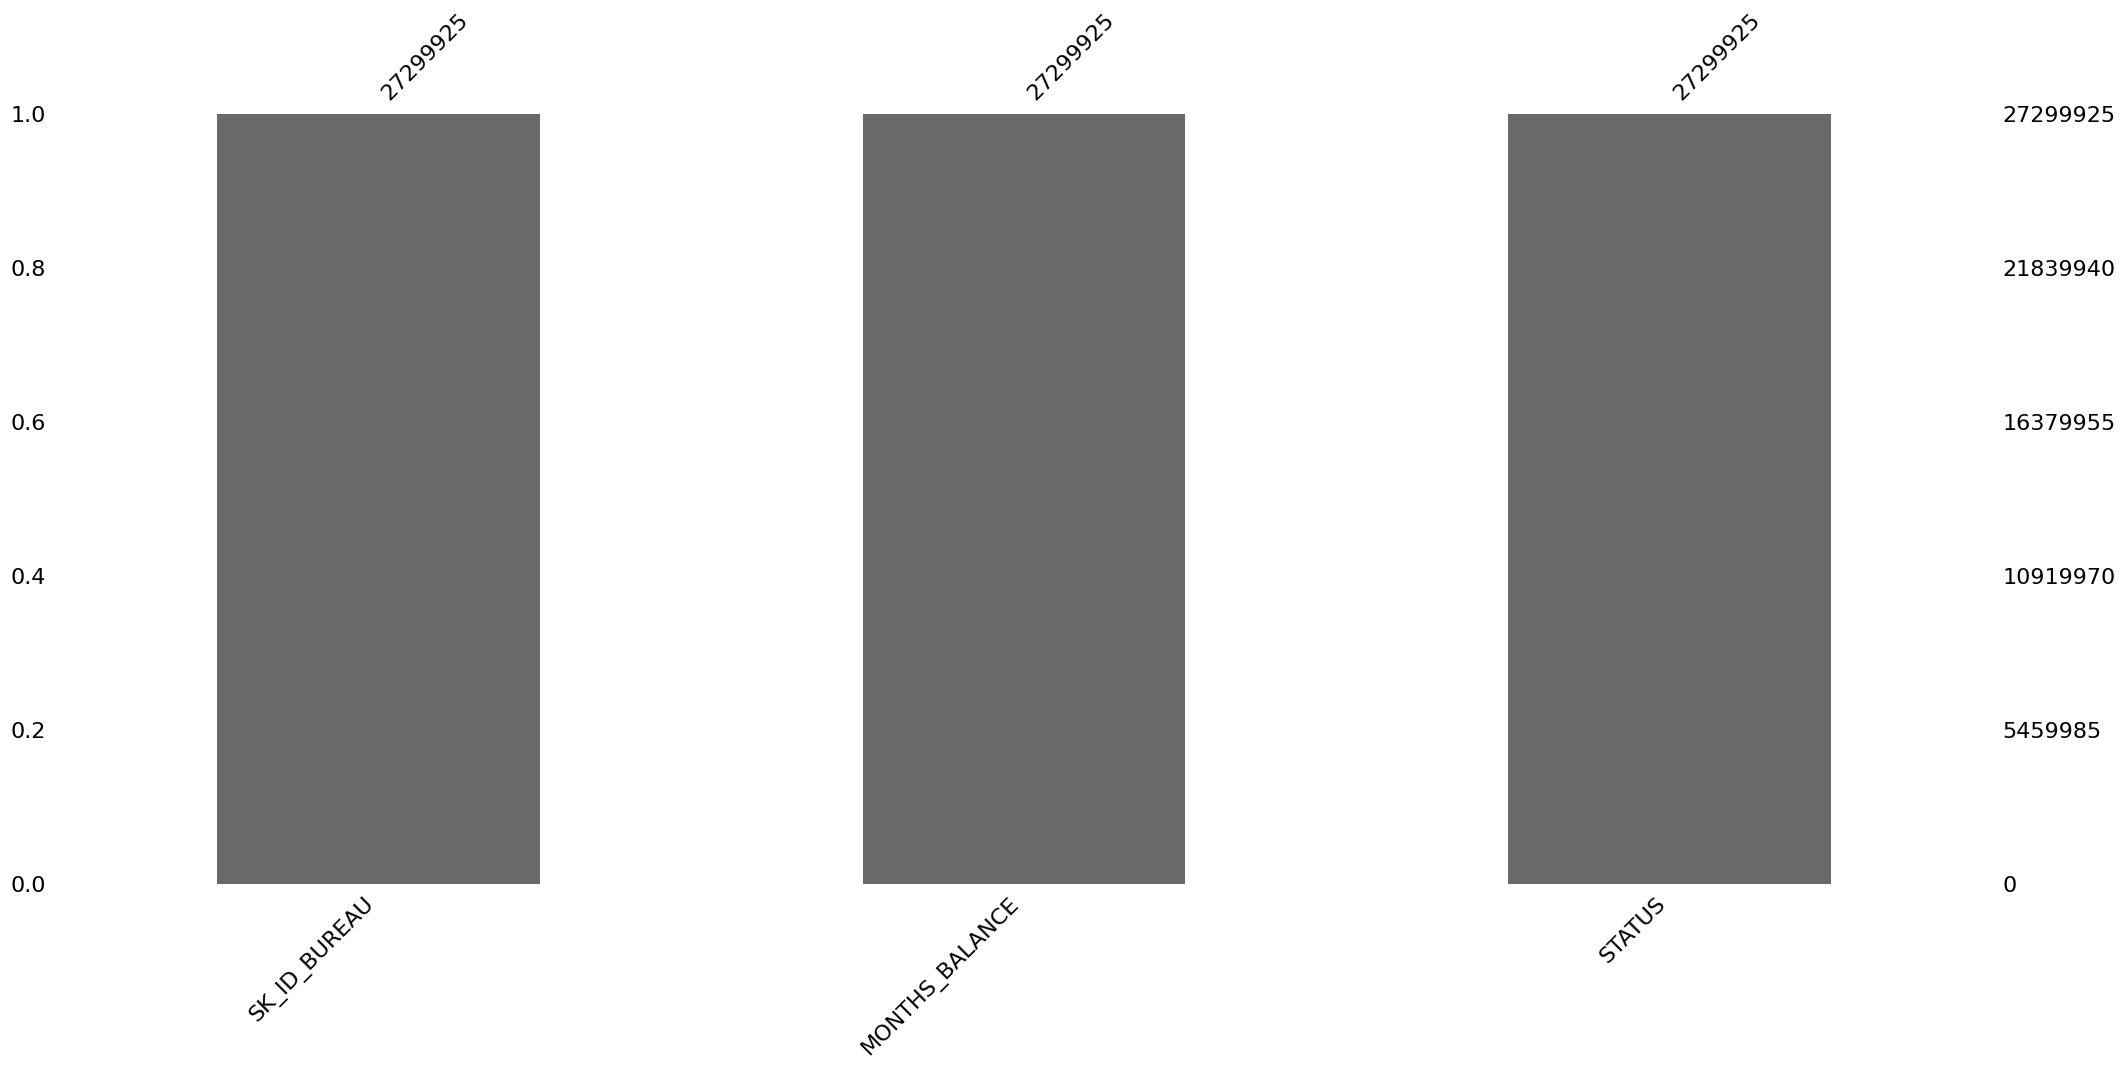

In [363]:
fonctions_data.description_dataset(bureau_balance, 'bureau_balance data')

<Axes: title={'center': 'Répartition des types de colonnes'}>

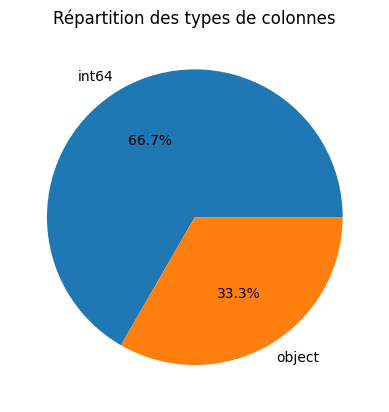

In [364]:
# Types des variables
bureau_balance.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

In [523]:
bureau_balance = fonctions_data.reduce_mem_usage(bureau_balance, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 624.85 MB
Memory usage après optimization: 338.46 MB
Diminution de 45.8%
-------------------------------------------------------------------------------


<Axes: title={'center': 'Répartition des types de colonnes'}>

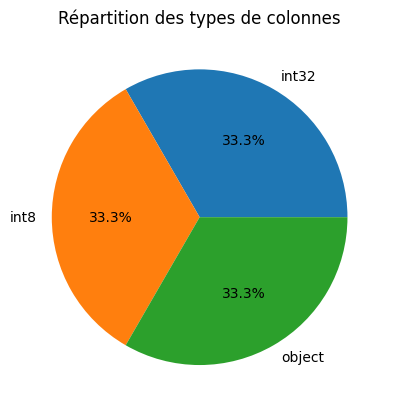

In [366]:
# Types des variables
bureau_balance.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### <span style='background:Moccasin'>5.1.2. Feature Engineering</span>

**Feature engineering**
- Création de nouvelles variables simples
- Catégorisation des variables binaires
- Imputation des valeurs manquantes
- Encodage des variables catégorielles
- Normalisation des variables numériques

In [525]:
def bureau_bb():

    bb = bureau_balance 

    # Rendre le nombre de mois positif
    bb['MONTHS_BALANCE'] = np.abs(bb['MONTHS_BALANCE'])

    # Encodage status
    dict_status = {'C': 0, '0': 0, '1': 1, '2': 2, 'X': 3, '3': 4,
                   '4': 5, '5': 6}
    bb['STATUS'] = bb['STATUS'].map(dict_status)

    # Ajout d'une variable du ratio du status par mois
    bb['STATUS_MONTHS_RATIO'] = bb.STATUS / \
        (bb.MONTHS_BALANCE + 1)

    # Ajout des variables de statistiques
    num_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'mean', 'sum'],
                    'STATUS': ['max', 'mean', 'last','sum'],
                    'STATUS_MONTHS_RATIO' : ['mean', 'sum', 'last']}
    
    agg_bb_num = \
        fonctions_data.agg_var_num(bb, 'SK_ID_BUREAU',
                                         num_aggregations, 'BUREAU_BALANCE')

    print('"Bureau Balance" final shape:', agg_bb_num.shape)
    
    return agg_bb_num

In [526]:
bureau_bb_fe = bureau_bb()

"Bureau Balance" final shape: (817395, 12)


In [527]:
bureau_bb_fe.head()

SK_ID_BUREAU  BUREAU_BALANCE_MONTHS_BALANCE_MIN  \
0       5001709                                  0   
1       5001710                                  0   
2       5001711                                  0   
3       5001712                                  0   
4       5001713                                  0   

   BUREAU_BALANCE_MONTHS_BALANCE_MAX  BUREAU_BALANCE_MONTHS_BALANCE_MEAN  \
0                                 96                                48.0   
1                                 82                                41.0   
2                                  3                                 1.5   
3                                 18                                 9.0   
4                                 21                                10.5   

   BUREAU_BALANCE_MONTHS_BALANCE_SUM  BUREAU_BALANCE_STATUS_MAX  \
0                               4656                          3   
1                               3403                          3   
2                                  6                          3   
3                                171                          0   
4                                231                          3   

   BUREAU_BALANCE_STATUS_MEAN  BUREAU_BALANCE_STATUS_LAST  \
0                    0.340206                           3   
1                    1.084337                           3   
2                    0.750000                           0   
3                    0.000000                           0   
4                    3.000000                           3   

   BUREAU_BALANCE_STATUS_SUM  BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN  \
0                         33                                 0.003702   
1                         90                                 0.016144   
2                          3                                 0.750000   
3                          0                                 0.000000   
4                         66                                 0.503293   

   BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM  \
0                                0.359120   
1                                1.339914   
2                                3.000000   
3                                0.000000   
4                               11.072440   

   BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST  
0                                 0.030928  
1                                 0.036145  
2                                 0.000000  
3                                 0.000000  
4                                 0.136364

In [528]:
# Ajout de la clé d'identification du demandeur
df_cle_demandeur = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']]
bureau_balance_par_demandeur = df_cle_demandeur.merge(bureau_bb_fe,
                                                      on='SK_ID_BUREAU',
                                                      how='left')
print(bureau_balance_par_demandeur.shape)
bureau_balance_par_demandeur.head()

(1716428, 13)


SK_ID_CURR  SK_ID_BUREAU  BUREAU_BALANCE_MONTHS_BALANCE_MIN  \
0      215354       5714462                                NaN   
1      215354       5714463                                NaN   
2      215354       5714464                                NaN   
3      215354       5714465                                NaN   
4      215354       5714466                                NaN   

   BUREAU_BALANCE_MONTHS_BALANCE_MAX  BUREAU_BALANCE_MONTHS_BALANCE_MEAN  \
0                                NaN                                 NaN   
1                                NaN                                 NaN   
2                                NaN                                 NaN   
3                                NaN                                 NaN   
4                                NaN                                 NaN   

   BUREAU_BALANCE_MONTHS_BALANCE_SUM  BUREAU_BALANCE_STATUS_MAX  \
0                                NaN                        NaN   
1                                NaN                        NaN   
2                                NaN                        NaN   
3                                NaN                        NaN   
4                                NaN                        NaN   

   BUREAU_BALANCE_STATUS_MEAN  BUREAU_BALANCE_STATUS_LAST  \
0                         NaN                         NaN   
1                         NaN                         NaN   
2                         NaN                         NaN   
3                         NaN                         NaN   
4                         NaN                         NaN   

   BUREAU_BALANCE_STATUS_SUM  BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN  \
0                        NaN                                      NaN   
1                        NaN                                      NaN   
2                        NaN                                      NaN   
3                        NaN                                      NaN   
4                        NaN                                      NaN   

   BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN

- Un demandeur peut avoir plusieurs prêts contractés auprès de Home Crédit Group (SK_ID_CURR) et peut avoir plusieurs prêts chez un autres organismes identifiés par SK_ID_BUREAU donc un SK_ID_CURR peut avoir 0 ou plusieurs SK_ID_BUREAU.
- La moyenne des différents autres prêts sera effectuée pour obtenir une seule ligne pour le prêt SK_ID_CURR.

In [530]:
# Aggrégation des autres prêts par la moyenne des données pour chaque SK_ID_CURR
agg_bureau_balance_par_demandeur = \
    fonctions_data.agg_moy_par_pret(bureau_balance_par_demandeur.drop(columns=['SK_ID_BUREAU']),
                                          'SK_ID_CURR', 'PKPRET')
print(agg_bureau_balance_par_demandeur.shape)
agg_bureau_balance_par_demandeur.head()

(305811, 12)


SK_ID_CURR  PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_mean  \
0      100001                                            0.0   
1      100002                                           15.5   
2      100003                                            NaN   
3      100004                                            NaN   
4      100005                                            0.0   

   PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_mean  \
0                                      23.571429   
1                                      28.250000   
2                                            NaN   
3                                            NaN   
4                                       6.000000   

   PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean  \
0                                       11.785714   
1                                       21.875000   
2                                             NaN   
3                                             NaN   
4                                        3.000000   

   PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean  \
0                                     400.000000   
1                                     337.625000   
2                                            NaN   
3                                            NaN   
4                                      30.333333   

   PKPRET_BUREAU_BALANCE_STATUS_MAX_mean  \
0                               2.142857   
1                               2.375000   
2                                    NaN   
3                                    NaN   
4                               2.000000   

   PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean  \
0                                0.651288   
1                                0.741477   
2                                     NaN   
3                                     NaN   
4                                0.410256   

   PKPRET_BUREAU_BALANCE_STATUS_LAST_mean  \
0                                1.714286   
1                                2.250000   
2                                     NaN   
3                                     NaN   
4                                1.000000   

   PKPRET_BUREAU_BALANCE_STATUS_SUM_mean  \
0                                   13.0   
1                                    9.0   
2                                    NaN   
3                                    NaN   
4                                    2.0   

   PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_mean  \
0                                           0.138099     
1                                           0.073243     
2                                                NaN     
3                                                NaN     
4                                           0.339250     

   PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_mean  \
0                                           0.939380    
1                                           0.483416    
2                                                NaN    
3                                                NaN    
4                                           1.076923    

   PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_mean  
0                                           0.252084    
1                                           0.143261    
2                                                NaN    
3                                                NaN    
4                                           0.076923

#### <span style='background:Moccasin'>5.1.3. Assemblage avec le 'train set'</span>

In [531]:
features_set = features_set.merge(agg_bureau_balance_par_demandeur, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with agg_bureau_balance_par_demandeur:', features_set.shape)

--=> features_set after merge with agg_bureau_balance_par_demandeur: (307507, 499)


In [532]:
# Description
fonctions_data.detail_type_var(features_set, type_var='all')

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type            int64            float16     float16      float16   
nb_nan            0.0                0.0         0.0          0.0   
%_nan             0.0                0.0         0.0          0.0   
count        307507.0           307507.0    307507.0     307507.0   
mean    278181.527256                0.0         NaN          NaN   
std     102790.132982                0.0         0.0          0.0   
min          100002.0                0.0         0.0          0.0   
25%          189146.5                0.0         0.0          0.0   
50%          278203.0                0.0         0.0          1.0   
75%          367143.5                0.0         1.0          1.0   
max          456255.0                1.0         1.0          1.0   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type           float16      float16          float16    float16     float16   
nb_nan             0.0          0.0              0.0        0.0         0.0   
%_nan              0.0          0.0              0.0        0.0         0.0   
count         307507.0     307507.0         307507.0   307507.0    307507.0   
mean               NaN          0.0              0.0        0.0         0.0   
std                0.0          0.0              0.0        0.0         0.0   
min                0.0          0.0              0.0        0.0         0.0   
25%                0.0          0.0         0.000742   0.056183    0.058136   
50%                0.0          0.0         0.001039   0.117004     0.09082   
75%                1.0     0.052643         0.001512   0.190674    0.128662   
max                1.0          1.0              1.0        1.0         1.0   

       REGION_POPULATION_RELATIVE  ...  \
type                      float16  ...   
nb_nan                        0.0  ...   
%_nan                         0.0  ...   
count                    307507.0  ...   
mean                          NaN  ...   
std                           0.0  ...   
min                           0.0  ...   
25%                      0.134644  ...   
50%                      0.256836  ...   
75%                      0.392822  ...   
max                           1.0  ...   

       PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_mean  \
type                                         float64   
nb_nan                                      215276.0   
%_nan                                      70.006862   
count                                        92231.0   
mean                                       34.223424   
std                                        17.815248   
min                                              0.0   
25%                                             21.0   
50%                                             33.0   
75%                                        45.222222   
max                                             96.0   

       PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean  \
type                                          float64   
nb_nan                                       215276.0   
%_nan                                       70.006862   
count                                         92231.0   
mean                                        20.984805   
std                                         11.926775   
min                                               0.0   
25%                                             12.25   
50%                                              20.0   
75%                                         27.954545   
max                                              92.5   

       PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean  \
type                                         float64   
nb_nan                                      215276.0   
%_nan                                      70.006862   
count                                        92231.0   
mean                                       767.32208   
std                               

#### <span style='background:Moccasin'>5.1.4. Assemblage avec le 'test set'</span>

In [533]:
test_features_set = test_features_set.merge(agg_bureau_balance_par_demandeur, how='left', on='SK_ID_CURR')
print('--=> test_features_set after merge with agg_bureau_balance_par_demandeur:', test_features_set.shape)

--=> test_features_set after merge with agg_bureau_balance_par_demandeur: (48744, 488)


In [534]:
# Description
fonctions_data.detail_type_var(test_features_set, type_var='all')

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type            int64            float16     float16      float16   
nb_nan            0.0                0.0         0.0          0.0   
%_nan             0.0                0.0         0.0          0.0   
count         48744.0            48744.0     48744.0      48744.0   
mean     277796.67635            0.00901     0.32959     0.337158   
std     103169.547296           0.094482    0.470215       0.4729   
min          100001.0                0.0         0.0          0.0   
25%         188557.75                0.0         0.0          0.0   
50%          277549.0                0.0         0.0          0.0   
75%          367555.5                0.0         1.0          1.0   
max          456250.0                1.0         1.0          1.0   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type           float16      float16          float16    float16     float16   
nb_nan             0.0          0.0              0.0        0.0         0.0   
%_nan              0.0          0.0              0.0        0.0         0.0   
count          48744.0      48744.0          48744.0    48744.0     48744.0   
mean          0.690918     0.020905         0.001307   0.117798    0.108521   
std           0.462402     0.037323          0.00088   0.091248    0.062439   
min                0.0          0.0         0.000011        0.0    0.002649   
25%                0.0          0.0         0.000742   0.053833    0.063782   
50%                1.0          0.0         0.001127   0.101135    0.095886   
75%                1.0     0.052643         0.001704   0.157349    0.139526   
max                1.0     1.052734         0.037476   0.549316    0.697754   

       REGION_POPULATION_RELATIVE  ...  \
type                      float16  ...   
nb_nan                        0.0  ...   
%_nan                         0.0  ...   
count                     48744.0  ...   
mean                     0.290039  ...   
std                      0.199829  ...   
min                     -0.000511  ...   
25%                      0.134521  ...   
50%                       0.25708  ...   
75%                      0.392822  ...   
max                           1.0  ...   

       PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_mean  \
type                                         float64   
nb_nan                                        6433.0   
%_nan                                      13.197522   
count                                        42311.0   
mean                                       35.335464   
std                                        17.305321   
min                                              0.0   
25%                                             23.0   
50%                                             34.5   
75%                                             46.0   
max                                             95.0   

       PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean  \
type                                          float64   
nb_nan                                         6433.0   
%_nan                                       13.197522   
count                                         42311.0   
mean                                        17.683255   
std                                          8.653676   
min                                               0.0   
25%                                              11.5   
50%                                             17.25   
75%                                              23.0   
max                                              48.0   

       PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean  \
type                                         float64   
nb_nan                                        6433.0   
%_nan                                      13.197522   
count                                        42311.0   
mean                                      959.696341   
std                               

#### <span style='background:Moccasin'>5.1.5. Nettoyage</span>

<span style='background:mistyrose'>**Réduction mémoire des dataframes**</span>

In [535]:
features_set = fonctions_data.reduce_mem_usage(features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 365.11 MB
Memory usage après optimization: 344.58 MB
Diminution de 5.6%
-------------------------------------------------------------------------------


In [536]:
test_features_set = fonctions_data.reduce_mem_usage(test_features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 56.43 MB
Memory usage après optimization: 53.18 MB
Diminution de 5.8%
-------------------------------------------------------------------------------


<span style='background:mistyrose'>**Variables fortement corrélées**</span>

In [537]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_features_set = fonctions_data.suppr_var_colineaire(features_set)

4 variables fortement corrélées à supprimer :

PREV_ANNUITY_SUM
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_mean


In [538]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_test_features_set = fonctions_data.suppr_var_colineaire(test_features_set)

3 variables fortement corrélées à supprimer :

PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MEAN_mean
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_SUM_mean
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_mean


***Train set***

In [539]:
# Suppression des variables fortement corrélées du train set
features_set = features_set.drop(columns = var_corr_features_set)
print(f'train_set : {features_set.shape}')

train_set : (307507, 495)


***Test set***

In [540]:
# Suppression des variables fortement corrélées du train set
test_features_set = test_features_set.drop(columns = var_corr_test_features_set)
print(f'test_set : {test_features_set.shape}')

test_set : (48744, 485)


<span style='background:mistyrose'>**Imputation des données**</span>

***Train set***

Valeurs manquantes :1291656 NaN pour 165131259 données (0.78 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
PKPRET_BUREAU_BALANCE_STATUS_MAX_mean_y                                    215276   
PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean_y                                   215276   
PKPRET_BUREAU_BALANCE_STATUS_LAST_mean_y                                   215276   
PKPRET_BUREAU_BALANCE_STATUS_SUM_mean_y                                    215276   
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_...                         215276   
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_...                         215276   

                                                    % de valeurs manquantes  
PKPRET_BUREAU_BALANCE_STATUS_MAX_mean_y                               70.01  
PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean_y                              70.01  
PKPRET_BUREAU_BALANCE_STATUS_LAST_mean_y                              70.01  
PKPRET_BUREAU_BALANCE_STATUS_SUM_mean_y                               70.01  
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_...                    70.01  
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_...                    70.01

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


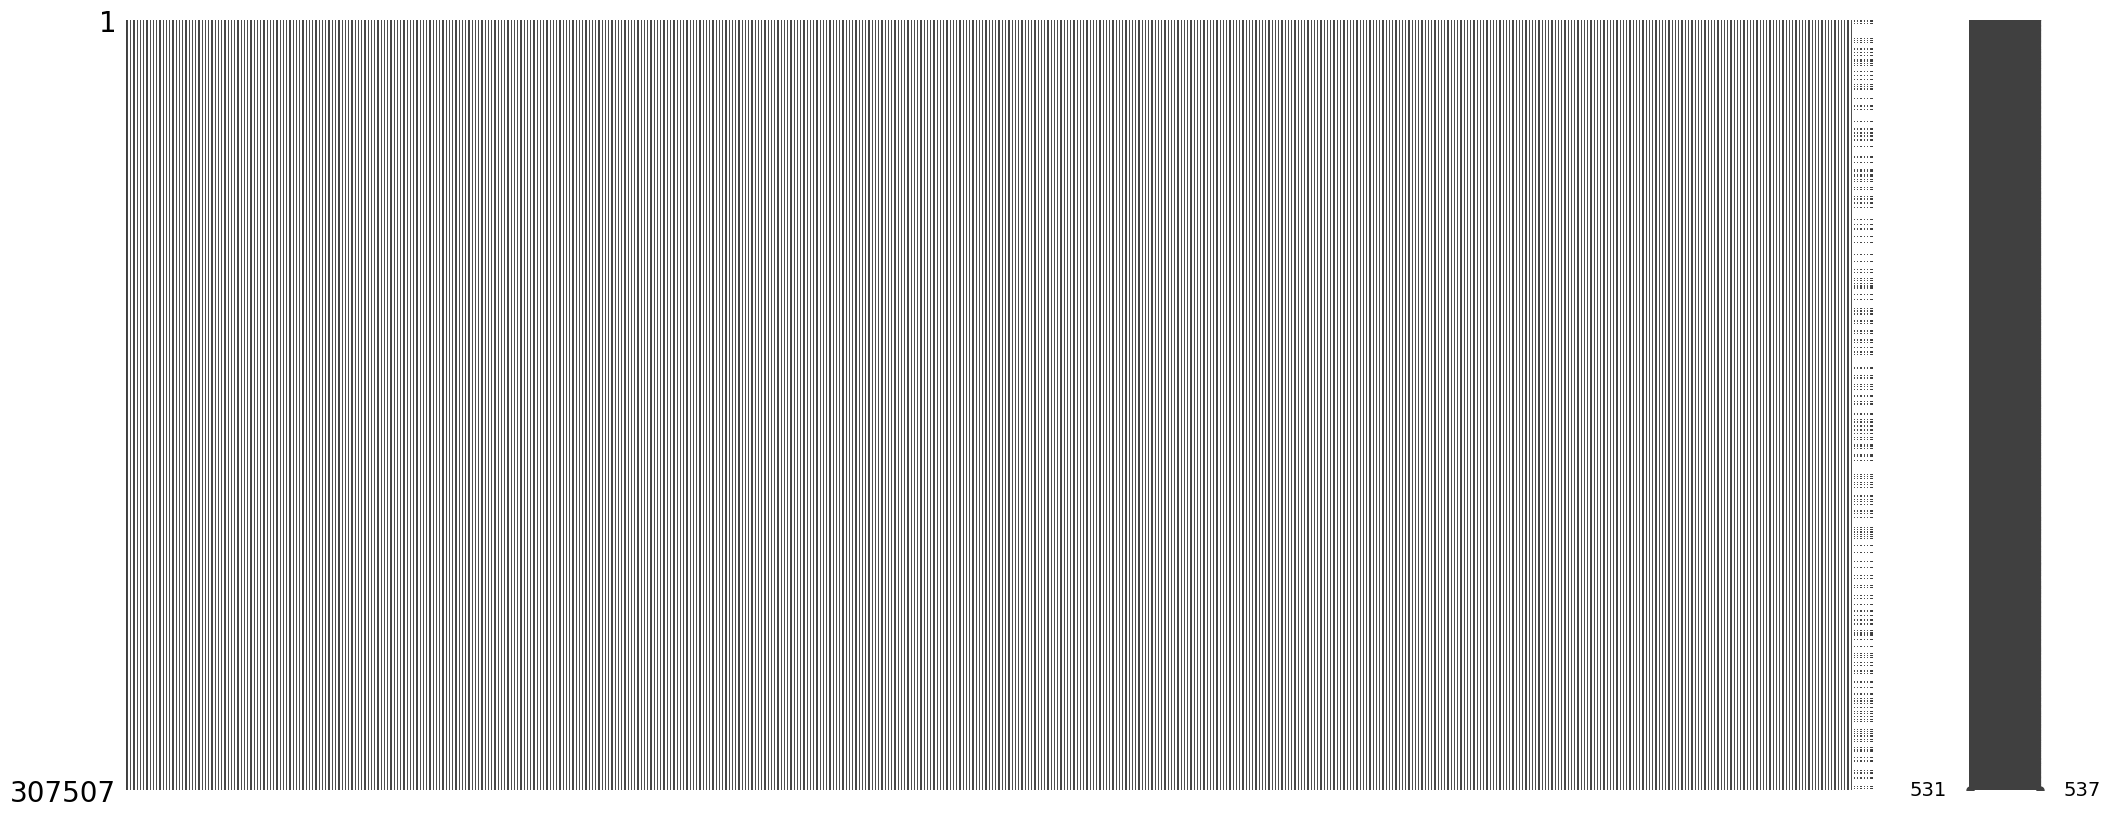

In [186]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [541]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
features_set = features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 1722208
Nombre de nan ou valeurs nulles après suppression des champs vierges : 1722208


**Imputation par la médiane**

In [542]:
# Variables quantitatives - imputation par médiane
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
features_set.fillna(features_set.median(), inplace=True)

# Vérification
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 1722208
Nombre de nan après imputation par median : 0


In [543]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = features_set.columns[(features_set == 0).all()]
colonnes_nulles

Index([], dtype='object')

In [544]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
features_set = features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = features_set.columns[(features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 0
Nombre de champs nulles après imputation: 0


**Imputation avec NaNIMputer (Verstack)**

In [547]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = features_set.isna().sum().sum()

In [548]:
# Copie du jeu de données
X_nan = features_set.copy()

In [549]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


   - no missing data

Time elapsed for impute execution: 0.32606 seconds


In [550]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 0
Nombre de nan après imputation par NaNImputer : 0


Valeurs manquantes :0 NaN pour 165131259 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


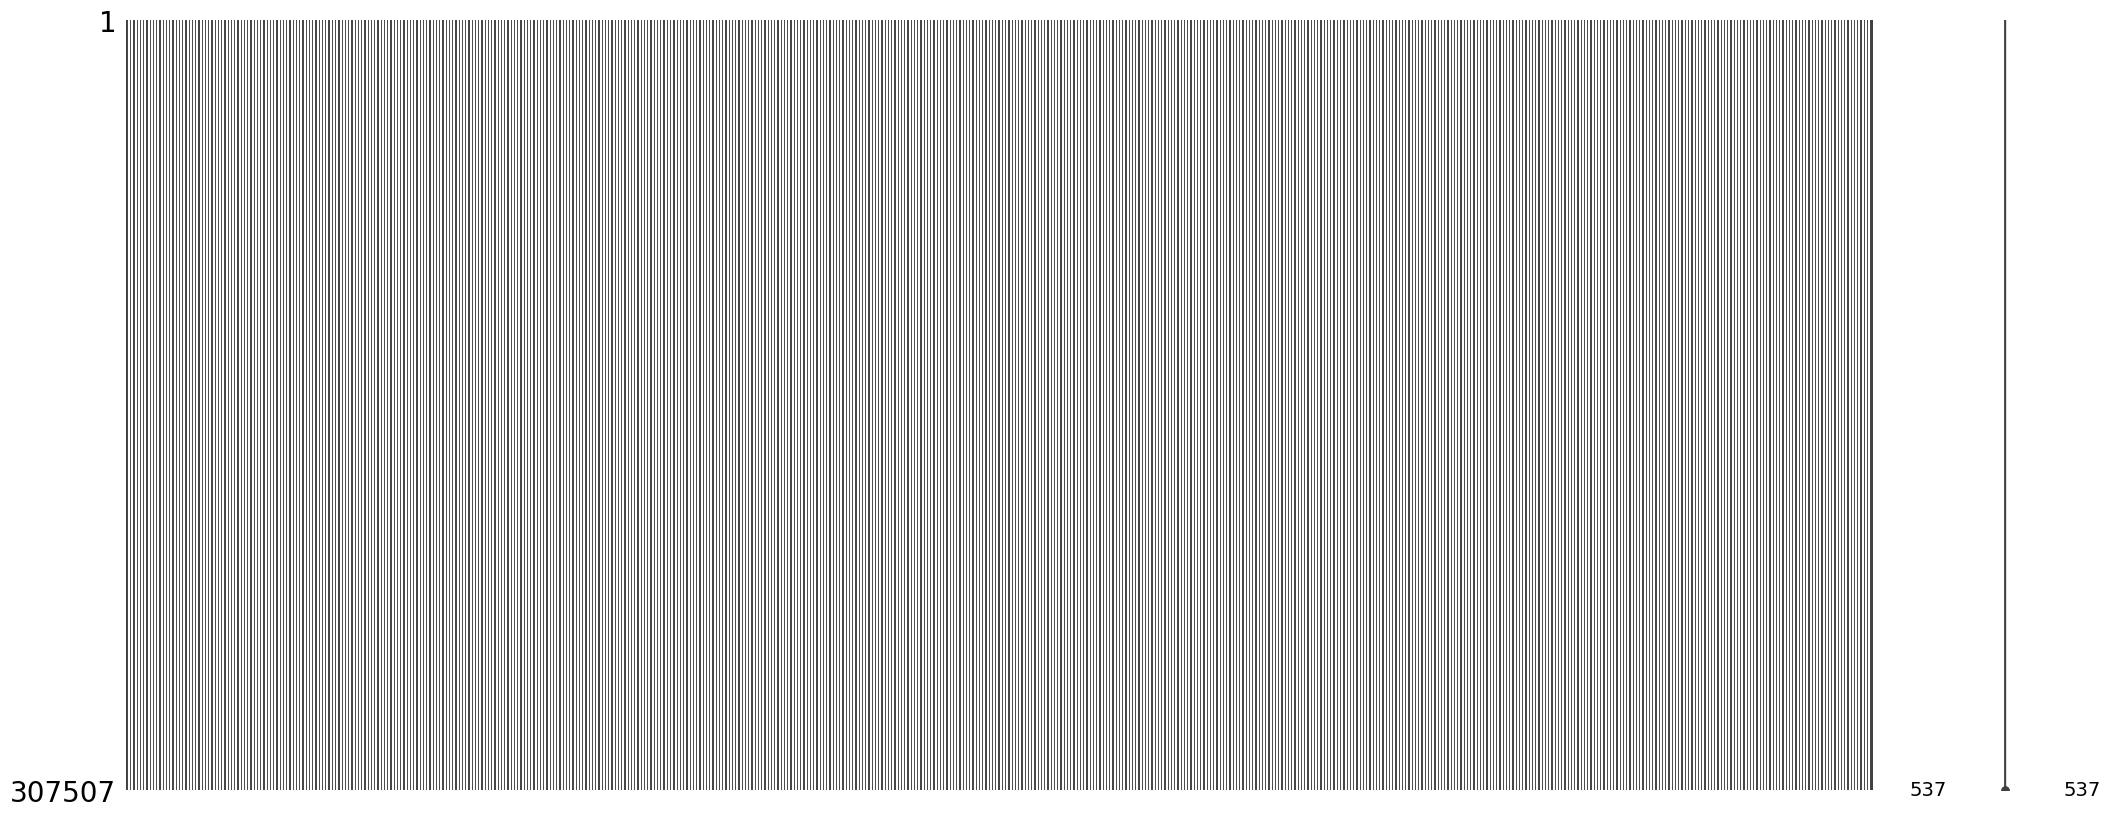

In [188]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

***Test set***

In [189]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

Valeurs manquantes :308050 NaN pour 26273016 données (1.17 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
PKPRET_BUREAU_BALANCE_STATUS_MAX_mean_x                                     48744   
PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean_x                                    48744   
PKPRET_BUREAU_BALANCE_STATUS_LAST_mean_x                                    48744   
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_...                          48744   
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_...                          48744   
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_mean_x                              6433   
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_mean_x                              6433   
PKPRET_BUREAU_BALANCE_STATUS_SUM_mean_x                                      6433   
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_m...                           6433   
PKPRET_BUREAU_BALANCE_STATUS_MAX_mean_y                                      6433   
PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean_y                                     6433   
PKPRET_BUREAU_BALANCE_STATUS_LAST_mean_y                                     6433   
PKPRET_BUREAU_BALANCE_STATUS_SUM_mean_y                                      6433   
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_...                           6433   
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_...                           6433   

                                                    % de valeurs manquantes  
PKPRET_BUREAU_BALANCE_STATUS_MAX_mean_x                               100.0  
PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean_x                              100.0  
PKPRET_BUREAU_BALANCE_STATUS_LAST_mean_x                              100.0  
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_...                    100.0  
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_...                    100.0  
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MIN_mean_x                        13.2  
PKPRET_BUREAU_BALANCE_MONTHS_BALANCE_MAX_mean_x                        13.2  
PKPRET_BUREAU_BALANCE_STATUS_SUM_mean_x                                13.2  
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_SUM_m...                     13.2  
PKPRET_BUREAU_BALANCE_STATUS_MAX_mean_y                                13.2  
PKPRET_BUREAU_BALANCE_STATUS_MEAN_mean_y                               13.2  
PKPRET_BUREAU_BALANCE_STATUS_LAST_mean_y                               13.2  
PKPRET_BUREAU_BALANCE_STATUS_SUM_mean_y                                13.2  
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_MEAN_...                     13.2  
PKPRET_BUREAU_BALANCE_STATUS_MONTHS_RATIO_LAST_...                     13.2

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [545]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
test_features_set = test_features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 51464
Nombre de nan ou valeurs nulles après suppression des champs vierges : 51464


**Imputation par la médiane**

In [546]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_features_set.fillna(test_features_set.median(), inplace=True)

# Vérification
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 51464
Nombre de nan après imputation par median : 0


In [547]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
colonnes_nulles

Index([], dtype='object')

In [548]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
test_features_set = test_features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 0
Nombre de champs nulles après imputation: 0


**Imputation par NaNImputer (Verstack)**

In [556]:
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features_set.isna().sum().sum()

In [557]:
# Copie du jeu de données
X_nan = test_features_set.copy()

In [558]:
# Imputation des NaN
imputer = NaNImputer()
X_nan_imputed = imputer.impute(X_nan)


 * Initiating NaNImputer.impute
     . Dataset dimensions:
     .. rows:         48744
     .. columns:      540
     .. mb in memory: 59.41
     .. NaN cols num: 5

   - Drop hopeless NaN cols

   - droped column PKPRET_BURO_B_STATUS_MAX_mean with NaNs and a constant non-NaN value

   - droped column PKPRET_BURO_B_STATUS_MEAN_mean with NaNs and a constant non-NaN value

   - droped column PKPRET_BURO_B_STATUS_LAST_mean with NaNs and a constant non-NaN value

   - droped column PKPRET_BURO_B_STATUS_MONTHS_RATIO_MEAN_mean with NaNs and a constant non-NaN value

   - droped column PKPRET_BURO_B_STATUS_MONTHS_RATIO_LAST_mean with NaNs and a constant non-NaN value

   - Processing whole data for imputation

   - Imputing single core 0 cols

   - Missing values after imputation: 0

Time elapsed for impute execution: 1.7876 seconds


In [559]:
print(f'Nombre de nan avant imputation par NaNImputer : {nb_nan_nanimput}')
df_tmp_nan = pd.DataFrame(X_nan_imputed, columns=X_nan.columns)
test_features = df_tmp_nan
# Variables quantitatives - imputation en utilisant NaNImputer de Verstack
nb_nan_nanimput = test_features.isna().sum().sum()
print(f'Nombre de nan après imputation par NaNImputer : {nb_nan_nanimput}')

Nombre de nan avant imputation par NaNImputer : 243720
Nombre de nan après imputation par NaNImputer : 243720


Valeurs manquantes :0 NaN pour 26029296 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


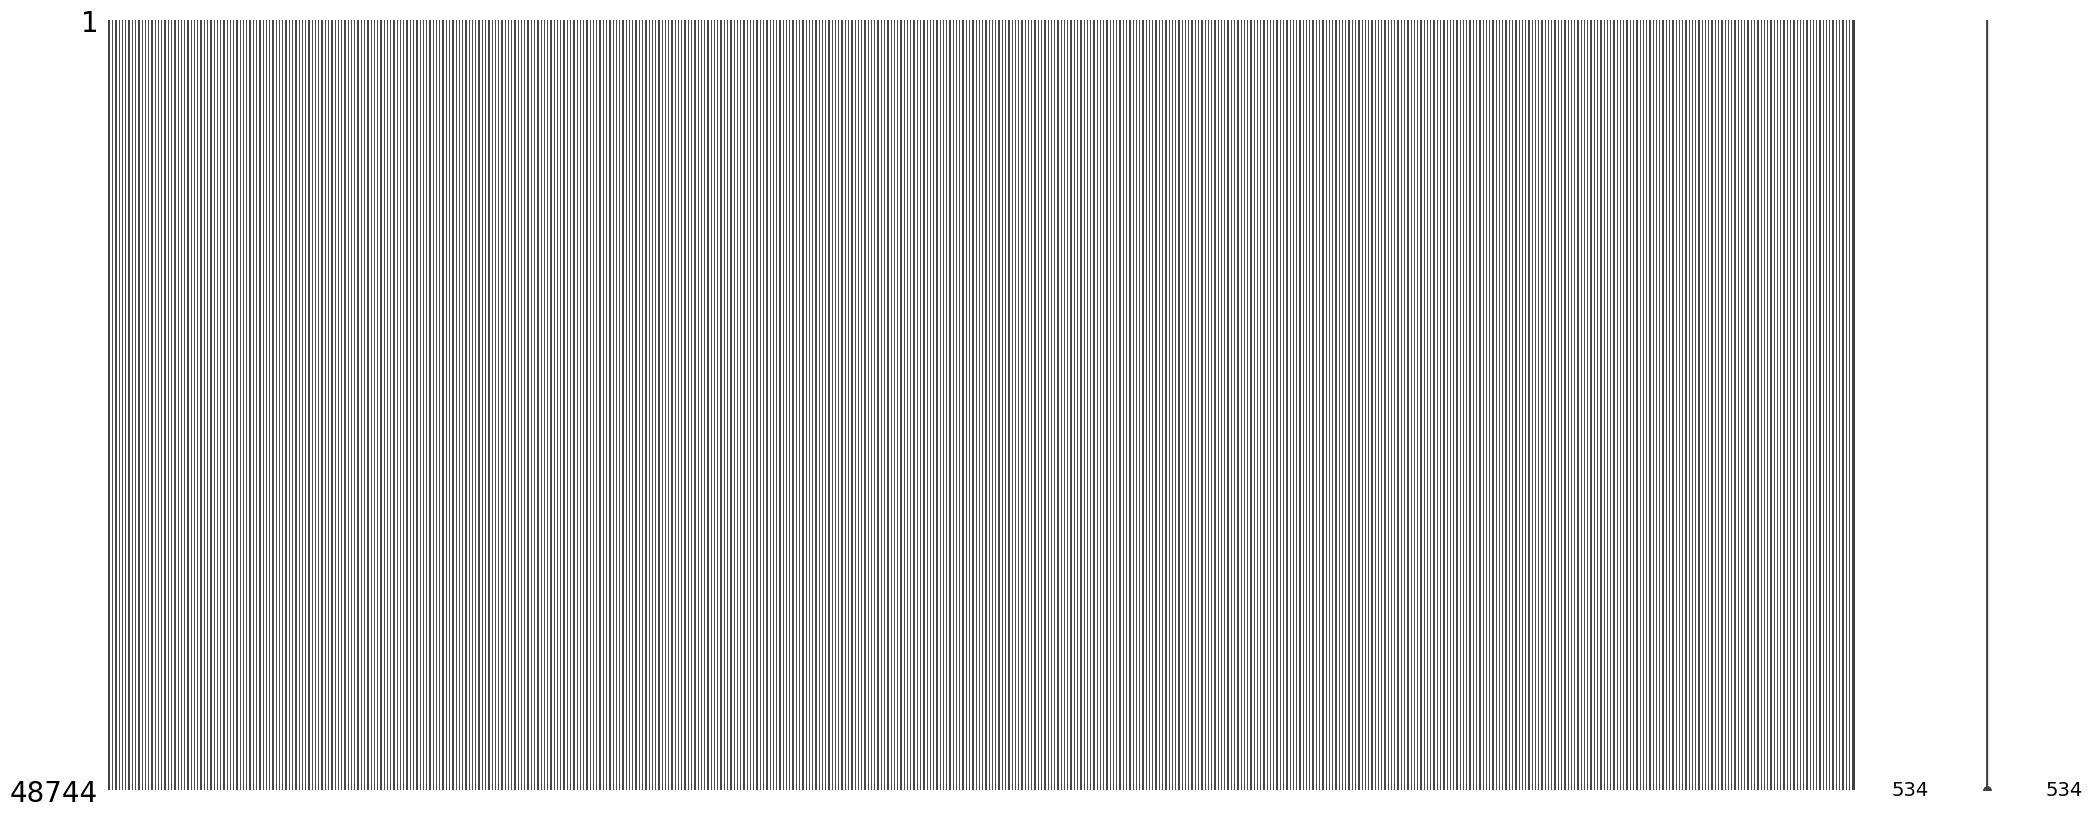

In [192]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

### <span style='background:orange'>5.2. Fichiers bureau.csv</span>

**Description des variables**

| Variable | Description | Liste valeurs |
| --- | --- | --- |
| <p style='text-align: justify;'>**SK_ID_CURR**</p> | <ul style='text-align: left;'><li>ID du prêt dans notre échantillon</li> <li>Un prêt dans notre échantillon peut avoir 0, 1, 2 ou plus de crédits précédents liés dans le bureau de crédit.</li></ul> |  |
| <p style='text-align: justify;'>**SK_BUREAU_ID**</p> | <p style='text-align: justify;'>ID recodé du crédit précédent du Credit Bureau lié à notre prêt (codage unique pour chaque demande de prêt)</p> |  |
| <p style='text-align: justify;'>**CREDIT_ACTIVE**</p> | <p style='text-align: justify;'>Statut des crédits déclarés par le Credit Bureau (CB)</p> | <ul style='text-align: justify;'><li>Closed</li> <li>Active</li> <li>Sold</li> <li>Bad debt</li></ul> |
| <p style='text-align: justify;'>**CREDIT_CURRENCY**</p> | <p style='text-align: justify;'>Devise recodée du crédit du Credit Bureau</p> | <ul style='text-align: justify;'><li>currency 1</li> <li>currency 2</li> <li>currency 3</li> <li>currency 4</li></ul>  |
| <p style='text-align: justify;'>**DAYS_CREDIT**</p> | <p style='text-align: justify;'>Combien de jours avant la demande actuelle le client a-t-il demandé un crédit au Credit Bureau ?</p> |  |
| <p style='text-align: justify;'>**CREDIT_DAY_OVERDUE**</p> | <p style='text-align: justify;'>Nombre de jours de retard sur le crédit CB au moment de la demande de prêt liée à notre échantillon.</p> |  |
| <p style='text-align: justify;'>**DAYS_CREDIT_ENDDATE**</p> | <p style='text-align: justify;'>Durée restante du crédit CB (en jours) au moment de la demande dans Crédit immobilier</p> |  |
| <p style='text-align: justify;'>**DAYS_ENDDATE_FACT**</p> | <p style='text-align: justify;'>Jours depuis la fin du crédit CB au moment de la demande dans le crédit domestique (uniquement pour les crédits fermés).</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_MAX_OVERDUE**</p> | <p style='text-align: justify;'>Montant maximal des impayés sur le crédit du Credit Bureau jusqu'à présent (à la date de demande du prêt dans notre échantillon).</p> |  |
| <p style='text-align: justify;'>**CNT_CREDIT_PROLONG**</p> | <p style='text-align: justify;'>Combien de fois le crédit du Bureau de crédit a-t-il été prolongé ?</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM**</p> | <p style='text-align: justify;'>Montant actuel du crédit du Credit Bureau.</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM_DEBT**</p> | <p style='text-align: justify;'>Dette actuelle sur le crédit du Credit Bureau.</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM_LIMIT**</p> | <p style='text-align: justify;'>Limite de crédit actuelle de la carte de crédit déclarée dans le Bureau de crédit.</p> |  |
| <p style='text-align: justify;'>**AMT_CREDIT_SUM_OVERDUE**</p> | <p style='text-align: justify;'>Montant actuel en retard sur le crédit du Bureau de crédit.</p> |  |
| <p style='text-align: justify;'>**CREDIT_TYPE**</p> | <p style='text-align: justify;'>Type de crédit du Bureau de crédit (voiture ou argent liquide...)</p> | <ul style='text-align: justify;'><li>Credit card</li> <li>Consumer credit</li> <li>Loan for business development</li> <li>Microloan</li> <li>Mortgage</li> <li>Car loan</li> <li>Loan for working capital replenishment</li> <li>Another type of loan</li> <li>Unknown type of loan</li> <li>Loan for the purchase of equipment</li> <li>Cash loan (non-earmarked)</li> <li>Real estate loan</li> <li>Interbank credit</li> <li>Loan for purchase of shares (margin lending)</li> <li>Mobile operator loan</li></ul> |
| <p style='text-align: justify;'>**DAYS_CREDIT_UPDATE**</p> | <p style='text-align: justify;'>Combien de jours avant la demande de prêt la dernière information sur la solvabilité du Credit Bureau a-t-elle été fournie ?</p> |  |
| <p style='text-align: justify;'>**AMT_ANNUITY**</p> | <p style='text-align: justify;'>Annuité du crédit du Credit Bureau	</p> |  |

In [549]:
# Taille : nombre de lignes/colonnes
nRow, nVar = bureau.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1716428 lignes et 17 variables.


In [550]:
# Variables quantitatives
cols_num_bur = bureau.select_dtypes(include=[np.number]).columns \
    .to_list()
cols_num_bur

['SK_ID_CURR',
 'SK_ID_BUREAU',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY']

In [551]:
# Variables catégorielles
cols_cat_bur = bureau.select_dtypes(exclude=[np.number]).columns \
    .to_list()
cols_cat_bur

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

#### <span style='background:Moccasin'>5.2.1. Réduction de la mémoire d'usage de chaque dataframe</span>

On traite le dataset  bureau data


SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN

Taille :-------------------------------------------------------------- (1716428, 17)
----------------------------------------------------------------------------------------------------
Valeurs manquantes par colonnes (%): 


Valeurs manquantes  % total des valeurs
AMT_ANNUITY                        1226791                 71.5
AMT_CREDIT_MAX_OVERDUE             1124488                 65.5
DAYS_ENDDATE_FACT                   633653                 36.9
AMT_CREDIT_SUM_LIMIT                591780                 34.5
AMT_CREDIT_SUM_DEBT                 257669                 15.0
DAYS_CREDIT_ENDDATE                 105553                  6.1
AMT_CREDIT_SUM                          13                  0.0

----------------------------------------------------------------------------------------------------
Valeurs différentes par variables : 
SK_ID_CURR------------------------------------------------------------ contient 305811 valeurs différentes
SK_ID_BUREAU---------------------------------------------------------- contient 1716428 valeurs différentes
CREDIT_ACTIVE--------------------------------------------------------- ['Closed' 'Active' 'Sold' 'Bad debt']
CREDIT_CURRENCY------------------------------------------------------- ['currency 1' 'currency 2' 'currency 4' 'currency 3']
DAYS_CREDIT----------------------------------------------------------- contient 2923 valeurs différentes
CREDIT_DAY_OVERDUE---------------------------------------------------- contient 942 valeurs différentes
DAYS_CREDIT_ENDDATE--------------------------------------------------- contient 14096 valeurs différentes
DAYS_ENDDATE_FACT----------------------------------------------------- contient 2917 valeurs diffé

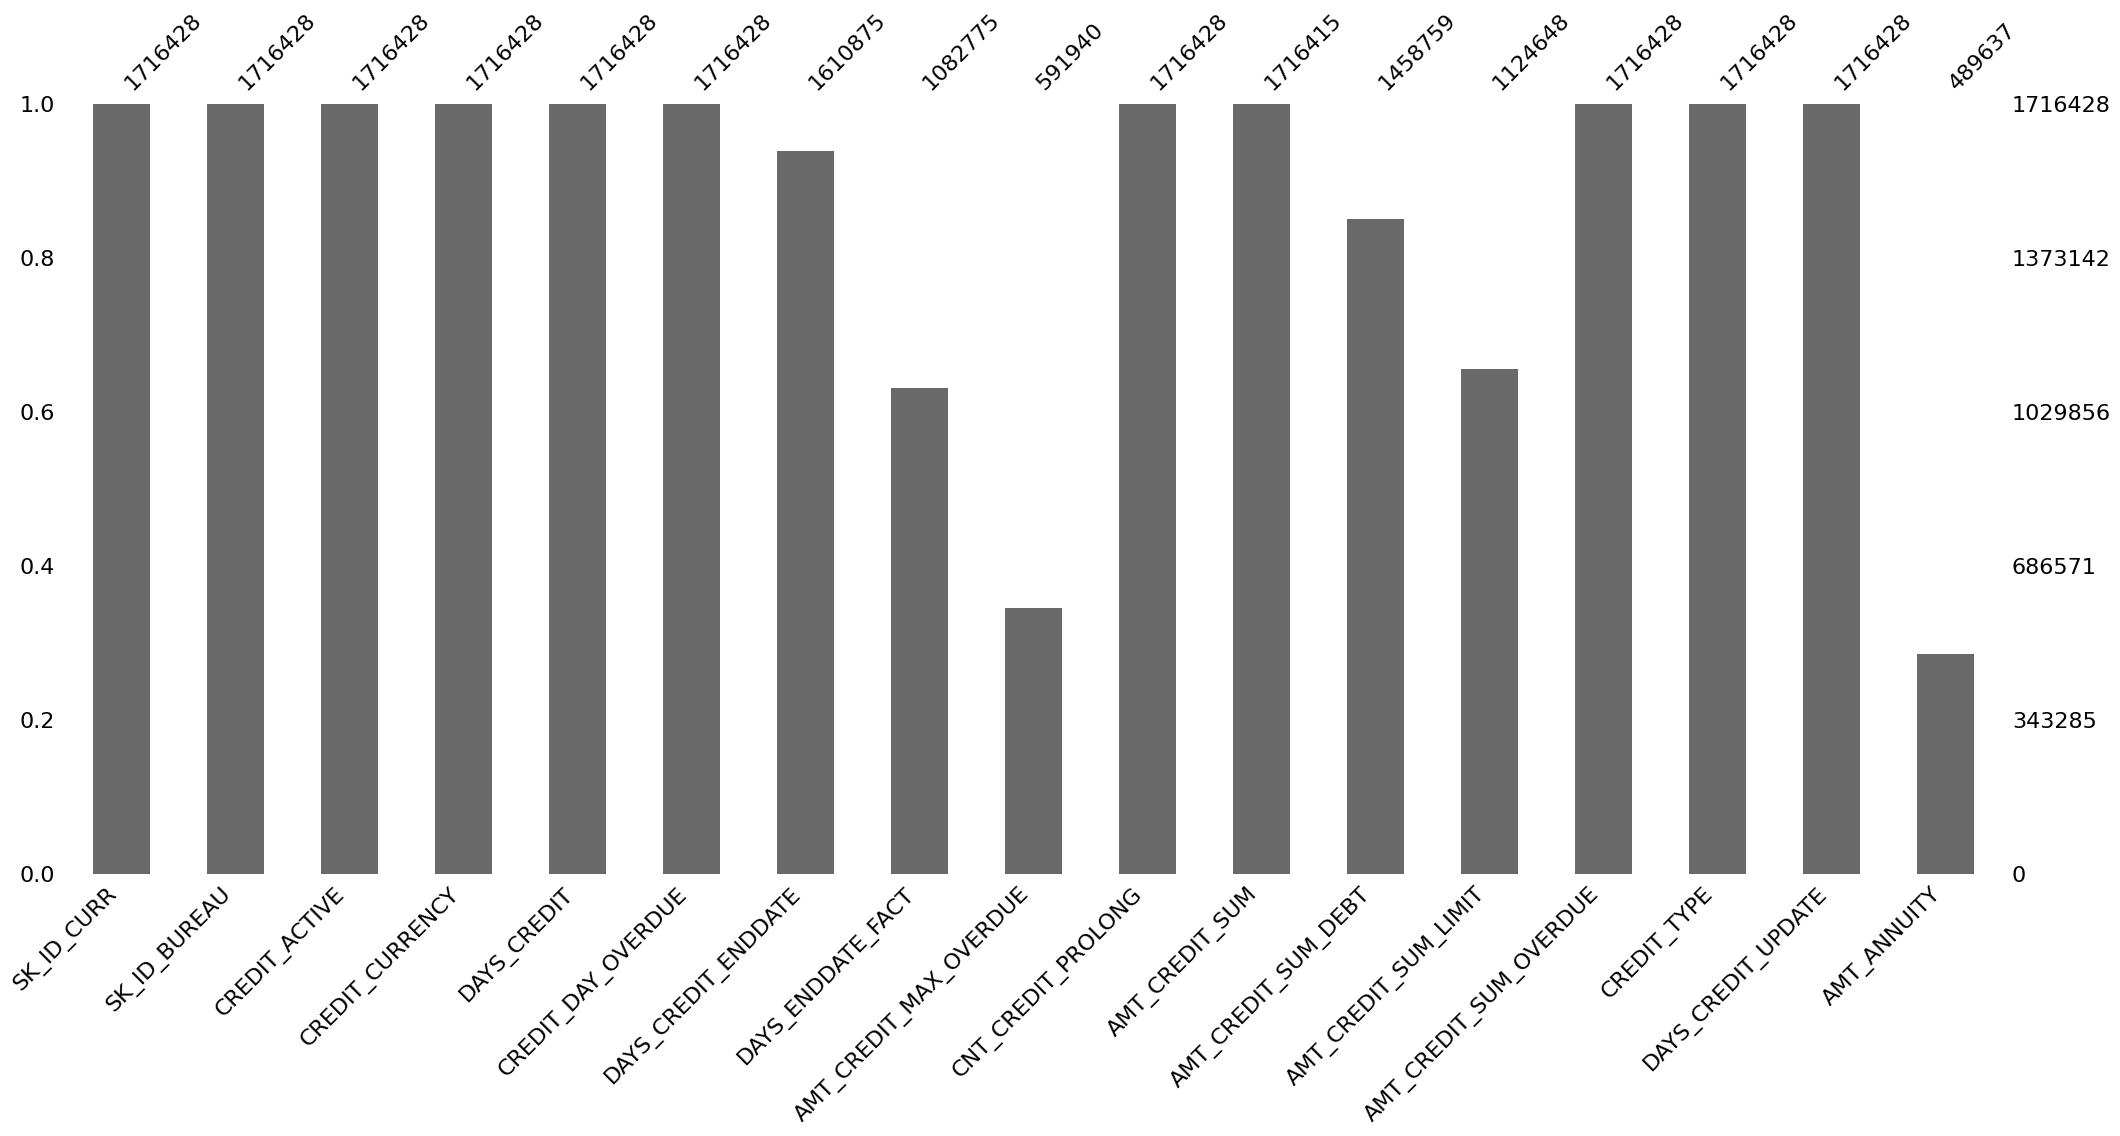

In [196]:
fonctions_data.description_dataset(bureau, 'bureau data')

<Axes: title={'center': 'Répartition des types de colonnes'}>

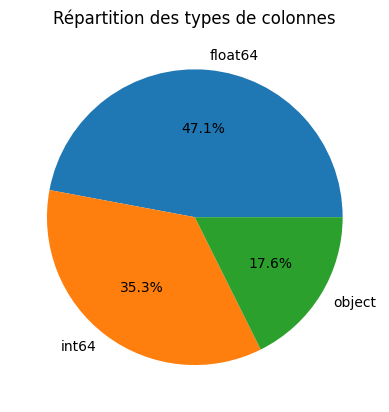

In [197]:
# Types des variables
bureau.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

In [149]:
bureau = fonctions_data.reduce_mem_usage(bureau, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 222.62 MB
Memory usage après optimization: 112.95 MB
Diminution de 49.3%
-------------------------------------------------------------------------------


<Axes: title={'center': 'Répartition des types de colonnes'}>

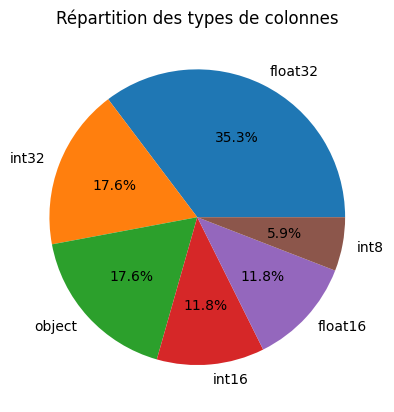

In [199]:
# Types des variables
bureau.dtypes.value_counts().plot(kind='pie',autopct="%1.1f%%", title = "Répartition des types de colonnes")

#### <span style='background:Moccasin'>5.2.2. Feature Engineering</span>

**Feature engineering**
- Création de nouvelles variables simples
- Catégorisation des variables binaires
- Imputation des valeurs manquantes
- Encodage des variables catégorielles
- Normalisation des variables numériques

In [552]:
def bureau_simple():

    bur = bureau

    # Durée du crédit
    bur['CREDIT_DURATION'] = np.abs(bur['DAYS_CREDIT'] - bur['DAYS_CREDIT_ENDDATE'])
    
    # Retard sur le crédit
    bur['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1
                                     for ele in bur['CREDIT_DAY_OVERDUE']]
    
    # Ratio : Montant maximal des impayés sur le crédit du Credit Bureau jusqu'à
    #         présent (à la date de demande du prêt dans notre échantillon) \
    #         Durée du crédit
    bur['MAX_AMT_OVERDUE_DURATION_RATIO'] = \
        bur['AMT_CREDIT_MAX_OVERDUE'] / (bur['CREDIT_DURATION'] + 0.00001)
    # Ratio : Montant actuel en retard sur le crédit du Bureau de crédit \
    #         Durée du crédit
    bur['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = \
        bur['AMT_CREDIT_SUM_OVERDUE'] / (bur['CREDIT_DURATION'] + 0.00001)
    # Ratio : Montant actuel en retard sur le crédit du Bureau de crédit \
    #         Durée restante du crédit CB (en jours)
    bur['AMT_OVERDUE_DURATION_LEFT_RATIO'] = \
        bur['AMT_CREDIT_SUM_OVERDUE'] / (bur['DAYS_CREDIT_ENDDATE']
                                            + 0.00001)
    # Ratio : Nombre de fois où le crédit du Bureau de crédit a été prolongé \
    #         Durée restante du crédit CB (en jours)
    bur['CNT_PROLONGED_MAX_OVERDUE_MUL'] = \
        bur['CNT_CREDIT_PROLONG'] * bur['AMT_CREDIT_MAX_OVERDUE']
    # Ratio : Nombre de fois où le crédit du Bureau de crédit a été prolongé \
    #         Montant maximal des impayés sur le crédit
    bur['CNT_PROLONGED_DURATION_RATIO'] = \
        bur['CNT_CREDIT_PROLONG'] / (bur['CREDIT_DURATION'] + 0.00001)
    # Ratio : Dette actuelle sur le crédit \
    #         Limite de crédit actuelle de la carte de crédit
    bur['CURRENT_DEBT_TO_CREDIT_RATIO'] = \
        bur['AMT_CREDIT_SUM_DEBT'] / (bur['AMT_CREDIT_SUM'] + 0.00001)
    # Ratio : Annuité du crédit \
    #         Limite de crédit actuelle de la carte de crédit
    bur['AMT_ANNUITY_CREDIT_RATIO'] = \
        bur['AMT_ANNUITY'] / (bur['AMT_CREDIT_SUM'] + 0.00001)
    
    
    # Différence :  Limite de crédit actuelle de la carte de crédit -
    #               Dette actuelle sur le crédit
    bur['CURRENT_CREDIT_DEBT_DIFF'] = \
        bur['AMT_CREDIT_SUM'] - bur['AMT_CREDIT_SUM_DEBT']
    # Différence : nombre de jours avant la demande de prêt où la dernière
    #              information sur la solvabilité du Credit Bureau a été fournie -
    #              Durée restante du crédit CB (en jours)
    bur['CREDIT_ENDDATE_UPDATE_DIFF'] = \
        np.abs(bur['DAYS_CREDIT_UPDATE'] - bur['DAYS_CREDIT_ENDDATE'])

    # Ajout des variables de statistiques
    aggregations = {'DAYS_CREDIT' : ['mean', 'min', 'max', 'last'],
                    'CREDIT_DAY_OVERDUE' : ['mean', 'max'],
                    'DAYS_CREDIT_ENDDATE' : ['mean', 'min', 'max'],
                    'DAYS_ENDDATE_FACT' : ['mean', 'min', 'var'],
                    'AMT_CREDIT_MAX_OVERDUE': ['max', 'sum'],
                    'CNT_CREDIT_PROLONG': ['max', 'sum'],
                    'AMT_CREDIT_SUM' : ['mean', 'sum', 'max'],
                    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
                    'AMT_CREDIT_SUM_LIMIT': ['mean', 'max', 'sum'],
                    'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
                    'DAYS_CREDIT_UPDATE' : ['mean', 'min'],
                    'AMT_ANNUITY' : ['mean', 'sum', 'min', 'max', 'count', 'var'],
                    'CREDIT_DURATION' : ['min', 'max', 'mean'],
                    'FLAG_OVERDUE_RECENT': ['count', 'sum'],
                    'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max', 'sum'],
                    'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max', 'sum'],
                    'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max',  'mean'],
                    'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean', 'max'],
                    'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                    'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                    'CURRENT_CREDIT_DEBT_DIFF' : ['mean', 'min'],
                    'AMT_ANNUITY_CREDIT_RATIO' : ['mean', 'min', 'max'],
                    'CREDIT_ENDDATE_UPDATE_DIFF' : ['max', 'min']}
    
    agg_bureau_num = \
        agg_var_num(bur.drop(columns=['SK_ID_BUREAU']),
                                         'SK_ID_CURR', aggregations, 'BUREAU')
    
    print('"Bureau" final shape:', agg_bureau_num.shape)

    return agg_bureau_num
        

In [553]:
bureau_fe = bureau_simple()

"Bureau" final shape: (305811, 60)


In [554]:
bureau_fe.head()

SK_ID_CURR  BUREAU_DAYS_CREDIT_MEAN  BUREAU_DAYS_CREDIT_MIN  \
0      100001              -735.000000                   -1572   
1      100002              -874.000000                   -1437   
2      100003             -1400.750000                   -2586   
3      100004              -867.000000                   -1326   
4      100005              -190.666667                    -373   

   BUREAU_DAYS_CREDIT_MAX  BUREAU_DAYS_CREDIT_LAST  \
0                     -49                     -320   
1                    -103                    -1043   
2                    -606                     -606   
3                    -408                     -408   
4                     -62                      -62   

   BUREAU_CREDIT_DAY_OVERDUE_MEAN  BUREAU_CREDIT_DAY_OVERDUE_MAX  \
0                             0.0                              0   
1                             0.0                              0   
2                             0.0                              0   
3                             0.0                              0   
4                             0.0                              0   

   BUREAU_DAYS_CREDIT_ENDDATE_MEAN  BUREAU_DAYS_CREDIT_ENDDATE_MIN  \
0                        82.428571                         -1329.0   
1                      -349.000000                         -1072.0   
2                      -544.500000                         -2434.0   
3                      -488.500000                          -595.0   
4                       439.333333                          -128.0   

   BUREAU_DAYS_CREDIT_ENDDATE_MAX  ...  \
0                          1778.0  ...   
1                           780.0  ...   
2                          1216.0  ...   
3                          -382.0  ...   
4                          1324.0  ...   

   BUREAU_CNT_PROLONGED_DURATION_RATIO_MAX  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MEAN  \
0                                  0.282518   
1                                  0.109236   
2                                  0.000000   
3                                  0.000000   
4                                  0.601256   

   BUREAU_CURRENT_DEBT_TO_CREDIT_RATIO_MIN  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   BUREAU_CURRENT_CREDIT_DEBT_DIFF_MEAN  BUREAU_CURRENT_CREDIT_DEBT_DIFF_MIN  \
0                         122382.642857                               4761.0   
1                          98388.513000                                  0.0   
2                         254350.125000                              22248.0   
3                          94518.900000                              94500.0   
4                          29572.500000                               4504.5   

   BUREAU_AMT_ANNUITY_CREDIT_RATIO_MEAN  BUREAU_AMT_ANNUITY_CREDIT_RATIO_MIN  \
0                              0.013996                                  0.0   
1                              0.000000                                  0.0   
2                                   NaN                                  NaN   
3                                   NaN                                  NaN   
4                              0.047626                                  0.0   

   BUREAU_AMT_ANNUITY_CREDIT_RATIO_MAX  BUREAU_CREDIT_ENDDATE_UPDATE_DIFF_MAX  \
0                             0.055627                                 1794.0   
1                             0.000000                                  820.0   
2                                  NaN                                 1259.0   
3                                  NaN                                   87

**Aggrégation des variables qualitatives**

In [556]:
agg_bureau_cat = fontions_data.agg_var_cat(bureau, 'SK_ID_CURR',
                                                  'BUREAU')
print(f'{agg_bureau_cat.shape}')
agg_bureau_cat.head()

(305811, 69)


BUREAU_CREDIT_ACTIVE_Active_sum  \
SK_ID_CURR                                    
100001                                    3   
100002                                    2   
100003                                    1   
100004                                    0   
100005                                    2   

            BUREAU_CREDIT_ACTIVE_Active_count  \
SK_ID_CURR                                      
100001                                      7   
100002                                      8   
100003                                      4   
100004                                      2   
100005                                      3   

            BUREAU_CREDIT_ACTIVE_Active_mean  \
SK_ID_CURR                                     
100001                              0.428571   
100002                              0.250000   
100003                              0.250000   
100004                              0.000000   
100005                              0.666667   

            BUREAU_CREDIT_ACTIVE_Bad debt_sum  \
SK_ID_CURR                                      
100001                                      0   
100002                                      0   
100003                                      0   
100004                                      0   
100005                                      0   

            BUREAU_CREDIT_ACTIVE_Bad debt_count  \
SK_ID_CURR                                        
100001                                        7   
100002                                        8   
100003                                        4   
100004                                        2   
100005                                        3   

            BUREAU_CREDIT_ACTIVE_Bad debt_mean  \
SK_ID_CURR                                       
100001                                     0.0   
100002                                     0.0   
100003                                     0.0   
100004                                     0.0   
100005                                     0.0   

            BUREAU_CREDIT_ACTIVE_Closed_sum  \
SK_ID_CURR                                    
100001                                    4   
100002                                    6   
100003                                    3   
100004                                    2   
100005                                    1   

            BUREAU_CREDIT_ACTIVE_Closed_count  \
SK_ID_CURR                                      
100001                                      7   
100002                                      8   
100003                                      4   
100004                                      2   
100005                                      3   

            BUREAU_CREDIT_ACTIVE_Closed_mean  BUREAU_CREDIT_ACTIVE_Sold_sum  \
SK_ID_CURR                                                                    
100001                              0.571429                              0   
100002                              0.750000                              0   
100003                              0.750000                              0   
100004                              1.000000                              0   
100005                              0.333333                              0   

            ...  BUREAU_CREDIT_TYPE_Mobile operator loan_mean  \
SK_ID_CURR  ...                                                 
100001      ...                                           0.0   
100002      ...                                           0.0   
100003      ...                                           0.0   
100004      ...                                           0.0   
100005      ...                                           0.0   

            BUREAU_CREDIT_TYPE_Mortgage_sum  \
SK_ID_CURR                                    
100001                                    0   
100002                                    0   
100003                                    0   
100004                       

#### <span style='background:Moccasin'>5.2.3. Assemblage avec le 'train set'</span>

In [557]:
features_set = features_set.merge(agg_bureau_cat, how='left', on='SK_ID_CURR')
print('--=> features_set after merge with agg_bureau_cat:', features_set.shape)

--=> features_set after merge with agg_bureau_cat: (307507, 564)


In [558]:
# Description
fonctions_data.detail_type_var(features_set, type_var='all')

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type            int32            float16     float16      float16   
nb_nan            0.0                0.0         0.0          0.0   
%_nan             0.0                0.0         0.0          0.0   
count        307507.0           307507.0    307507.0     307507.0   
mean    278181.527256                0.0         NaN          NaN   
std     102790.132982                0.0         0.0          0.0   
min          100002.0                0.0         0.0          0.0   
25%          189146.5                0.0         0.0          0.0   
50%          278203.0                0.0         0.0          1.0   
75%          367143.5                0.0         1.0          1.0   
max          456255.0                1.0         1.0          1.0   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type           float16      float16          float16    float16     float16   
nb_nan             0.0          0.0              0.0        0.0         0.0   
%_nan              0.0          0.0              0.0        0.0         0.0   
count         307507.0     307507.0         307507.0   307507.0    307507.0   
mean               NaN          0.0              0.0        0.0         0.0   
std                0.0          0.0              0.0        0.0         0.0   
min                0.0          0.0              0.0        0.0         0.0   
25%                0.0          0.0         0.000742   0.056183    0.058136   
50%                0.0          0.0         0.001039   0.117004     0.09082   
75%                1.0     0.052643         0.001512   0.190674    0.128662   
max                1.0          1.0              1.0        1.0         1.0   

       REGION_POPULATION_RELATIVE  ...  \
type                      float16  ...   
nb_nan                        0.0  ...   
%_nan                         0.0  ...   
count                    307507.0  ...   
mean                          NaN  ...   
std                           0.0  ...   
min                           0.0  ...   
25%                      0.134644  ...   
50%                      0.256836  ...   
75%                      0.392822  ...   
max                           1.0  ...   

       BUREAU_CREDIT_TYPE_Mobile operator loan_mean  \
type                                        float64   
nb_nan                                      44020.0   
%_nan                                     14.315121   
count                                      263487.0   
mean                                            0.0   
std                                        0.000122   
min                                             0.0   
25%                                             0.0   
50%                                             0.0   
75%                                             0.0   
max                                          0.0625   

       BUREAU_CREDIT_TYPE_Mortgage_sum BUREAU_CREDIT_TYPE_Mortgage_count  \
type                           float64                           float64   
nb_nan                         44020.0                           44020.0   
%_nan                        14.315121                         14.315121   
count                         263487.0                          263487.0   
mean                          0.059233                          5.561151   
std                           0.260007                          4.377911   
min                                0.0                               1.0   
25%                                0.0                               2.0   
50%                                0.0                               4.0   
75%                                0.0                               8.0   
max                               13.0                             116.0   

       BUREAU_CREDIT_TYPE_Mortgage_mean  \
type                            float64   
nb_nan                          44020.0   
%_nan                    

#### <span style='background:Moccasin'>5.2.4. Assemblage avec le 'test set'</span>

In [559]:
test_features_set = test_features_set.merge(agg_bureau_cat, how='left', on='SK_ID_CURR')
print('--=> test_features_set after merge with agg_bureau_cat:', test_features_set.shape)

--=> test_features_set after merge with agg_bureau_cat: (48744, 554)


In [560]:
# Description
fonctions_data.detail_type_var(test_features_set, type_var='all')

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
type            int32            float16     float16      float16   
nb_nan            0.0                0.0         0.0          0.0   
%_nan             0.0                0.0         0.0          0.0   
count         48744.0            48744.0     48744.0      48744.0   
mean     277796.67635            0.00901     0.32959     0.337158   
std     103169.547296           0.094482    0.470215       0.4729   
min          100001.0                0.0         0.0          0.0   
25%         188557.75                0.0         0.0          0.0   
50%          277549.0                0.0         0.0          0.0   
75%          367555.5                0.0         1.0          1.0   
max          456250.0                1.0         1.0          1.0   

       FLAG_OWN_REALTY CNT_CHILDREN AMT_INCOME_TOTAL AMT_CREDIT AMT_ANNUITY  \
type           float16      float16          float16    float16     float16   
nb_nan             0.0          0.0              0.0        0.0         0.0   
%_nan              0.0          0.0              0.0        0.0         0.0   
count          48744.0      48744.0          48744.0    48744.0     48744.0   
mean          0.690918     0.020905         0.001307   0.117798    0.108521   
std           0.462402     0.037323          0.00088   0.091248    0.062439   
min                0.0          0.0         0.000011        0.0    0.002649   
25%                0.0          0.0         0.000742   0.053833    0.063782   
50%                1.0          0.0         0.001127   0.101135    0.095886   
75%                1.0     0.052643         0.001704   0.157349    0.139526   
max                1.0     1.052734         0.037476   0.549316    0.697754   

       REGION_POPULATION_RELATIVE  ...  \
type                      float16  ...   
nb_nan                        0.0  ...   
%_nan                         0.0  ...   
count                     48744.0  ...   
mean                     0.290039  ...   
std                      0.199829  ...   
min                     -0.000511  ...   
25%                      0.134521  ...   
50%                       0.25708  ...   
75%                      0.392822  ...   
max                           1.0  ...   

       BUREAU_CREDIT_TYPE_Mobile operator loan_mean  \
type                                        float64   
nb_nan                                       6424.0   
%_nan                                     13.179058   
count                                       42320.0   
mean                                            0.0   
std                                             0.0   
min                                             0.0   
25%                                             0.0   
50%                                             0.0   
75%                                             0.0   
max                                             0.0   

       BUREAU_CREDIT_TYPE_Mortgage_sum BUREAU_CREDIT_TYPE_Mortgage_count  \
type                           float64                           float64   
nb_nan                          6424.0                            6424.0   
%_nan                        13.179058                         13.179058   
count                          42320.0                           42320.0   
mean                          0.065784                          5.933436   
std                           0.271997                          4.731385   
min                                0.0                               1.0   
25%                                0.0                               2.0   
50%                                0.0                               5.0   
75%                                0.0                               8.0   
max                                4.0                              78.0   

       BUREAU_CREDIT_TYPE_Mortgage_mean  \
type                            float64   
nb_nan                           6424.0   
%_nan                    

#### <span style='background:Moccasin'>5.2.5. Nettoyage</span>

<span style='background:mistyrose'>**Réduction mémoire des dataframes**</span>

In [561]:
features_set = fonctions_data.reduce_mem_usage(features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 503.53 MB
Memory usage après optimization: 382.12 MB
Diminution de 24.1%
-------------------------------------------------------------------------------


In [562]:
test_features_set = fonctions_data.reduce_mem_usage(test_features_set, verbose=True)

-------------------------------------------------------------------------------
Memory usage du dataframe: 78.56 MB
Memory usage après optimization: 59.32 MB
Diminution de 24.5%
-------------------------------------------------------------------------------


<span style='background:mistyrose'>**Variables fortement corrélées**</span>

In [563]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_features_set = fonctions_data.suppr_var_colineaire(features_set)

34 variables fortement corrélées à supprimer :

BUREAU_CREDIT_ACTIVE_Bad debt_count
BUREAU_CREDIT_ACTIVE_Bad debt_mean
BUREAU_CREDIT_ACTIVE_Closed_sum
BUREAU_CREDIT_ACTIVE_Closed_count
BUREAU_CREDIT_ACTIVE_Closed_mean
BUREAU_CREDIT_ACTIVE_Sold_count
BUREAU_CREDIT_CURRENCY_currency 1_sum
BUREAU_CREDIT_CURRENCY_currency 1_count
BUREAU_CREDIT_CURRENCY_currency 2_count
BUREAU_CREDIT_CURRENCY_currency 2_mean
BUREAU_CREDIT_CURRENCY_currency 3_count
BUREAU_CREDIT_CURRENCY_currency 4_count
BUREAU_CREDIT_CURRENCY_currency 4_mean
BUREAU_CREDIT_TYPE_Another type of loan_count
BUREAU_CREDIT_TYPE_Car loan_count
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean
BUREAU_CREDIT_TYPE_Consumer credit_sum
BUREAU_CREDIT_TYPE_Consumer credit_count
BUREAU_CREDIT_TYPE_Credit card_count
BUREAU_CREDIT_TYPE_Credit card_mean
BUREAU_CREDIT_TYPE_Interbank credit_count
BUREAU_CREDIT_TYPE_Interbank credit_mean
BUREAU_CREDIT_TYPE_Loan for business development_count
BU

In [564]:
# Gestion des variables fortement corrélées à supprimer train set
var_corr_test_features_set = fonctions_data.suppr_var_colineaire(test_features_set)

33 variables fortement corrélées à supprimer :

BUREAU_CREDIT_ACTIVE_Bad debt_count
BUREAU_CREDIT_ACTIVE_Bad debt_mean
BUREAU_CREDIT_ACTIVE_Closed_sum
BUREAU_CREDIT_ACTIVE_Closed_count
BUREAU_CREDIT_ACTIVE_Closed_mean
BUREAU_CREDIT_ACTIVE_Sold_count
BUREAU_CREDIT_CURRENCY_currency 1_sum
BUREAU_CREDIT_CURRENCY_currency 1_count
BUREAU_CREDIT_CURRENCY_currency 2_count
BUREAU_CREDIT_CURRENCY_currency 2_mean
BUREAU_CREDIT_CURRENCY_currency 3_count
BUREAU_CREDIT_CURRENCY_currency 4_count
BUREAU_CREDIT_CURRENCY_currency 4_mean
BUREAU_CREDIT_TYPE_Another type of loan_count
BUREAU_CREDIT_TYPE_Car loan_count
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_count
BUREAU_CREDIT_TYPE_Consumer credit_sum
BUREAU_CREDIT_TYPE_Consumer credit_count
BUREAU_CREDIT_TYPE_Credit card_count
BUREAU_CREDIT_TYPE_Credit card_mean
BUREAU_CREDIT_TYPE_Interbank credit_count
BUREAU_CREDIT_TYPE_Loan for business development_count
BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count
BUREAU_CREDIT_TYPE_Loan

***Train set***

In [565]:
# Suppression des variables fortement corrélées du train set
features_set = features_set.drop(columns = var_corr_features_set)
print(f'train_set : {features_set.shape}')

train_set : (307507, 530)


***Test set***

In [566]:
# Suppression des variables fortement corrélées du train set
test_features_set = test_features_set.drop(columns = var_corr_test_features_set)
print(f'test_set : {test_features_set.shape}')

test_set : (48744, 521)


<span style='background:mistyrose'>**Imputation des données**</span>

***Train set***

Valeurs manquantes :1540700 NaN pour 175894004 données (0.88 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
BUREAU_CREDIT_ACTIVE_Active_sum                                             44020   
BUREAU_CREDIT_TYPE_Microloan_sum                                            44020   
BUREAU_CREDIT_TYPE_Loan for business developmen...                          44020   
BUREAU_CREDIT_TYPE_Loan for purchase of shares ...                          44020   
BUREAU_CREDIT_TYPE_Loan for the purchase of equ...                          44020   
BUREAU_CREDIT_TYPE_Loan for the purchase of equ...                          44020   
BUREAU_CREDIT_TYPE_Loan for working capital rep...                          44020   
BUREAU_CREDIT_TYPE_Loan for working capital rep...                          44020   
BUREAU_CREDIT_TYPE_Microloan_mean                                           44020   
BUREAU_CREDIT_TYPE_Interbank credit_sum                                     44020   
BUREAU_CREDIT_TYPE_Mobile operator loan_sum                                 44020   
BUREAU_CREDIT_TYPE_Mortgage_sum                                             44020   
BUREAU_CREDIT_TYPE_Mortgage_mean                                            44020   
BUREAU_CREDIT_TYPE_Real estate loan_sum                                     44020   
BUREAU_CREDIT_TYPE_Real estate loan_mean                                    44020   
BUREAU_CREDIT_TYPE_Unknown type of loan_sum                                 44020   
BUREAU_CREDIT_TYPE_Loan for business developmen...                          44020   
BUREAU_CREDIT_TYPE_Credit card_sum                                          44020   
BUREAU_CREDIT_ACTIVE_Active_count                                           44020   
BUREAU_CREDIT_CURRENCY_currency 3_sum                                       44020   
BUREAU_CREDIT_ACTIVE_Active_mean                                            44020   
BUREAU_CREDIT_ACTIVE_Bad debt_sum                                           44020   
BUREAU_CREDIT_ACTIVE_Sold_sum                                               44020   
BUREAU_CREDIT_ACTIVE_Sold_mean                                              44020   
BUREAU_CREDIT_CURRENCY_currency 1_mean                                      44020   
BUREAU_CREDIT_CURRENCY_currency 2_sum                                       44020   
BUREAU_CREDIT_CURRENCY_currency 3_mean                                      44020   
BUREAU_CREDIT_TYPE_Consumer credit_mean                                     44020   
BUREAU_CREDIT_CURRENCY_currency 4_sum                                       44020   
BUREAU_CREDIT_TYPE_Another type of loan_sum                                 44020   
BUREAU_CREDIT_TYPE_Another type of loan_mean                                44020   
BUREAU_CREDIT_TYPE_Car loan_sum                                             44020   
BUREAU_CREDIT_TYPE_Car loan_mean                                            44020   
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum                            44020   
BUREAU_CREDIT_TYPE_Unknown type of loan_mean                                44020   

                                                    % de valeurs manquantes  
BUREAU_CREDIT_ACTIVE_Active_sum                                       14.32  
BUREAU_CREDIT_TYPE_Microloan_sum                                      14.32  
BUREAU_CREDIT_TYPE_Loan for business developmen...                    14.32  
BUREAU_CREDIT_TYPE_Loan for purchase of shares ...                    14.32  
BUREAU_CREDIT_TYPE_Loan for the purchase of equ...                    14.32  
BUREAU_CREDIT_TYPE_Loan for the purchase of equ...                    14.32  
BUREAU_CREDIT_TYPE_Loan for working capital rep...                    14.32  
BUREAU_CREDIT_TYPE_Loan for working capital rep...                    14.32  
BUREAU_CREDIT_TYPE_Microloan_mean                                     14.32  
BUREAU_CREDIT_TYPE_Interbank credit_sum                               14.32  
BUREAU_CREDIT_TYPE_Mobile operator loan_sum                           14.32  
BUREAU_CREDIT_TYPE_Mortgage_sum                        

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


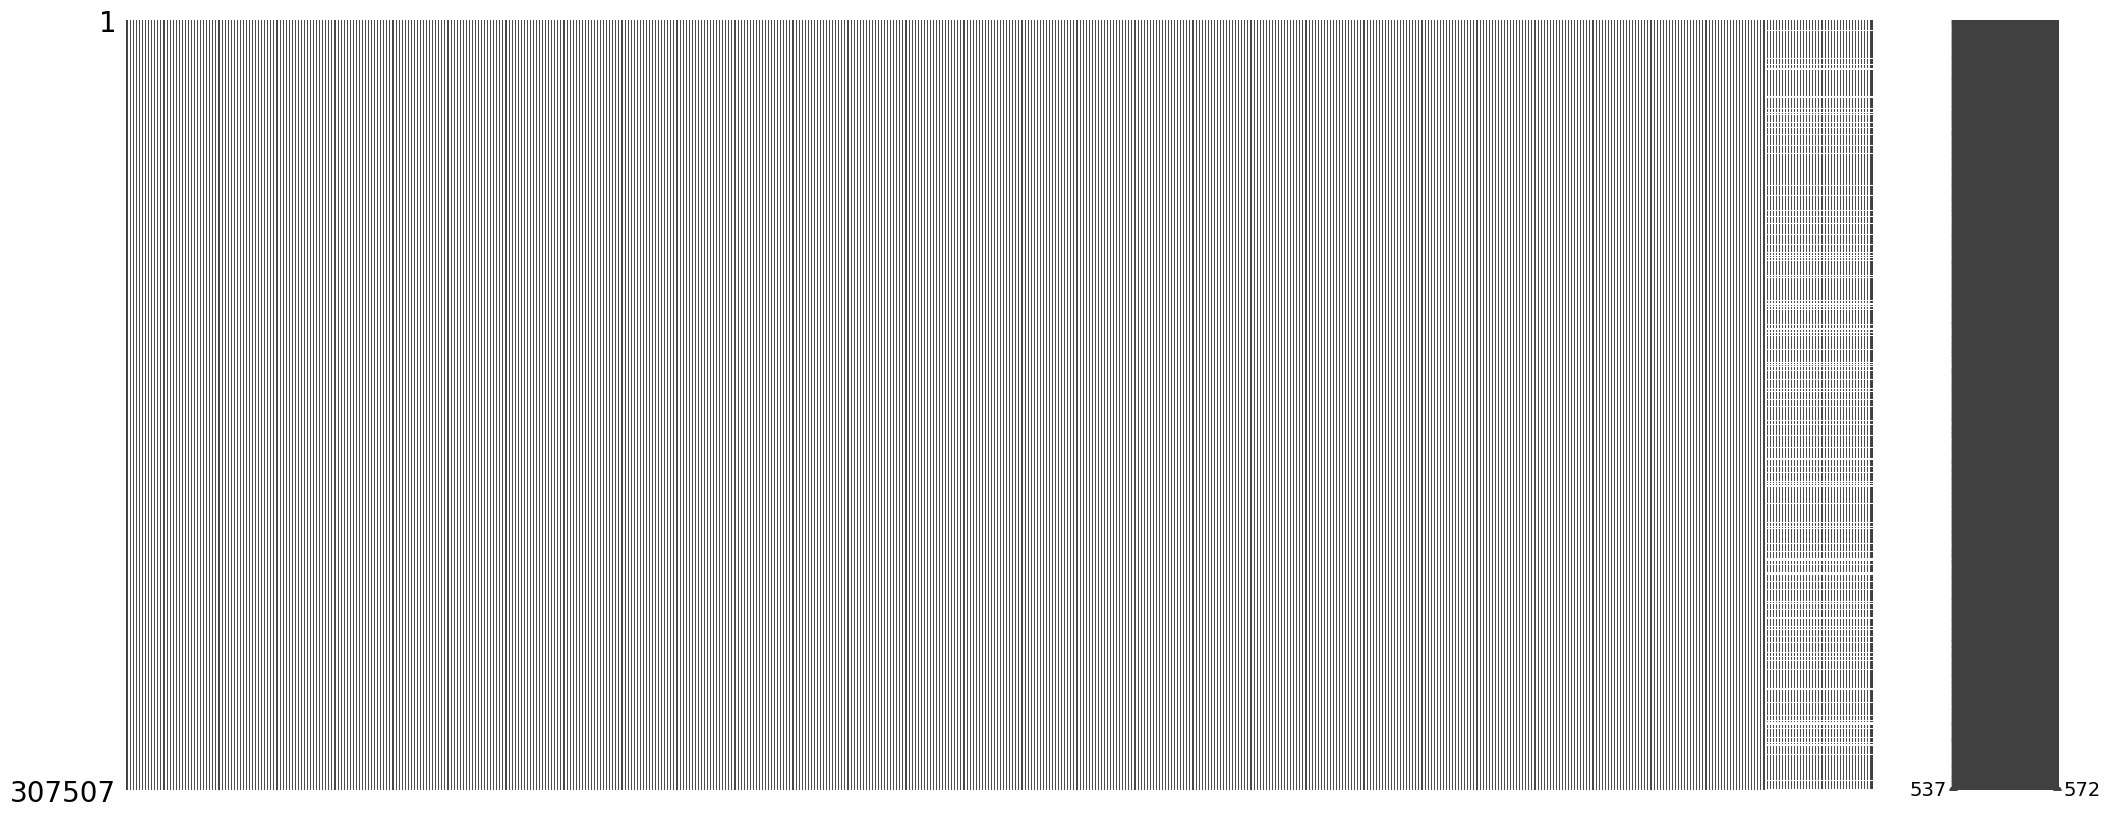

In [240]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [567]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
features_set = features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 1540700
Nombre de nan ou valeurs nulles après suppression des champs vierges : 1540700


**Imputation par la médiane**

In [568]:
# Variables quantitatives - imputation par médiane
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
features_set.fillna(features_set.median(), inplace=True)

# Vérification
nb_nan_median = features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 1540700
Nombre de nan après imputation par median : 0


In [570]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = features_set.columns[(features_set == 0).all()]
colonnes_nulles

Index([], dtype='object')

In [571]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
features_set = features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = features_set.columns[(features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 0
Nombre de champs nulles après imputation: 0


Valeurs manquantes :0 NaN pour 162978710 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


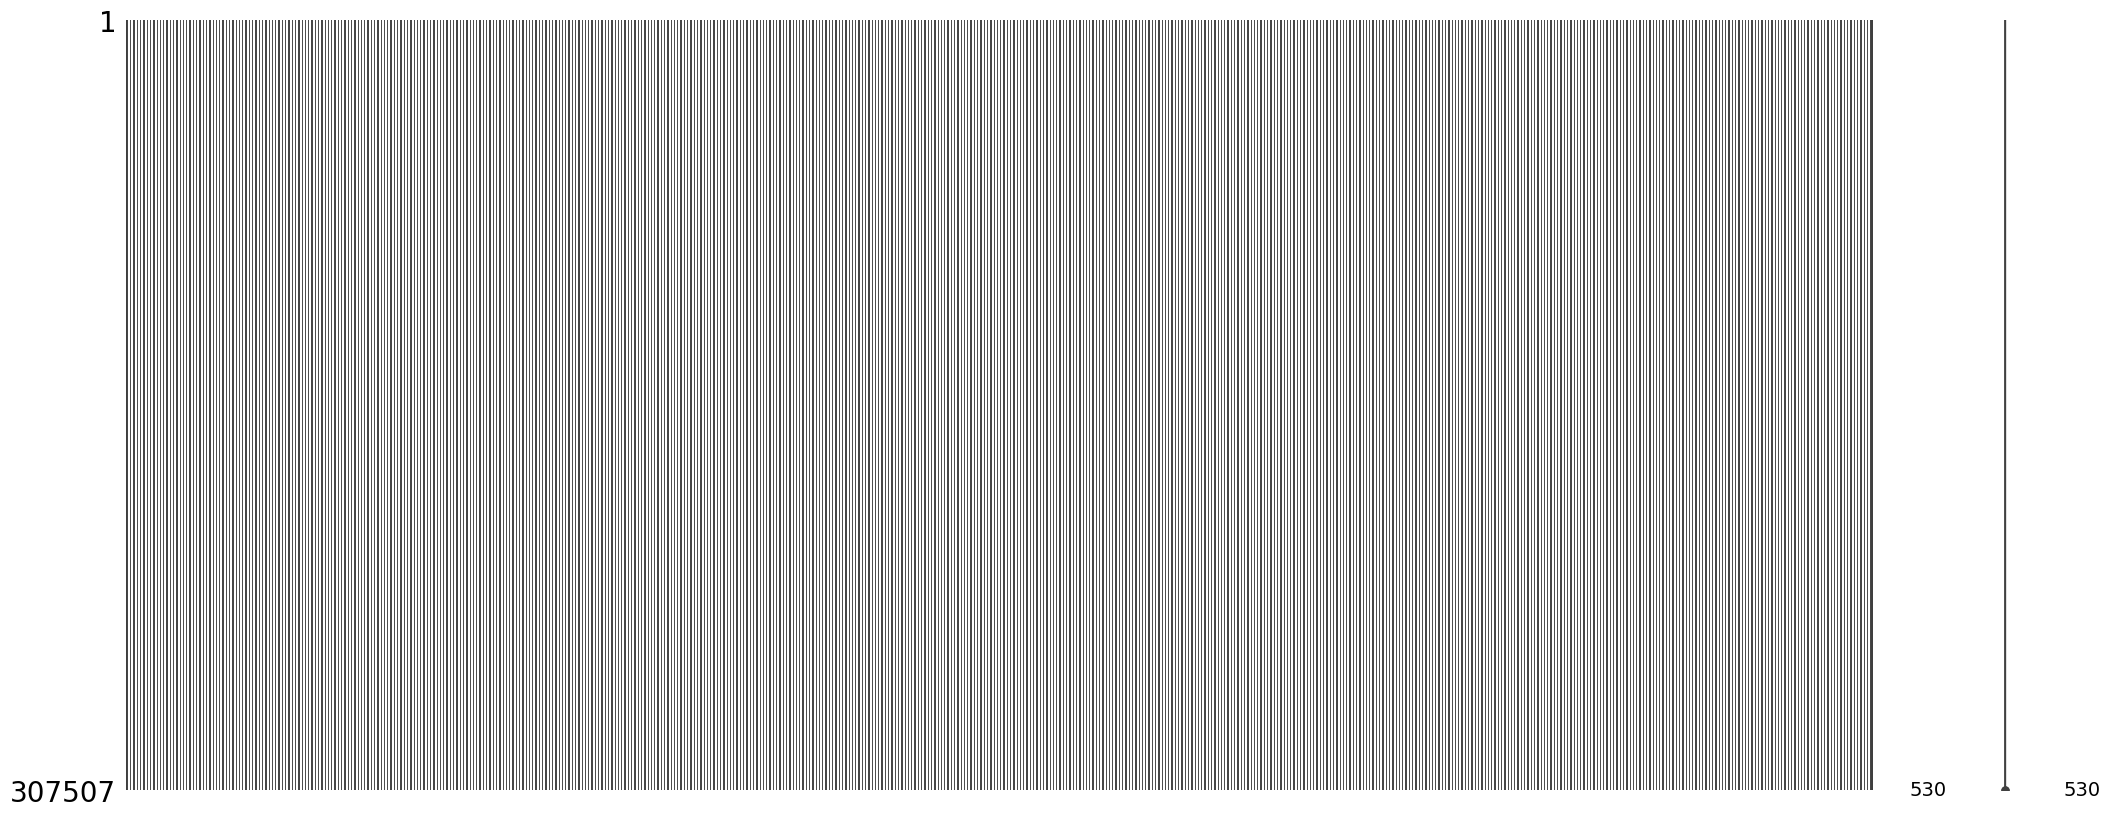

In [577]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(features_set, True, True)

***Test set***

Valeurs manquantes :231264 NaN pour 27784080 données (0.83 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Nombres de valeurs manquantes  \
BUREAU_CREDIT_ACTIVE_Active_sum                                              6424   
BUREAU_CREDIT_ACTIVE_Active_count                                            6424   
BUREAU_CREDIT_TYPE_Interbank credit_mean                                     6424   
BUREAU_CREDIT_TYPE_Loan for business developmen...                           6424   
BUREAU_CREDIT_TYPE_Loan for business developmen...                           6424   
BUREAU_CREDIT_TYPE_Loan for purchase of shares ...                           6424   
BUREAU_CREDIT_TYPE_Loan for purchase of shares ...                           6424   
BUREAU_CREDIT_TYPE_Loan for the purchase of equ...                           6424   
BUREAU_CREDIT_TYPE_Loan for working capital rep...                           6424   
BUREAU_CREDIT_TYPE_Loan for working capital rep...                           6424   
BUREAU_CREDIT_TYPE_Microloan_sum                                             6424   
BUREAU_CREDIT_TYPE_Microloan_mean                                            6424   
BUREAU_CREDIT_TYPE_Mobile operator loan_sum                                  6424   
BUREAU_CREDIT_TYPE_Mobile operator loan_mean                                 6424   
BUREAU_CREDIT_TYPE_Mortgage_sum                                              6424   
BUREAU_CREDIT_TYPE_Mortgage_mean                                             6424   
BUREAU_CREDIT_TYPE_Real estate loan_sum                                      6424   
BUREAU_CREDIT_TYPE_Interbank credit_sum                                      6424   
BUREAU_CREDIT_TYPE_Credit card_sum                                           6424   
BUREAU_CREDIT_TYPE_Consumer credit_mean                                      6424   
BUREAU_CREDIT_CURRENCY_currency 3_sum                                        6424   
BUREAU_CREDIT_ACTIVE_Active_mean                                             6424   
BUREAU_CREDIT_ACTIVE_Bad debt_sum                                            6424   
BUREAU_CREDIT_ACTIVE_Sold_sum                                                6424   
BUREAU_CREDIT_ACTIVE_Sold_mean                                               6424   
BUREAU_CREDIT_CURRENCY_currency 1_mean                                       6424   
BUREAU_CREDIT_CURRENCY_currency 2_sum                                        6424   
BUREAU_CREDIT_CURRENCY_currency 3_mean                                       6424   
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_mean                            6424   
BUREAU_CREDIT_CURRENCY_currency 4_sum                                        6424   
BUREAU_CREDIT_TYPE_Another type of loan_sum                                  6424   
BUREAU_CREDIT_TYPE_Another type of loan_mean                                 6424   
BUREAU_CREDIT_TYPE_Car loan_sum                                              6424   
BUREAU_CREDIT_TYPE_Car loan_mean                                             6424   
BUREAU_CREDIT_TYPE_Cash loan (non-earmarked)_sum                             6424   
BUREAU_CREDIT_TYPE_Unknown type of loan_sum                                  6424   

                                                    % de valeurs manquantes  
BUREAU_CREDIT_ACTIVE_Active_sum                                       13.18  
BUREAU_CREDIT_ACTIVE_Active_count                                     13.18  
BUREAU_CREDIT_TYPE_Interbank credit_mean                              13.18  
BUREAU_CREDIT_TYPE_Loan for business developmen...                    13.18  
BUREAU_CREDIT_TYPE_Loan for business developmen...                    13.18  
BUREAU_CREDIT_TYPE_Loan for purchase of shares ...                    13.18  
BUREAU_CREDIT_TYPE_Loan for purchase of shares ...                    13.18  
BUREAU_CREDIT_TYPE_Loan for the purchase of equ...                    13.18  
BUREAU_CREDIT_TYPE_Loan for working capital rep...                    13.18  
BUREAU_CREDIT_TYPE_Loan for working capital rep...                    13.18  
BUREAU_CREDIT_TYPE_Microloan_sum                

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


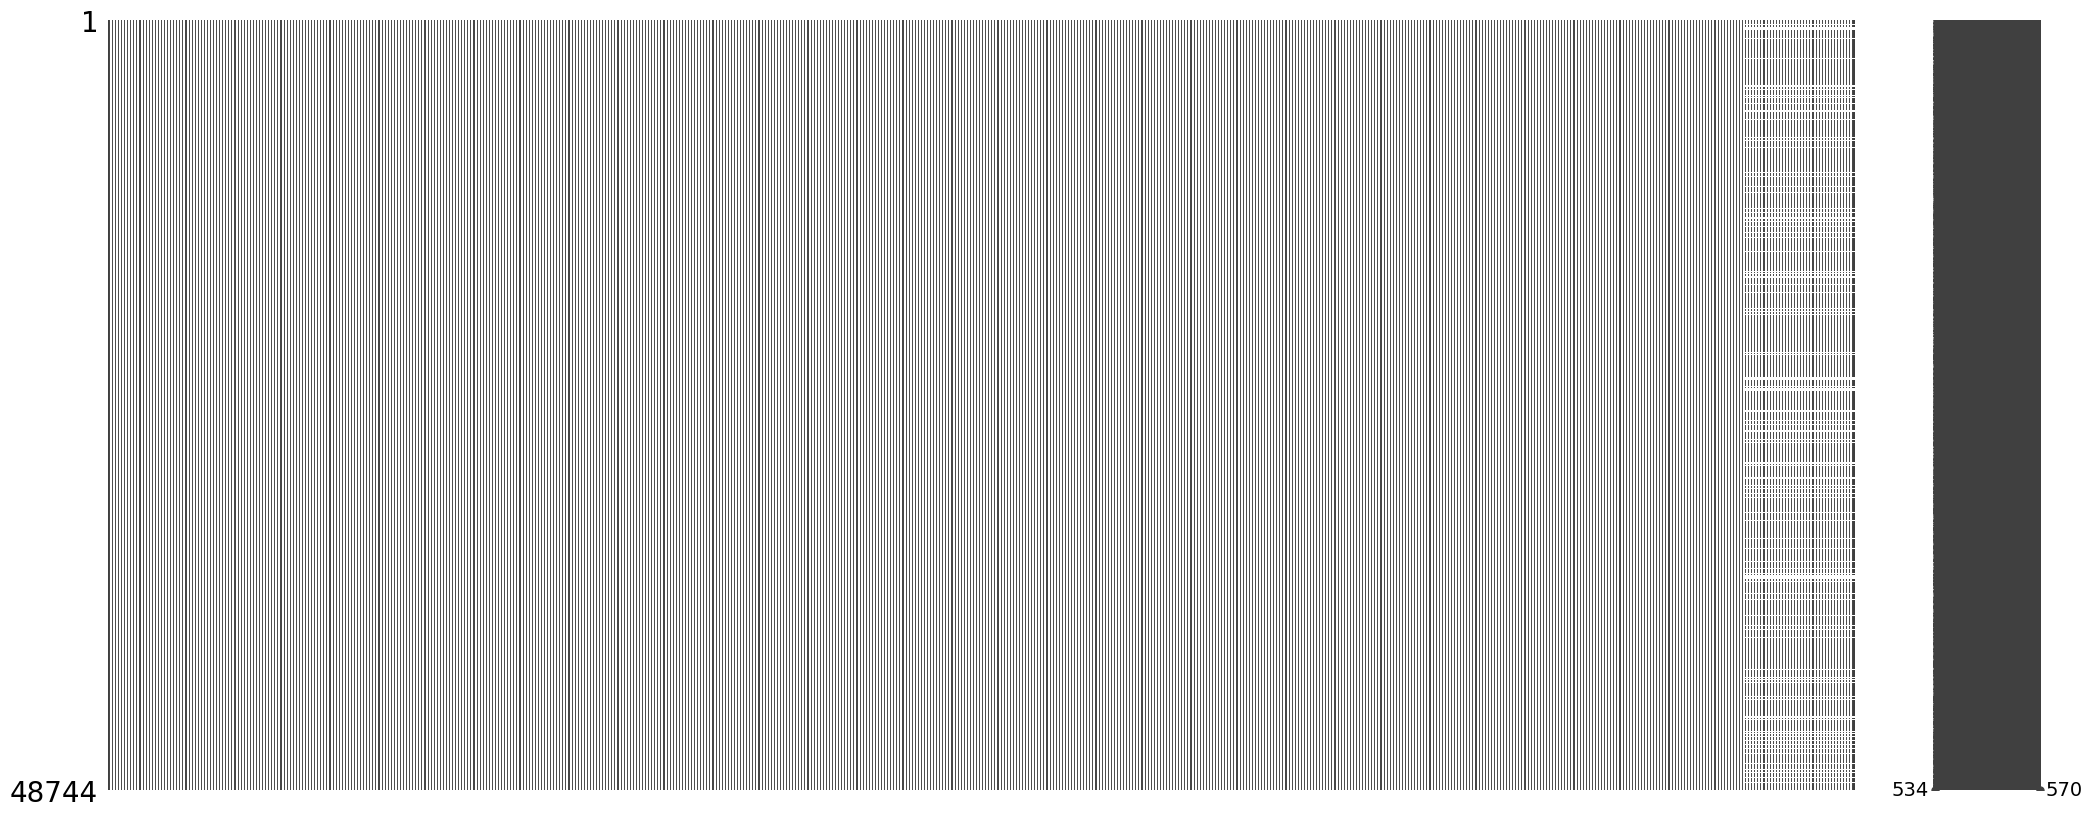

In [243]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

**Suppression des champs ayant uniquement des NaN ou valeurs nulles**

In [572]:
# Supprimer les colonnes avec uniquement des NaN
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles avant suppression des champs vierges : {nb_champs_vierges}')
test_features_set = test_features_set.dropna(axis=1, how='all')
# Vérification
nb_champs_vierges = test_features_set.isna().sum().sum()
print(f'Nombre de nan ou valeurs nulles après suppression des champs vierges : {nb_champs_vierges}')

Nombre de nan ou valeurs nulles avant suppression des champs vierges : 231264
Nombre de nan ou valeurs nulles après suppression des champs vierges : 231264


**Imputation par la médiane**

In [573]:
# Variables quantitatives - imputation par médiane
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan avant imputation par median : {nb_nan_median}')
test_features_set.fillna(test_features_set.median(), inplace=True)

# Vérification
nb_nan_median = test_features_set.isna().sum().sum()
print(f'Nombre de nan après imputation par median : {nb_nan_median}')

Nombre de nan avant imputation par median : 231264
Nombre de nan après imputation par median : 0


In [574]:
# Identifier les colonnes avec uniquement des valeurs nulles (0)
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
colonnes_nulles

Index(['BUREAU_CREDIT_TYPE_Interbank credit_sum',
       'BUREAU_CREDIT_TYPE_Interbank credit_mean',
       'BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_sum',
       'BUREAU_CREDIT_TYPE_Loan for purchase of shares (margin lending)_mean',
       'BUREAU_CREDIT_TYPE_Mobile operator loan_sum',
       'BUREAU_CREDIT_TYPE_Mobile operator loan_mean'],
      dtype='object')

In [575]:
# Obtenir le nombre de colonnes identifiées
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles avant imputation: {nombre_colonnes_nulles}')
# Supprimer les colonnes avec uniquement des valeurs nulles
test_features_set = test_features_set.drop(columns = colonnes_nulles)
# Vérification
colonnes_nulles = test_features_set.columns[(test_features_set == 0).all()]
nombre_colonnes_nulles = len(colonnes_nulles)
print(f'Nombre de champs nulles après imputation: {nombre_colonnes_nulles}')

Nombre de champs nulles avant imputation: 6
Nombre de champs nulles après imputation: 0


Valeurs manquantes :0 NaN pour 25103160 données (0.0 %)
-------------------------------------------------------------
Nombre et pourcentage de valeurs manquantes par variable



Empty DataFrame
Columns: [Nombres de valeurs manquantes, % de valeurs manquantes]
Index: []

-------------------------------------------------------------
Heatmap de visualisation des valeurs manquantes


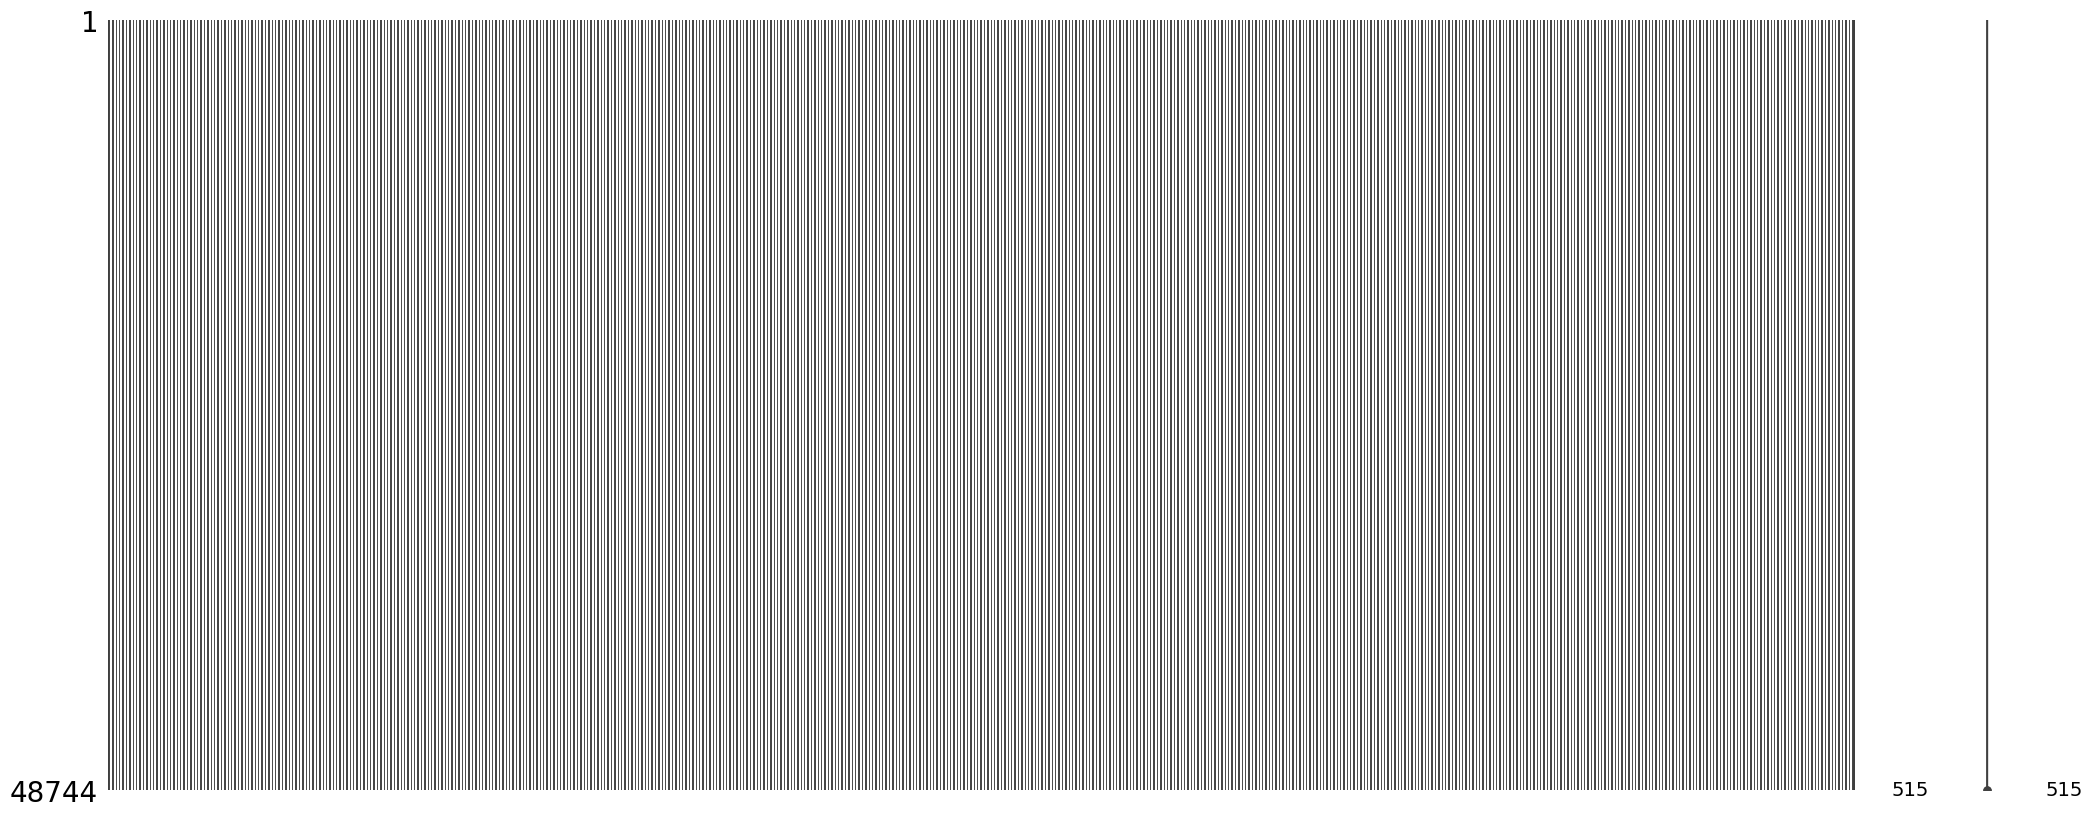

In [576]:
# Visualisation des données manquantes dans le dataset
fonctions_data.get_val_manq(test_features_set, True, True)

## <span style='background:PowderBlue'>6. Dataframe final nettoyé, pré-processing effectué</span>

In [578]:
# Remplacer :, espaces... par '_' et mettre en majuscules le nom des variables
features_set = features_set.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+',
                                                     '_', x.upper()))

In [579]:
features_set.shape

(307507, 530)

In [593]:
test_features_set.shape

(48744, 515)

In [581]:
# Afficher la taille du jeu de données en mémoire
print("La taille du jeu de données est de {:.2f} MB".format(sys.getsizeof(features_set) / (1024*1024)))

La taille du jeu de données est de 362.18 MB


In [594]:
# Afficher la taille du jeu de données en mémoire
print("La taille du jeu de données est de {:.2f} MB".format(sys.getsizeof(test_features_set) / (1024*1024)))

La taille du jeu de données est de 55.69 MB


In [582]:
# Enregistrer le DataFrame en tant que fichier CSV
features_set.to_csv('df_modelisation.csv', index=False)

In [595]:
# Enregistrer le DataFrame en tant que fichier CSV
test_features_set.to_csv('df_modelisation_test.csv', index=False)